# Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.distributions as d
import torch.optim as optim

In [2]:
class Decoder(nn.Module):

    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.mus = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ELU(),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Linear(512, x_dim)
        )

    def forward(self, zs):
        return d.Independent(d.Bernoulli(logits=self.mus(zs)), 1)

In [37]:
class Encoder(nn.Module):
    """Take in image, output distribution over latent vectors"""

    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ELU(),
            nn.Linear(512, 512),
            nn.ELU(),
        )
        self.mus = nn.Linear(512, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(512, z_dim),
            nn.Softplus()  # -> (0, infinity)
        )

    def forward(self, xs):
        xs = self.shared(xs)
        return d.Independent(d.Normal(self.mus(xs), self.sigmas(xs)), 1)


class ImageDLVM:
    """
    This is the VAE class. I personally don't like the name VAE and I prefer DLVM, which stands for Deep Latent Variable Model. This name seems to be
    better connected with theory, e.g., latent variable models, expectation maximization and so on.
    """

    def __init__(self, z_dim, x_dim, lr=1e-3):

        # hyper-parameters
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.lr = lr

        # describes the generative process
        self.p_z = d.Independent(d.Normal(torch.zeros(z_dim), torch.ones(z_dim)), 1)
        self.p_x_given_z = Decoder(z_dim=z_dim, x_dim=x_dim)

        # required for approximate posterior inference
        self.q_z_given_x = Encoder(z_dim=z_dim, x_dim=x_dim)

        # gradient-based optimizers
        self.p_x_given_z_opt = optim.Adam(self.p_x_given_z.parameters(), lr=lr)
        self.q_z_given_x_opt = optim.Adam(self.q_z_given_x.parameters(), lr=lr)

    def fit(self, xs):
        self.p_x_given_z.train()
        self.q_z_given_x.train()
        posterior_over_zs = self.q_z_given_x(xs)
        # kl-divergence
        kl = d.kl.kl_divergence(posterior_over_zs, self.p_z).mean()
        # reconstruction
        zs = posterior_over_zs.rsample()  # sample using the re-parametrization trick
        rec = self.p_x_given_z(zs).log_prob(xs).mean()
        # elbo (estimated using one sample per posterior)
        elbo = - kl + rec
        # backpropagation and gradient step
        loss = - elbo
        self.p_x_given_z_opt.zero_grad()
        self.q_z_given_x_opt.zero_grad()
        loss.backward()
        self.p_x_given_z_opt.step()
        self.q_z_given_x_opt.step()
        return {
            "kl": float(kl),  # this is at least 0; the smaller the better
            "rec": float(rec),  # the larger the better
            "elbo": float(elbo)  # the larger the better
        }

    def encode(self, xs):
        with torch.no_grad():
            return self.q_z_given_x(xs).mean

    def sample(self, n):
        self.p_x_given_z.eval()
        self.q_z_given_x.eval()
        with torch.no_grad():
            return self.p_x_given_z(self.p_z.sample((n, ))).mean

    def save(self, save_dir):
        torch.save(self.p_x_given_z.state_dict(), os.path.join(save_dir, "p_x_given_z.pth"))
        torch.save(self.q_z_given_x.state_dict(), os.path.join(save_dir, "q_z_given_x.pth"))

    def load(self, save_dir):
        self.p_x_given_z.load_state_dict(
            torch.load(os.path.join(save_dir, "p_x_given_z.pth"), map_location=torch.device("cpu"))
        )
        self.q_z_given_x.load_state_dict(
            torch.load(os.path.join(save_dir, "q_z_given_x.pth"), map_location=torch.device("cpu"))
        )

In [38]:
import numpy as np
from keras.datasets.mnist import load_data
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import torchvision

# load and preprocess dataset

(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train / 255
x_train[x_train >= 0.5] = 1
x_train[x_train < 0.5] = 0
x_train = x_train.reshape(-1, 28*28)

x_test = x_test / 255
x_test[x_test >= 0.5] = 1
x_test[x_test < 0.5] = 0
x_test = x_test.reshape(-1, 28*28)

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=128)

# training loop

model = ImageDLVM(z_dim=32, x_dim=28*28, lr=1e-4)

writer = SummaryWriter()

for epoch in range(50):

    elbos, kls, recs = [], [], []

    for i, xb in enumerate(train_dl):
        stats_dict = model.fit(xb[0])
        print(epoch, i, stats_dict)
        elbos.append(stats_dict["elbo"])
        kls.append(stats_dict["kl"])
        recs.append(stats_dict["rec"])

    writer.add_scalar("Stat/elbo", np.mean(elbos), epoch)
    writer.add_scalar("Stat/kl", np.mean(kls), epoch)
    writer.add_scalar("Stat/rec", np.mean(recs), epoch)

    samples = model.sample(n=100).reshape(-1, 1, 28, 28)
    grid = torchvision.utils.make_grid(samples, nrow=10)
    writer.add_image('Viz/samples', grid, epoch)

model.save(save_dir="./saved_model")

0 0 {'kl': 3.5126595497131348, 'rec': -545.033935546875, 'elbo': -548.5465698242188}
0 1 {'kl': 3.4249110221862793, 'rec': -543.9852294921875, 'elbo': -547.41015625}
0 2 {'kl': 3.331183910369873, 'rec': -543.0661010742188, 'elbo': -546.3972778320312}
0 3 {'kl': 3.268710136413574, 'rec': -541.7850952148438, 'elbo': -545.0538330078125}
0 4 {'kl': 3.1811444759368896, 'rec': -541.1385498046875, 'elbo': -544.3197021484375}
0 5 {'kl': 3.0780649185180664, 'rec': -539.6432495117188, 'elbo': -542.7213134765625}
0 6 {'kl': 3.010897397994995, 'rec': -538.1975708007812, 'elbo': -541.20849609375}
0 7 {'kl': 2.9487431049346924, 'rec': -536.9586791992188, 'elbo': -539.9074096679688}
0 8 {'kl': 2.894535541534424, 'rec': -535.972412109375, 'elbo': -538.866943359375}
0 9 {'kl': 2.707736015319824, 'rec': -534.3206787109375, 'elbo': -537.0284423828125}
0 10 {'kl': 2.5930161476135254, 'rec': -532.2617797851562, 'elbo': -534.8547973632812}
0 11 {'kl': 2.6473639011383057, 'rec': -530.3572998046875, 'elbo': -

0 113 {'kl': 7.671313762664795, 'rec': -212.05946350097656, 'elbo': -219.73077392578125}
0 114 {'kl': 7.881341457366943, 'rec': -230.41497802734375, 'elbo': -238.29632568359375}
0 115 {'kl': 7.812647819519043, 'rec': -229.13026428222656, 'elbo': -236.9429168701172}
0 116 {'kl': 9.221628189086914, 'rec': -205.451904296875, 'elbo': -214.6735382080078}
0 117 {'kl': 9.046711921691895, 'rec': -199.76870727539062, 'elbo': -208.81541442871094}
0 118 {'kl': 8.490246772766113, 'rec': -205.4527130126953, 'elbo': -213.94296264648438}
0 119 {'kl': 9.092143058776855, 'rec': -199.14842224121094, 'elbo': -208.24057006835938}
0 120 {'kl': 8.492696762084961, 'rec': -200.0943603515625, 'elbo': -208.58705139160156}
0 121 {'kl': 8.74721908569336, 'rec': -210.18377685546875, 'elbo': -218.93099975585938}
0 122 {'kl': 8.819459915161133, 'rec': -209.77769470214844, 'elbo': -218.59715270996094}
0 123 {'kl': 8.4385347366333, 'rec': -209.21156311035156, 'elbo': -217.6501007080078}
0 124 {'kl': 12.392511367797852

0 211 {'kl': 6.415714263916016, 'rec': -208.8571319580078, 'elbo': -215.27284240722656}
0 212 {'kl': 5.983273506164551, 'rec': -214.7939910888672, 'elbo': -220.7772674560547}
0 213 {'kl': 5.824951648712158, 'rec': -212.3507080078125, 'elbo': -218.1756591796875}
0 214 {'kl': 5.7424092292785645, 'rec': -212.50770568847656, 'elbo': -218.2501220703125}
0 215 {'kl': 6.590934753417969, 'rec': -199.07034301757812, 'elbo': -205.66128540039062}
0 216 {'kl': 6.426527976989746, 'rec': -199.01255798339844, 'elbo': -205.4390869140625}
0 217 {'kl': 6.083687782287598, 'rec': -205.05577087402344, 'elbo': -211.13946533203125}
0 218 {'kl': 7.987484931945801, 'rec': -203.02438354492188, 'elbo': -211.01187133789062}
0 219 {'kl': 7.807012557983398, 'rec': -205.900146484375, 'elbo': -213.7071533203125}
0 220 {'kl': 7.142174243927002, 'rec': -213.80276489257812, 'elbo': -220.9449462890625}
0 221 {'kl': 6.540477275848389, 'rec': -214.58990478515625, 'elbo': -221.13038635253906}
0 222 {'kl': 6.665812015533447,

0 309 {'kl': 7.749470233917236, 'rec': -196.40008544921875, 'elbo': -204.14955139160156}
0 310 {'kl': 6.009155750274658, 'rec': -199.23648071289062, 'elbo': -205.24563598632812}
0 311 {'kl': 5.717245101928711, 'rec': -201.27479553222656, 'elbo': -206.99203491210938}
0 312 {'kl': 6.524413108825684, 'rec': -198.83340454101562, 'elbo': -205.35781860351562}
0 313 {'kl': 6.5209574699401855, 'rec': -203.0748748779297, 'elbo': -209.5958251953125}
0 314 {'kl': 6.184093475341797, 'rec': -198.13113403320312, 'elbo': -204.3152313232422}
0 315 {'kl': 5.7491326332092285, 'rec': -208.2664337158203, 'elbo': -214.01556396484375}
0 316 {'kl': 5.392920970916748, 'rec': -219.06858825683594, 'elbo': -224.4615020751953}
0 317 {'kl': 5.914266586303711, 'rec': -201.14894104003906, 'elbo': -207.06320190429688}
0 318 {'kl': 6.2461323738098145, 'rec': -196.36814880371094, 'elbo': -202.61428833007812}
0 319 {'kl': 6.869290351867676, 'rec': -198.34642028808594, 'elbo': -205.21571350097656}
0 320 {'kl': 6.25705242

0 408 {'kl': 6.603988170623779, 'rec': -186.78201293945312, 'elbo': -193.38600158691406}
0 409 {'kl': 6.428528785705566, 'rec': -197.36358642578125, 'elbo': -203.7921142578125}
0 410 {'kl': 6.618553638458252, 'rec': -196.17332458496094, 'elbo': -202.79188537597656}
0 411 {'kl': 6.475536823272705, 'rec': -192.59381103515625, 'elbo': -199.06935119628906}
0 412 {'kl': 6.8714280128479, 'rec': -186.85409545898438, 'elbo': -193.72552490234375}
0 413 {'kl': 6.85638427734375, 'rec': -196.7841339111328, 'elbo': -203.64051818847656}
0 414 {'kl': 6.001918792724609, 'rec': -205.1729736328125, 'elbo': -211.17489624023438}
0 415 {'kl': 6.567645072937012, 'rec': -192.36068725585938, 'elbo': -198.92832946777344}
0 416 {'kl': 6.524569511413574, 'rec': -202.08433532714844, 'elbo': -208.60890197753906}
0 417 {'kl': 6.844782829284668, 'rec': -193.0377655029297, 'elbo': -199.88255310058594}
0 418 {'kl': 5.941128253936768, 'rec': -194.02117919921875, 'elbo': -199.96231079101562}
0 419 {'kl': 6.2463345527648

1 33 {'kl': 5.597777843475342, 'rec': -199.03106689453125, 'elbo': -204.62884521484375}
1 34 {'kl': 5.348858833312988, 'rec': -197.22344970703125, 'elbo': -202.5723114013672}
1 35 {'kl': 6.222602844238281, 'rec': -202.99569702148438, 'elbo': -209.21829223632812}
1 36 {'kl': 5.752234935760498, 'rec': -213.81741333007812, 'elbo': -219.56964111328125}
1 37 {'kl': 6.02099084854126, 'rec': -215.12237548828125, 'elbo': -221.14337158203125}
1 38 {'kl': 6.638098239898682, 'rec': -198.6719512939453, 'elbo': -205.31004333496094}
1 39 {'kl': 6.254578590393066, 'rec': -197.8164825439453, 'elbo': -204.07106018066406}
1 40 {'kl': 6.2879204750061035, 'rec': -200.3666229248047, 'elbo': -206.654541015625}
1 41 {'kl': 5.928452491760254, 'rec': -206.5237579345703, 'elbo': -212.45220947265625}
1 42 {'kl': 6.445278644561768, 'rec': -205.10096740722656, 'elbo': -211.54624938964844}
1 43 {'kl': 6.628480911254883, 'rec': -198.02035522460938, 'elbo': -204.64883422851562}
1 44 {'kl': 6.6035356521606445, 'rec': 

1 128 {'kl': 6.426984786987305, 'rec': -182.49127197265625, 'elbo': -188.9182586669922}
1 129 {'kl': 6.3218994140625, 'rec': -189.63180541992188, 'elbo': -195.95370483398438}
1 130 {'kl': 6.870451927185059, 'rec': -184.99151611328125, 'elbo': -191.86196899414062}
1 131 {'kl': 5.2052717208862305, 'rec': -205.53575134277344, 'elbo': -210.74102783203125}
1 132 {'kl': 6.8090410232543945, 'rec': -183.91184997558594, 'elbo': -190.72088623046875}
1 133 {'kl': 6.382725715637207, 'rec': -193.28628540039062, 'elbo': -199.66900634765625}
1 134 {'kl': 5.838591575622559, 'rec': -205.29150390625, 'elbo': -211.13009643554688}
1 135 {'kl': 5.688250541687012, 'rec': -203.91427612304688, 'elbo': -209.60252380371094}
1 136 {'kl': 6.092289447784424, 'rec': -195.05661010742188, 'elbo': -201.14889526367188}
1 137 {'kl': 5.590853214263916, 'rec': -197.42120361328125, 'elbo': -203.01205444335938}
1 138 {'kl': 6.39833927154541, 'rec': -181.41708374023438, 'elbo': -187.8154296875}
1 139 {'kl': 6.857500076293945

1 236 {'kl': 6.399260520935059, 'rec': -187.19595336914062, 'elbo': -193.59521484375}
1 237 {'kl': 6.859230995178223, 'rec': -194.53359985351562, 'elbo': -201.39283752441406}
1 238 {'kl': 6.5190510749816895, 'rec': -186.46212768554688, 'elbo': -192.98118591308594}
1 239 {'kl': 5.761551856994629, 'rec': -179.26060485839844, 'elbo': -185.02215576171875}
1 240 {'kl': 6.1382269859313965, 'rec': -182.46591186523438, 'elbo': -188.60414123535156}
1 241 {'kl': 7.120400428771973, 'rec': -174.4975128173828, 'elbo': -181.617919921875}
1 242 {'kl': 6.681499004364014, 'rec': -181.8163604736328, 'elbo': -188.49786376953125}
1 243 {'kl': 6.536779403686523, 'rec': -190.25796508789062, 'elbo': -196.79473876953125}
1 244 {'kl': 5.874902725219727, 'rec': -184.62600708007812, 'elbo': -190.50091552734375}
1 245 {'kl': 6.2815351486206055, 'rec': -184.41195678710938, 'elbo': -190.69349670410156}
1 246 {'kl': 5.993468761444092, 'rec': -180.63865661621094, 'elbo': -186.6321258544922}
1 247 {'kl': 5.76025533676

1 334 {'kl': 8.894455909729004, 'rec': -180.92750549316406, 'elbo': -189.82196044921875}
1 335 {'kl': 7.643753528594971, 'rec': -174.83847045898438, 'elbo': -182.4822235107422}
1 336 {'kl': 7.631702423095703, 'rec': -164.97857666015625, 'elbo': -172.6102752685547}
1 337 {'kl': 7.429538249969482, 'rec': -187.09788513183594, 'elbo': -194.5274200439453}
1 338 {'kl': 7.342974662780762, 'rec': -181.2245635986328, 'elbo': -188.56753540039062}
1 339 {'kl': 6.970819473266602, 'rec': -188.72543334960938, 'elbo': -195.69625854492188}
1 340 {'kl': 7.254101276397705, 'rec': -185.43756103515625, 'elbo': -192.69166564941406}
1 341 {'kl': 7.689161777496338, 'rec': -173.49221801757812, 'elbo': -181.18138122558594}
1 342 {'kl': 7.294751167297363, 'rec': -177.20018005371094, 'elbo': -184.49493408203125}
1 343 {'kl': 7.5506391525268555, 'rec': -169.75341796875, 'elbo': -177.30406188964844}
1 344 {'kl': 6.667153358459473, 'rec': -188.69204711914062, 'elbo': -195.3592071533203}
1 345 {'kl': 6.4366550445556

1 430 {'kl': 8.741272926330566, 'rec': -170.8611602783203, 'elbo': -179.60243225097656}
1 431 {'kl': 8.37663745880127, 'rec': -174.92364501953125, 'elbo': -183.30027770996094}
1 432 {'kl': 8.985660552978516, 'rec': -159.94644165039062, 'elbo': -168.93209838867188}
1 433 {'kl': 8.017036437988281, 'rec': -177.4630126953125, 'elbo': -185.48004150390625}
1 434 {'kl': 9.716741561889648, 'rec': -176.43936157226562, 'elbo': -186.15609741210938}
1 435 {'kl': 9.56246566772461, 'rec': -178.76953125, 'elbo': -188.33200073242188}
1 436 {'kl': 9.014975547790527, 'rec': -167.3992919921875, 'elbo': -176.4142608642578}
1 437 {'kl': 8.651081085205078, 'rec': -170.1776123046875, 'elbo': -178.8286895751953}
1 438 {'kl': 8.2713041305542, 'rec': -175.4916534423828, 'elbo': -183.76295471191406}
1 439 {'kl': 7.819293975830078, 'rec': -173.96044921875, 'elbo': -181.7797393798828}
1 440 {'kl': 8.038016319274902, 'rec': -161.4715576171875, 'elbo': -169.5095672607422}
1 441 {'kl': 7.396370887756348, 'rec': -188.

2 63 {'kl': 10.178021430969238, 'rec': -157.12026977539062, 'elbo': -167.2982940673828}
2 64 {'kl': 9.802534103393555, 'rec': -164.8729705810547, 'elbo': -174.67550659179688}
2 65 {'kl': 10.352188110351562, 'rec': -162.40194702148438, 'elbo': -172.75413513183594}
2 66 {'kl': 12.445184707641602, 'rec': -164.79811096191406, 'elbo': -177.24330139160156}
2 67 {'kl': 11.585411071777344, 'rec': -170.56845092773438, 'elbo': -182.15386962890625}
2 68 {'kl': 10.626981735229492, 'rec': -162.43521118164062, 'elbo': -173.06219482421875}
2 69 {'kl': 9.848124504089355, 'rec': -163.88925170898438, 'elbo': -173.7373809814453}
2 70 {'kl': 10.681840896606445, 'rec': -159.20150756835938, 'elbo': -169.8833465576172}
2 71 {'kl': 9.489114761352539, 'rec': -161.62335205078125, 'elbo': -171.1124725341797}
2 72 {'kl': 9.91445541381836, 'rec': -157.10171508789062, 'elbo': -167.01617431640625}
2 73 {'kl': 10.287969589233398, 'rec': -173.07208251953125, 'elbo': -183.36004638671875}
2 74 {'kl': 9.628097534179688, 

2 159 {'kl': 11.002836227416992, 'rec': -154.6294708251953, 'elbo': -165.63230895996094}
2 160 {'kl': 10.537192344665527, 'rec': -160.07501220703125, 'elbo': -170.61219787597656}
2 161 {'kl': 11.52166748046875, 'rec': -155.11001586914062, 'elbo': -166.63168334960938}
2 162 {'kl': 10.932979583740234, 'rec': -154.36158752441406, 'elbo': -165.29457092285156}
2 163 {'kl': 11.376615524291992, 'rec': -157.56182861328125, 'elbo': -168.93844604492188}
2 164 {'kl': 10.15456485748291, 'rec': -157.2291259765625, 'elbo': -167.38369750976562}
2 165 {'kl': 10.332719802856445, 'rec': -160.68157958984375, 'elbo': -171.01429748535156}
2 166 {'kl': 10.363504409790039, 'rec': -170.4462127685547, 'elbo': -180.80972290039062}
2 167 {'kl': 11.155908584594727, 'rec': -163.9241485595703, 'elbo': -175.08006286621094}
2 168 {'kl': 10.211525917053223, 'rec': -157.3760223388672, 'elbo': -167.58755493164062}
2 169 {'kl': 9.87741756439209, 'rec': -149.28448486328125, 'elbo': -159.16189575195312}
2 170 {'kl': 11.836

2 263 {'kl': 11.182422637939453, 'rec': -145.47496032714844, 'elbo': -156.65737915039062}
2 264 {'kl': 12.474422454833984, 'rec': -143.92091369628906, 'elbo': -156.3953399658203}
2 265 {'kl': 10.867799758911133, 'rec': -145.2310791015625, 'elbo': -156.098876953125}
2 266 {'kl': 11.535942077636719, 'rec': -153.66030883789062, 'elbo': -165.19625854492188}
2 267 {'kl': 11.063701629638672, 'rec': -151.61085510253906, 'elbo': -162.674560546875}
2 268 {'kl': 12.005499839782715, 'rec': -152.9795379638672, 'elbo': -164.9850311279297}
2 269 {'kl': 11.478574752807617, 'rec': -158.978759765625, 'elbo': -170.45733642578125}
2 270 {'kl': 11.808443069458008, 'rec': -153.30462646484375, 'elbo': -165.11306762695312}
2 271 {'kl': 11.626252174377441, 'rec': -154.5001220703125, 'elbo': -166.12637329101562}
2 272 {'kl': 11.765295028686523, 'rec': -151.0979461669922, 'elbo': -162.8632354736328}
2 273 {'kl': 11.880916595458984, 'rec': -147.84475708007812, 'elbo': -159.72567749023438}
2 274 {'kl': 10.4755849

2 359 {'kl': 10.228673934936523, 'rec': -152.29454040527344, 'elbo': -162.52320861816406}
2 360 {'kl': 11.483562469482422, 'rec': -143.9346923828125, 'elbo': -155.4182586669922}
2 361 {'kl': 11.394756317138672, 'rec': -150.96481323242188, 'elbo': -162.3595733642578}
2 362 {'kl': 11.998159408569336, 'rec': -154.3258514404297, 'elbo': -166.32400512695312}
2 363 {'kl': 12.469843864440918, 'rec': -148.1940460205078, 'elbo': -160.6638946533203}
2 364 {'kl': 12.702163696289062, 'rec': -154.97865295410156, 'elbo': -167.68081665039062}
2 365 {'kl': 12.769024848937988, 'rec': -147.97628784179688, 'elbo': -160.7453155517578}
2 366 {'kl': 13.510169982910156, 'rec': -146.16392517089844, 'elbo': -159.67410278320312}
2 367 {'kl': 12.563220977783203, 'rec': -146.15786743164062, 'elbo': -158.72108459472656}
2 368 {'kl': 12.0204496383667, 'rec': -145.92788696289062, 'elbo': -157.94833374023438}
2 369 {'kl': 10.877442359924316, 'rec': -143.8235626220703, 'elbo': -154.7010040283203}
2 370 {'kl': 13.18328

2 464 {'kl': 17.601940155029297, 'rec': -156.47698974609375, 'elbo': -174.0789337158203}
2 465 {'kl': 12.580732345581055, 'rec': -137.25381469726562, 'elbo': -149.8345489501953}
2 466 {'kl': 13.5321626663208, 'rec': -142.5458526611328, 'elbo': -156.07801818847656}
2 467 {'kl': 15.418739318847656, 'rec': -132.63784790039062, 'elbo': -148.05657958984375}
2 468 {'kl': 11.070239067077637, 'rec': -152.28489685058594, 'elbo': -163.35513305664062}
3 0 {'kl': 13.638211250305176, 'rec': -134.9564208984375, 'elbo': -148.59463500976562}
3 1 {'kl': 13.210288047790527, 'rec': -140.62965393066406, 'elbo': -153.83993530273438}
3 2 {'kl': 13.411382675170898, 'rec': -130.20628356933594, 'elbo': -143.61766052246094}
3 3 {'kl': 12.99080753326416, 'rec': -136.9835205078125, 'elbo': -149.97433471679688}
3 4 {'kl': 12.072149276733398, 'rec': -143.08421325683594, 'elbo': -155.15635681152344}
3 5 {'kl': 13.894245147705078, 'rec': -137.87167358398438, 'elbo': -151.7659149169922}
3 6 {'kl': 13.488553047180176, 

3 89 {'kl': 13.243083953857422, 'rec': -131.8225860595703, 'elbo': -145.065673828125}
3 90 {'kl': 13.302988052368164, 'rec': -134.1966552734375, 'elbo': -147.49964904785156}
3 91 {'kl': 13.43887710571289, 'rec': -130.862060546875, 'elbo': -144.30093383789062}
3 92 {'kl': 13.040102005004883, 'rec': -133.5445098876953, 'elbo': -146.58460998535156}
3 93 {'kl': 13.646617889404297, 'rec': -133.5603790283203, 'elbo': -147.20700073242188}
3 94 {'kl': 14.519371032714844, 'rec': -130.33677673339844, 'elbo': -144.85614013671875}
3 95 {'kl': 13.92232894897461, 'rec': -142.98483276367188, 'elbo': -156.90716552734375}
3 96 {'kl': 13.584166526794434, 'rec': -145.397705078125, 'elbo': -158.98187255859375}
3 97 {'kl': 14.154531478881836, 'rec': -143.53732299804688, 'elbo': -157.6918487548828}
3 98 {'kl': 13.778449058532715, 'rec': -148.13412475585938, 'elbo': -161.91256713867188}
3 99 {'kl': 13.072565078735352, 'rec': -145.36581420898438, 'elbo': -158.43838500976562}
3 100 {'kl': 12.915312767028809, '

3 185 {'kl': 12.969559669494629, 'rec': -144.41253662109375, 'elbo': -157.38209533691406}
3 186 {'kl': 13.419759750366211, 'rec': -143.7632293701172, 'elbo': -157.1829833984375}
3 187 {'kl': 14.138801574707031, 'rec': -130.86669921875, 'elbo': -145.0054931640625}
3 188 {'kl': 14.059835433959961, 'rec': -121.17375183105469, 'elbo': -135.23358154296875}
3 189 {'kl': 13.566786766052246, 'rec': -134.46041870117188, 'elbo': -148.02720642089844}
3 190 {'kl': 14.290319442749023, 'rec': -130.61927795410156, 'elbo': -144.9095916748047}
3 191 {'kl': 13.551679611206055, 'rec': -143.76881408691406, 'elbo': -157.32049560546875}
3 192 {'kl': 14.090201377868652, 'rec': -140.0619354248047, 'elbo': -154.15213012695312}
3 193 {'kl': 14.050750732421875, 'rec': -126.1888656616211, 'elbo': -140.2396240234375}
3 194 {'kl': 13.364608764648438, 'rec': -126.13703155517578, 'elbo': -139.50164794921875}
3 195 {'kl': 14.278332710266113, 'rec': -126.10546112060547, 'elbo': -140.3837890625}
3 196 {'kl': 13.60124683

3 292 {'kl': 13.363822937011719, 'rec': -138.30067443847656, 'elbo': -151.66448974609375}
3 293 {'kl': 13.078394889831543, 'rec': -137.34686279296875, 'elbo': -150.42526245117188}
3 294 {'kl': 14.043424606323242, 'rec': -135.83126831054688, 'elbo': -149.87469482421875}
3 295 {'kl': 14.323482513427734, 'rec': -140.8350372314453, 'elbo': -155.1585235595703}
3 296 {'kl': 13.791598320007324, 'rec': -128.5168914794922, 'elbo': -142.30848693847656}
3 297 {'kl': 13.731297492980957, 'rec': -129.4200439453125, 'elbo': -143.15133666992188}
3 298 {'kl': 14.239493370056152, 'rec': -131.4418182373047, 'elbo': -145.68130493164062}
3 299 {'kl': 13.274062156677246, 'rec': -132.35934448242188, 'elbo': -145.63340759277344}
3 300 {'kl': 13.734172821044922, 'rec': -126.19425201416016, 'elbo': -139.9284210205078}
3 301 {'kl': 14.740203857421875, 'rec': -136.5604705810547, 'elbo': -151.30067443847656}
3 302 {'kl': 14.374959945678711, 'rec': -127.72201538085938, 'elbo': -142.0969696044922}
3 303 {'kl': 14.36

3 400 {'kl': 16.698863983154297, 'rec': -124.58067321777344, 'elbo': -141.279541015625}
3 401 {'kl': 16.03365135192871, 'rec': -129.38882446289062, 'elbo': -145.42247009277344}
3 402 {'kl': 16.199670791625977, 'rec': -129.1005859375, 'elbo': -145.30026245117188}
3 403 {'kl': 14.99702262878418, 'rec': -133.173583984375, 'elbo': -148.1706085205078}
3 404 {'kl': 14.547569274902344, 'rec': -126.68340301513672, 'elbo': -141.23097229003906}
3 405 {'kl': 14.258196830749512, 'rec': -125.69796752929688, 'elbo': -139.95616149902344}
3 406 {'kl': 13.955055236816406, 'rec': -130.3725128173828, 'elbo': -144.32757568359375}
3 407 {'kl': 13.750350952148438, 'rec': -134.4703826904297, 'elbo': -148.22073364257812}
3 408 {'kl': 14.274293899536133, 'rec': -118.98873901367188, 'elbo': -133.26303100585938}
3 409 {'kl': 15.523565292358398, 'rec': -121.33968353271484, 'elbo': -136.86325073242188}
3 410 {'kl': 15.57097053527832, 'rec': -122.71227264404297, 'elbo': -138.2832489013672}
3 411 {'kl': 14.253798484

4 24 {'kl': 14.55456829071045, 'rec': -119.4248046875, 'elbo': -133.9793701171875}
4 25 {'kl': 15.578935623168945, 'rec': -109.45108032226562, 'elbo': -125.03001403808594}
4 26 {'kl': 15.33305549621582, 'rec': -121.32882690429688, 'elbo': -136.66188049316406}
4 27 {'kl': 14.736493110656738, 'rec': -123.28125, 'elbo': -138.0177459716797}
4 28 {'kl': 16.064563751220703, 'rec': -133.6005096435547, 'elbo': -149.66506958007812}
4 29 {'kl': 14.99066162109375, 'rec': -129.43968200683594, 'elbo': -144.4303436279297}
4 30 {'kl': 14.972261428833008, 'rec': -121.64041137695312, 'elbo': -136.6126708984375}
4 31 {'kl': 15.225739479064941, 'rec': -124.44343566894531, 'elbo': -139.66917419433594}
4 32 {'kl': 15.068979263305664, 'rec': -120.05479431152344, 'elbo': -135.123779296875}
4 33 {'kl': 15.315862655639648, 'rec': -124.4249267578125, 'elbo': -139.74078369140625}
4 34 {'kl': 14.692092895507812, 'rec': -127.1519546508789, 'elbo': -141.84405517578125}
4 35 {'kl': 16.975666046142578, 'rec': -119.08

4 134 {'kl': 16.257736206054688, 'rec': -130.9657745361328, 'elbo': -147.2235107421875}
4 135 {'kl': 16.281734466552734, 'rec': -127.09644317626953, 'elbo': -143.378173828125}
4 136 {'kl': 15.457094192504883, 'rec': -123.98768615722656, 'elbo': -139.4447784423828}
4 137 {'kl': 14.016653060913086, 'rec': -136.2841339111328, 'elbo': -150.30078125}
4 138 {'kl': 14.716121673583984, 'rec': -119.31419372558594, 'elbo': -134.0303192138672}
4 139 {'kl': 15.002764701843262, 'rec': -114.53845977783203, 'elbo': -129.54122924804688}
4 140 {'kl': 16.288484573364258, 'rec': -115.83104705810547, 'elbo': -132.11953735351562}
4 141 {'kl': 16.22245979309082, 'rec': -113.694580078125, 'elbo': -129.9170379638672}
4 142 {'kl': 16.5716609954834, 'rec': -110.68852233886719, 'elbo': -127.26018524169922}
4 143 {'kl': 15.63980484008789, 'rec': -114.26615142822266, 'elbo': -129.9059600830078}
4 144 {'kl': 15.66822624206543, 'rec': -115.82505798339844, 'elbo': -131.4932861328125}
4 145 {'kl': 15.171101570129395, 

4 228 {'kl': 17.123497009277344, 'rec': -118.48835754394531, 'elbo': -135.61184692382812}
4 229 {'kl': 17.939918518066406, 'rec': -111.63680267333984, 'elbo': -129.57672119140625}
4 230 {'kl': 16.803956985473633, 'rec': -111.83869934082031, 'elbo': -128.6426544189453}
4 231 {'kl': 15.41507625579834, 'rec': -116.95034790039062, 'elbo': -132.36541748046875}
4 232 {'kl': 14.270807266235352, 'rec': -114.8645248413086, 'elbo': -129.1353302001953}
4 233 {'kl': 14.674952507019043, 'rec': -119.07511901855469, 'elbo': -133.7500762939453}
4 234 {'kl': 15.166242599487305, 'rec': -122.69795227050781, 'elbo': -137.86419677734375}
4 235 {'kl': 16.279216766357422, 'rec': -121.69225311279297, 'elbo': -137.97146606445312}
4 236 {'kl': 16.396883010864258, 'rec': -116.2033920288086, 'elbo': -132.60028076171875}
4 237 {'kl': 17.089048385620117, 'rec': -119.48486328125, 'elbo': -136.57391357421875}
4 238 {'kl': 16.036115646362305, 'rec': -122.15199279785156, 'elbo': -138.1881103515625}
4 239 {'kl': 14.6711

4 323 {'kl': 16.46381950378418, 'rec': -129.1217498779297, 'elbo': -145.5855712890625}
4 324 {'kl': 16.3331241607666, 'rec': -114.99095153808594, 'elbo': -131.32408142089844}
4 325 {'kl': 15.42788028717041, 'rec': -114.08364868164062, 'elbo': -129.51153564453125}
4 326 {'kl': 14.86538314819336, 'rec': -113.5156478881836, 'elbo': -128.3810272216797}
4 327 {'kl': 17.15903091430664, 'rec': -112.19911193847656, 'elbo': -129.35813903808594}
4 328 {'kl': 17.464229583740234, 'rec': -111.2259750366211, 'elbo': -128.69020080566406}
4 329 {'kl': 17.356552124023438, 'rec': -110.39226531982422, 'elbo': -127.74881744384766}
4 330 {'kl': 17.116687774658203, 'rec': -118.93252563476562, 'elbo': -136.04920959472656}
4 331 {'kl': 16.86684226989746, 'rec': -120.52352905273438, 'elbo': -137.39036560058594}
4 332 {'kl': 17.186323165893555, 'rec': -116.73658752441406, 'elbo': -133.92291259765625}
4 333 {'kl': 17.80082130432129, 'rec': -119.90933990478516, 'elbo': -137.7101593017578}
4 334 {'kl': 17.35351371

4 418 {'kl': 15.633123397827148, 'rec': -114.8170394897461, 'elbo': -130.45016479492188}
4 419 {'kl': 16.29374122619629, 'rec': -120.87542724609375, 'elbo': -137.16917419433594}
4 420 {'kl': 15.748345375061035, 'rec': -114.54143524169922, 'elbo': -130.28977966308594}
4 421 {'kl': 17.01698112487793, 'rec': -124.31388092041016, 'elbo': -141.3308563232422}
4 422 {'kl': 16.807544708251953, 'rec': -117.64663696289062, 'elbo': -134.4541778564453}
4 423 {'kl': 16.47654914855957, 'rec': -110.2701187133789, 'elbo': -126.74666595458984}
4 424 {'kl': 16.590633392333984, 'rec': -113.15628051757812, 'elbo': -129.74691772460938}
4 425 {'kl': 17.895092010498047, 'rec': -111.13062286376953, 'elbo': -129.0257110595703}
4 426 {'kl': 18.25494956970215, 'rec': -110.8087158203125, 'elbo': -129.06365966796875}
4 427 {'kl': 18.019329071044922, 'rec': -102.93771362304688, 'elbo': -120.95704650878906}
4 428 {'kl': 16.803861618041992, 'rec': -115.41695404052734, 'elbo': -132.22080993652344}
4 429 {'kl': 17.2117

5 55 {'kl': 16.05974769592285, 'rec': -110.98623657226562, 'elbo': -127.04598236083984}
5 56 {'kl': 15.155304908752441, 'rec': -118.94060516357422, 'elbo': -134.09591674804688}
5 57 {'kl': 14.779044151306152, 'rec': -113.36674499511719, 'elbo': -128.14578247070312}
5 58 {'kl': 16.131391525268555, 'rec': -109.01569366455078, 'elbo': -125.14708709716797}
5 59 {'kl': 16.879058837890625, 'rec': -113.64358520507812, 'elbo': -130.52264404296875}
5 60 {'kl': 16.987472534179688, 'rec': -114.05587005615234, 'elbo': -131.0433349609375}
5 61 {'kl': 17.98600196838379, 'rec': -118.41197204589844, 'elbo': -136.39797973632812}
5 62 {'kl': 18.246116638183594, 'rec': -114.17332458496094, 'elbo': -132.41943359375}
5 63 {'kl': 16.991287231445312, 'rec': -105.21002197265625, 'elbo': -122.20130920410156}
5 64 {'kl': 17.146163940429688, 'rec': -112.31915283203125, 'elbo': -129.46531677246094}
5 65 {'kl': 17.36604881286621, 'rec': -109.39258575439453, 'elbo': -126.75863647460938}
5 66 {'kl': 20.0186500549316

5 148 {'kl': 16.93353843688965, 'rec': -108.67874145507812, 'elbo': -125.6122817993164}
5 149 {'kl': 16.630311965942383, 'rec': -110.9832763671875, 'elbo': -127.61358642578125}
5 150 {'kl': 18.077924728393555, 'rec': -113.99726867675781, 'elbo': -132.0751953125}
5 151 {'kl': 18.857757568359375, 'rec': -112.00328063964844, 'elbo': -130.8610382080078}
5 152 {'kl': 18.418123245239258, 'rec': -108.22444152832031, 'elbo': -126.64256286621094}
5 153 {'kl': 18.303647994995117, 'rec': -102.20565795898438, 'elbo': -120.50930786132812}
5 154 {'kl': 18.50724983215332, 'rec': -110.51747131347656, 'elbo': -129.02471923828125}
5 155 {'kl': 18.443294525146484, 'rec': -119.49651336669922, 'elbo': -137.93980407714844}
5 156 {'kl': 18.281566619873047, 'rec': -119.12037658691406, 'elbo': -137.40194702148438}
5 157 {'kl': 17.518993377685547, 'rec': -116.606689453125, 'elbo': -134.1256866455078}
5 158 {'kl': 16.50404167175293, 'rec': -111.7518310546875, 'elbo': -128.25587463378906}
5 159 {'kl': 17.15121650

5 244 {'kl': 17.412372589111328, 'rec': -106.65003204345703, 'elbo': -124.06240844726562}
5 245 {'kl': 17.12355613708496, 'rec': -109.81182861328125, 'elbo': -126.93538665771484}
5 246 {'kl': 16.314937591552734, 'rec': -110.72941589355469, 'elbo': -127.04435729980469}
5 247 {'kl': 16.73356056213379, 'rec': -119.92915344238281, 'elbo': -136.6627197265625}
5 248 {'kl': 18.10570526123047, 'rec': -109.6773681640625, 'elbo': -127.78307342529297}
5 249 {'kl': 17.820262908935547, 'rec': -108.33203125, 'elbo': -126.15229797363281}
5 250 {'kl': 18.40884017944336, 'rec': -107.27645874023438, 'elbo': -125.685302734375}
5 251 {'kl': 17.963388442993164, 'rec': -110.44683837890625, 'elbo': -128.4102325439453}
5 252 {'kl': 18.590482711791992, 'rec': -105.36708068847656, 'elbo': -123.95756530761719}
5 253 {'kl': 19.275304794311523, 'rec': -109.7323989868164, 'elbo': -129.00770568847656}
5 254 {'kl': 18.07932472229004, 'rec': -111.22037506103516, 'elbo': -129.29969787597656}
5 255 {'kl': 16.87397384643

5 337 {'kl': 18.912548065185547, 'rec': -105.82884979248047, 'elbo': -124.74139404296875}
5 338 {'kl': 18.482789993286133, 'rec': -97.52096557617188, 'elbo': -116.00375366210938}
5 339 {'kl': 18.574647903442383, 'rec': -106.46961975097656, 'elbo': -125.04426574707031}
5 340 {'kl': 17.916662216186523, 'rec': -107.22756958007812, 'elbo': -125.14423370361328}
5 341 {'kl': 17.890605926513672, 'rec': -100.66584777832031, 'elbo': -118.55645751953125}
5 342 {'kl': 17.030853271484375, 'rec': -109.08042907714844, 'elbo': -126.11128234863281}
5 343 {'kl': 16.21109962463379, 'rec': -103.58283996582031, 'elbo': -119.79393768310547}
5 344 {'kl': 16.99694061279297, 'rec': -115.9489517211914, 'elbo': -132.94589233398438}
5 345 {'kl': 17.303293228149414, 'rec': -116.74330139160156, 'elbo': -134.04660034179688}
5 346 {'kl': 17.437664031982422, 'rec': -111.23451232910156, 'elbo': -128.67218017578125}
5 347 {'kl': 17.552324295043945, 'rec': -107.3805923461914, 'elbo': -124.93291473388672}
5 348 {'kl': 17

5 433 {'kl': 18.052072525024414, 'rec': -110.07951354980469, 'elbo': -128.131591796875}
5 434 {'kl': 19.107351303100586, 'rec': -103.53084564208984, 'elbo': -122.63819885253906}
5 435 {'kl': 19.339811325073242, 'rec': -101.79061889648438, 'elbo': -121.13043212890625}
5 436 {'kl': 17.26879119873047, 'rec': -106.08190155029297, 'elbo': -123.35069274902344}
5 437 {'kl': 17.564027786254883, 'rec': -103.15045166015625, 'elbo': -120.7144775390625}
5 438 {'kl': 17.425539016723633, 'rec': -106.52946472167969, 'elbo': -123.95500183105469}
5 439 {'kl': 17.44300079345703, 'rec': -107.95780181884766, 'elbo': -125.40080261230469}
5 440 {'kl': 16.552751541137695, 'rec': -100.27041625976562, 'elbo': -116.82316589355469}
5 441 {'kl': 18.02486228942871, 'rec': -115.5125732421875, 'elbo': -133.5374298095703}
5 442 {'kl': 17.728538513183594, 'rec': -108.09832763671875, 'elbo': -125.82686614990234}
5 443 {'kl': 19.327587127685547, 'rec': -102.02011108398438, 'elbo': -121.34770202636719}
5 444 {'kl': 18.00

6 72 {'kl': 17.491334915161133, 'rec': -100.7877426147461, 'elbo': -118.2790756225586}
6 73 {'kl': 18.56804656982422, 'rec': -110.82267761230469, 'elbo': -129.39071655273438}
6 74 {'kl': 18.47502899169922, 'rec': -113.23242950439453, 'elbo': -131.70745849609375}
6 75 {'kl': 18.520872116088867, 'rec': -109.83574676513672, 'elbo': -128.3566131591797}
6 76 {'kl': 18.03523063659668, 'rec': -105.77239990234375, 'elbo': -123.80763244628906}
6 77 {'kl': 17.96925163269043, 'rec': -103.9965591430664, 'elbo': -121.96581268310547}
6 78 {'kl': 18.493696212768555, 'rec': -101.99053192138672, 'elbo': -120.4842300415039}
6 79 {'kl': 18.722570419311523, 'rec': -97.34194946289062, 'elbo': -116.06452178955078}
6 80 {'kl': 20.82562255859375, 'rec': -97.50211334228516, 'elbo': -118.3277359008789}
6 81 {'kl': 19.039714813232422, 'rec': -103.76399230957031, 'elbo': -122.8037109375}
6 82 {'kl': 18.05030059814453, 'rec': -100.8974380493164, 'elbo': -118.94773864746094}
6 83 {'kl': 17.37546157836914, 'rec': -1

6 166 {'kl': 18.544607162475586, 'rec': -112.01713562011719, 'elbo': -130.56173706054688}
6 167 {'kl': 19.235084533691406, 'rec': -103.40389251708984, 'elbo': -122.63897705078125}
6 168 {'kl': 18.57627296447754, 'rec': -99.24185943603516, 'elbo': -117.81813049316406}
6 169 {'kl': 17.18529510498047, 'rec': -98.39480590820312, 'elbo': -115.5801010131836}
6 170 {'kl': 19.895044326782227, 'rec': -98.93872833251953, 'elbo': -118.83377075195312}
6 171 {'kl': 19.46115493774414, 'rec': -96.01725006103516, 'elbo': -115.47840881347656}
6 172 {'kl': 18.671497344970703, 'rec': -120.65177154541016, 'elbo': -139.32327270507812}
6 173 {'kl': 18.203147888183594, 'rec': -112.20852661132812, 'elbo': -130.41168212890625}
6 174 {'kl': 17.884227752685547, 'rec': -102.79419708251953, 'elbo': -120.67842102050781}
6 175 {'kl': 18.12232780456543, 'rec': -104.80252838134766, 'elbo': -122.92485809326172}
6 176 {'kl': 19.411745071411133, 'rec': -103.41942596435547, 'elbo': -122.83116912841797}
6 177 {'kl': 20.044

6 261 {'kl': 18.56497573852539, 'rec': -100.76339721679688, 'elbo': -119.328369140625}
6 262 {'kl': 17.572689056396484, 'rec': -103.86380004882812, 'elbo': -121.43649291992188}
6 263 {'kl': 18.518573760986328, 'rec': -94.99224853515625, 'elbo': -113.51081848144531}
6 264 {'kl': 19.5100040435791, 'rec': -88.11181640625, 'elbo': -107.62181854248047}
6 265 {'kl': 17.74155044555664, 'rec': -97.1830062866211, 'elbo': -114.924560546875}
6 266 {'kl': 18.86394500732422, 'rec': -101.13716125488281, 'elbo': -120.00110626220703}
6 267 {'kl': 18.09051513671875, 'rec': -103.29396057128906, 'elbo': -121.38447570800781}
6 268 {'kl': 18.620269775390625, 'rec': -103.2010726928711, 'elbo': -121.82134246826172}
6 269 {'kl': 18.83228302001953, 'rec': -106.35350036621094, 'elbo': -125.18578338623047}
6 270 {'kl': 18.948673248291016, 'rec': -101.45976257324219, 'elbo': -120.40843200683594}
6 271 {'kl': 18.772335052490234, 'rec': -103.07060241699219, 'elbo': -121.84294128417969}
6 272 {'kl': 19.0489349365234

6 354 {'kl': 18.628217697143555, 'rec': -101.11897277832031, 'elbo': -119.7471923828125}
6 355 {'kl': 17.802471160888672, 'rec': -111.55657958984375, 'elbo': -129.3590545654297}
6 356 {'kl': 18.182310104370117, 'rec': -100.63296508789062, 'elbo': -118.81527709960938}
6 357 {'kl': 18.699426651000977, 'rec': -104.811279296875, 'elbo': -123.51070404052734}
6 358 {'kl': 17.75031089782715, 'rec': -105.16419219970703, 'elbo': -122.91450500488281}
6 359 {'kl': 17.418359756469727, 'rec': -107.39818572998047, 'elbo': -124.81654357910156}
6 360 {'kl': 17.860248565673828, 'rec': -99.83416748046875, 'elbo': -117.69441223144531}
6 361 {'kl': 18.26910400390625, 'rec': -107.64578247070312, 'elbo': -125.91488647460938}
6 362 {'kl': 18.893787384033203, 'rec': -106.68386840820312, 'elbo': -125.57765197753906}
6 363 {'kl': 18.595247268676758, 'rec': -103.95906066894531, 'elbo': -122.55430603027344}
6 364 {'kl': 19.395545959472656, 'rec': -106.5859146118164, 'elbo': -125.98146057128906}
6 365 {'kl': 18.84

6 456 {'kl': 20.059127807617188, 'rec': -102.5891342163086, 'elbo': -122.64826202392578}
6 457 {'kl': 17.29692840576172, 'rec': -97.04145812988281, 'elbo': -114.33838653564453}
6 458 {'kl': 16.742591857910156, 'rec': -87.89237213134766, 'elbo': -104.63496398925781}
6 459 {'kl': 17.677570343017578, 'rec': -117.18269348144531, 'elbo': -134.86026000976562}
6 460 {'kl': 18.60586166381836, 'rec': -97.74280548095703, 'elbo': -116.34866333007812}
6 461 {'kl': 18.561386108398438, 'rec': -97.188232421875, 'elbo': -115.74961853027344}
6 462 {'kl': 18.855621337890625, 'rec': -91.0892105102539, 'elbo': -109.94483184814453}
6 463 {'kl': 22.603759765625, 'rec': -107.04566955566406, 'elbo': -129.64942932128906}
6 464 {'kl': 23.580142974853516, 'rec': -95.06267547607422, 'elbo': -118.642822265625}
6 465 {'kl': 18.55869483947754, 'rec': -96.80386352539062, 'elbo': -115.36255645751953}
6 466 {'kl': 18.983549118041992, 'rec': -100.44574737548828, 'elbo': -119.4292984008789}
6 467 {'kl': 20.234619140625, 

7 96 {'kl': 19.53582763671875, 'rec': -100.1097640991211, 'elbo': -119.64559173583984}
7 97 {'kl': 19.427623748779297, 'rec': -100.40972137451172, 'elbo': -119.83734130859375}
7 98 {'kl': 19.187856674194336, 'rec': -106.5914077758789, 'elbo': -125.77926635742188}
7 99 {'kl': 18.281545639038086, 'rec': -107.10398864746094, 'elbo': -125.38553619384766}
7 100 {'kl': 17.953004837036133, 'rec': -100.61014556884766, 'elbo': -118.56314849853516}
7 101 {'kl': 19.96344757080078, 'rec': -100.12521362304688, 'elbo': -120.08866119384766}
7 102 {'kl': 19.956621170043945, 'rec': -95.2922592163086, 'elbo': -115.2488784790039}
7 103 {'kl': 19.34355926513672, 'rec': -101.31214904785156, 'elbo': -120.65570831298828}
7 104 {'kl': 19.107955932617188, 'rec': -98.25252532958984, 'elbo': -117.36048126220703}
7 105 {'kl': 19.527002334594727, 'rec': -92.7786636352539, 'elbo': -112.3056640625}
7 106 {'kl': 18.683948516845703, 'rec': -98.17425537109375, 'elbo': -116.85820007324219}
7 107 {'kl': 17.91851997375488

7 189 {'kl': 18.82790756225586, 'rec': -94.83039855957031, 'elbo': -113.65830993652344}
7 190 {'kl': 19.111425399780273, 'rec': -91.42073059082031, 'elbo': -110.53215789794922}
7 191 {'kl': 19.226648330688477, 'rec': -102.54815673828125, 'elbo': -121.7748031616211}
7 192 {'kl': 19.533510208129883, 'rec': -100.53479766845703, 'elbo': -120.06830596923828}
7 193 {'kl': 18.831912994384766, 'rec': -91.91844940185547, 'elbo': -110.7503662109375}
7 194 {'kl': 18.11466407775879, 'rec': -91.44184875488281, 'elbo': -109.55651092529297}
7 195 {'kl': 18.770248413085938, 'rec': -90.2449951171875, 'elbo': -109.01524353027344}
7 196 {'kl': 18.755531311035156, 'rec': -100.02307891845703, 'elbo': -118.77861022949219}
7 197 {'kl': 19.822845458984375, 'rec': -95.82736206054688, 'elbo': -115.65020751953125}
7 198 {'kl': 20.20284652709961, 'rec': -86.78047943115234, 'elbo': -106.98332214355469}
7 199 {'kl': 19.215255737304688, 'rec': -88.72286987304688, 'elbo': -107.93812561035156}
7 200 {'kl': 19.13335990

7 285 {'kl': 19.334842681884766, 'rec': -98.01163482666016, 'elbo': -117.34648132324219}
7 286 {'kl': 20.213205337524414, 'rec': -92.90126037597656, 'elbo': -113.11446380615234}
7 287 {'kl': 19.841596603393555, 'rec': -93.75843811035156, 'elbo': -113.60003662109375}
7 288 {'kl': 18.944181442260742, 'rec': -98.1814956665039, 'elbo': -117.12567901611328}
7 289 {'kl': 19.420269012451172, 'rec': -90.67254638671875, 'elbo': -110.09281921386719}
7 290 {'kl': 20.193822860717773, 'rec': -87.06434631347656, 'elbo': -107.25817108154297}
7 291 {'kl': 19.747814178466797, 'rec': -103.54134368896484, 'elbo': -123.28915405273438}
7 292 {'kl': 19.253368377685547, 'rec': -103.19573974609375, 'elbo': -122.44911193847656}
7 293 {'kl': 18.772953033447266, 'rec': -103.54822540283203, 'elbo': -122.32118225097656}
7 294 {'kl': 19.603473663330078, 'rec': -99.81324768066406, 'elbo': -119.41671752929688}
7 295 {'kl': 19.942537307739258, 'rec': -100.80376434326172, 'elbo': -120.74629974365234}
7 296 {'kl': 18.82

7 379 {'kl': 19.72303009033203, 'rec': -96.15241241455078, 'elbo': -115.87544250488281}
7 380 {'kl': 19.178577423095703, 'rec': -98.45734405517578, 'elbo': -117.63592529296875}
7 381 {'kl': 19.705659866333008, 'rec': -92.288818359375, 'elbo': -111.99447631835938}
7 382 {'kl': 17.48514175415039, 'rec': -100.36363220214844, 'elbo': -117.84877014160156}
7 383 {'kl': 19.58646011352539, 'rec': -101.671875, 'elbo': -121.25833129882812}
7 384 {'kl': 19.815296173095703, 'rec': -103.92916107177734, 'elbo': -123.74446105957031}
7 385 {'kl': 19.11277961730957, 'rec': -91.53572082519531, 'elbo': -110.64849853515625}
7 386 {'kl': 19.320518493652344, 'rec': -107.18388366699219, 'elbo': -126.50440216064453}
7 387 {'kl': 19.256637573242188, 'rec': -102.48515319824219, 'elbo': -121.74179077148438}
7 388 {'kl': 18.654891967773438, 'rec': -101.12031555175781, 'elbo': -119.77520751953125}
7 389 {'kl': 18.587478637695312, 'rec': -101.27316284179688, 'elbo': -119.86064147949219}
7 390 {'kl': 18.302139282226

8 17 {'kl': 19.660694122314453, 'rec': -96.61390686035156, 'elbo': -116.27459716796875}
8 18 {'kl': 19.929466247558594, 'rec': -91.01094055175781, 'elbo': -110.9404067993164}
8 19 {'kl': 19.767345428466797, 'rec': -91.1465072631836, 'elbo': -110.91384887695312}
8 20 {'kl': 19.50372314453125, 'rec': -95.04098510742188, 'elbo': -114.54470825195312}
8 21 {'kl': 19.78972053527832, 'rec': -95.44711303710938, 'elbo': -115.23683166503906}
8 22 {'kl': 19.902481079101562, 'rec': -96.93479919433594, 'elbo': -116.8372802734375}
8 23 {'kl': 18.826370239257812, 'rec': -97.39202117919922, 'elbo': -116.21839141845703}
8 24 {'kl': 18.60443878173828, 'rec': -91.12833404541016, 'elbo': -109.73277282714844}
8 25 {'kl': 18.910831451416016, 'rec': -81.74600219726562, 'elbo': -100.65682983398438}
8 26 {'kl': 19.025203704833984, 'rec': -92.32818603515625, 'elbo': -111.3533935546875}
8 27 {'kl': 19.086528778076172, 'rec': -93.52669525146484, 'elbo': -112.61322021484375}
8 28 {'kl': 20.77623748779297, 'rec': -

8 119 {'kl': 19.10198974609375, 'rec': -94.10237121582031, 'elbo': -113.20436096191406}
8 120 {'kl': 19.001972198486328, 'rec': -92.87335968017578, 'elbo': -111.87533569335938}
8 121 {'kl': 19.35719871520996, 'rec': -90.73312377929688, 'elbo': -110.09032440185547}
8 122 {'kl': 19.31380844116211, 'rec': -102.29569244384766, 'elbo': -121.6094970703125}
8 123 {'kl': 19.018184661865234, 'rec': -104.98545837402344, 'elbo': -124.00364685058594}
8 124 {'kl': 20.07886505126953, 'rec': -84.30350494384766, 'elbo': -104.38236999511719}
8 125 {'kl': 20.575767517089844, 'rec': -88.90361022949219, 'elbo': -109.47937774658203}
8 126 {'kl': 19.76035499572754, 'rec': -87.09400939941406, 'elbo': -106.85436248779297}
8 127 {'kl': 19.614158630371094, 'rec': -88.48991394042969, 'elbo': -108.10407257080078}
8 128 {'kl': 19.052913665771484, 'rec': -86.86774444580078, 'elbo': -105.920654296875}
8 129 {'kl': 19.19838523864746, 'rec': -94.94876098632812, 'elbo': -114.14714813232422}
8 130 {'kl': 19.189008712768

8 214 {'kl': 20.093324661254883, 'rec': -99.63141632080078, 'elbo': -119.72473907470703}
8 215 {'kl': 19.570987701416016, 'rec': -87.16712188720703, 'elbo': -106.73811340332031}
8 216 {'kl': 19.06681251525879, 'rec': -93.63928985595703, 'elbo': -112.70610046386719}
8 217 {'kl': 18.824462890625, 'rec': -98.3678207397461, 'elbo': -117.1922836303711}
8 218 {'kl': 19.627792358398438, 'rec': -83.8986587524414, 'elbo': -103.52645111083984}
8 219 {'kl': 19.89304542541504, 'rec': -82.76006317138672, 'elbo': -102.65310668945312}
8 220 {'kl': 20.582168579101562, 'rec': -93.50010681152344, 'elbo': -114.082275390625}
8 221 {'kl': 20.67766571044922, 'rec': -88.88810729980469, 'elbo': -109.5657730102539}
8 222 {'kl': 20.559297561645508, 'rec': -89.49314880371094, 'elbo': -110.05244445800781}
8 223 {'kl': 20.209583282470703, 'rec': -86.83041381835938, 'elbo': -107.03999328613281}
8 224 {'kl': 19.751785278320312, 'rec': -90.6516342163086, 'elbo': -110.4034194946289}
8 225 {'kl': 20.06084632873535, 're

8 308 {'kl': 20.14669418334961, 'rec': -85.77740478515625, 'elbo': -105.92410278320312}
8 309 {'kl': 19.745256423950195, 'rec': -87.15668487548828, 'elbo': -106.90193939208984}
8 310 {'kl': 18.205060958862305, 'rec': -97.71084594726562, 'elbo': -115.91590881347656}
8 311 {'kl': 18.518390655517578, 'rec': -99.61209106445312, 'elbo': -118.13047790527344}
8 312 {'kl': 19.542959213256836, 'rec': -88.86285400390625, 'elbo': -108.40581512451172}
8 313 {'kl': 19.446125030517578, 'rec': -90.98243713378906, 'elbo': -110.42855834960938}
8 314 {'kl': 19.407201766967773, 'rec': -90.16502380371094, 'elbo': -109.57222747802734}
8 315 {'kl': 19.65108299255371, 'rec': -92.64839172363281, 'elbo': -112.29947662353516}
8 316 {'kl': 20.870018005371094, 'rec': -92.37928009033203, 'elbo': -113.24929809570312}
8 317 {'kl': 19.836898803710938, 'rec': -92.64640808105469, 'elbo': -112.48330688476562}
8 318 {'kl': 19.29970932006836, 'rec': -91.79869842529297, 'elbo': -111.09840393066406}
8 319 {'kl': 19.85812187

8 402 {'kl': 20.881010055541992, 'rec': -88.93907165527344, 'elbo': -109.82008361816406}
8 403 {'kl': 20.383272171020508, 'rec': -93.6245346069336, 'elbo': -114.00780487060547}
8 404 {'kl': 19.91693115234375, 'rec': -87.19883728027344, 'elbo': -107.11576843261719}
8 405 {'kl': 18.924484252929688, 'rec': -93.3104476928711, 'elbo': -112.23493194580078}
8 406 {'kl': 19.348108291625977, 'rec': -93.26490783691406, 'elbo': -112.6130142211914}
8 407 {'kl': 19.633338928222656, 'rec': -96.13374328613281, 'elbo': -115.76708221435547}
8 408 {'kl': 19.3176326751709, 'rec': -84.8612289428711, 'elbo': -104.17886352539062}
8 409 {'kl': 19.80959129333496, 'rec': -86.22738647460938, 'elbo': -106.03697967529297}
8 410 {'kl': 20.438283920288086, 'rec': -84.81255340576172, 'elbo': -105.25083923339844}
8 411 {'kl': 19.362966537475586, 'rec': -88.08992004394531, 'elbo': -107.45288848876953}
8 412 {'kl': 19.142356872558594, 'rec': -89.20417785644531, 'elbo': -108.3465347290039}
8 413 {'kl': 20.15457344055175

9 42 {'kl': 20.92792320251465, 'rec': -85.59619903564453, 'elbo': -106.52412414550781}
9 43 {'kl': 20.507604598999023, 'rec': -86.75225067138672, 'elbo': -107.25985717773438}
9 44 {'kl': 20.59433364868164, 'rec': -86.60762023925781, 'elbo': -107.20195007324219}
9 45 {'kl': 19.737903594970703, 'rec': -85.09697723388672, 'elbo': -104.83488464355469}
9 46 {'kl': 20.63547134399414, 'rec': -84.00469207763672, 'elbo': -104.64016723632812}
9 47 {'kl': 21.135528564453125, 'rec': -82.14615631103516, 'elbo': -103.28168487548828}
9 48 {'kl': 20.86774444580078, 'rec': -83.16620635986328, 'elbo': -104.03395080566406}
9 49 {'kl': 20.528518676757812, 'rec': -84.78195190429688, 'elbo': -105.31047058105469}
9 50 {'kl': 20.57231903076172, 'rec': -87.72300720214844, 'elbo': -108.29532623291016}
9 51 {'kl': 19.87260627746582, 'rec': -80.84662628173828, 'elbo': -100.71923065185547}
9 52 {'kl': 18.292104721069336, 'rec': -85.95220947265625, 'elbo': -104.24431610107422}
9 53 {'kl': 18.61856460571289, 'rec': 

9 145 {'kl': 19.95964813232422, 'rec': -106.89613342285156, 'elbo': -126.85578155517578}
9 146 {'kl': 20.443241119384766, 'rec': -86.67715454101562, 'elbo': -107.12039184570312}
9 147 {'kl': 20.360584259033203, 'rec': -86.44285583496094, 'elbo': -106.80343627929688}
9 148 {'kl': 20.08414077758789, 'rec': -85.84660339355469, 'elbo': -105.93074035644531}
9 149 {'kl': 20.195344924926758, 'rec': -87.27552032470703, 'elbo': -107.47086334228516}
9 150 {'kl': 20.974891662597656, 'rec': -90.02720642089844, 'elbo': -111.0020980834961}
9 151 {'kl': 21.702482223510742, 'rec': -88.71139526367188, 'elbo': -110.41387939453125}
9 152 {'kl': 21.382030487060547, 'rec': -83.36830139160156, 'elbo': -104.75033569335938}
9 153 {'kl': 20.930171966552734, 'rec': -79.30535888671875, 'elbo': -100.23553466796875}
9 154 {'kl': 21.380720138549805, 'rec': -86.69808959960938, 'elbo': -108.07881164550781}
9 155 {'kl': 21.60430908203125, 'rec': -92.91075897216797, 'elbo': -114.51506805419922}
9 156 {'kl': 21.57820510

9 251 {'kl': 20.66360092163086, 'rec': -89.64021301269531, 'elbo': -110.30381774902344}
9 252 {'kl': 20.971166610717773, 'rec': -85.5682144165039, 'elbo': -106.53938293457031}
9 253 {'kl': 21.174169540405273, 'rec': -88.92838287353516, 'elbo': -110.10255432128906}
9 254 {'kl': 20.615947723388672, 'rec': -88.06254577636719, 'elbo': -108.67849731445312}
9 255 {'kl': 19.8223876953125, 'rec': -88.18400573730469, 'elbo': -108.00639343261719}
9 256 {'kl': 19.43863868713379, 'rec': -86.3077392578125, 'elbo': -105.74637603759766}
9 257 {'kl': 20.765262603759766, 'rec': -88.26202392578125, 'elbo': -109.02728271484375}
9 258 {'kl': 21.16480255126953, 'rec': -83.20748901367188, 'elbo': -104.3722915649414}
9 259 {'kl': 20.783754348754883, 'rec': -86.49483489990234, 'elbo': -107.2785873413086}
9 260 {'kl': 20.70213508605957, 'rec': -89.8837661743164, 'elbo': -110.58589935302734}
9 261 {'kl': 20.01507568359375, 'rec': -87.30207824707031, 'elbo': -107.31715393066406}
9 262 {'kl': 19.25794792175293, '

9 346 {'kl': 20.99329376220703, 'rec': -86.74767303466797, 'elbo': -107.740966796875}
9 347 {'kl': 20.770009994506836, 'rec': -85.76553344726562, 'elbo': -106.5355453491211}
9 348 {'kl': 20.747604370117188, 'rec': -81.03350830078125, 'elbo': -101.78111267089844}
9 349 {'kl': 19.9981632232666, 'rec': -92.14277648925781, 'elbo': -112.14093780517578}
9 350 {'kl': 19.793991088867188, 'rec': -92.9334716796875, 'elbo': -112.72746276855469}
9 351 {'kl': 20.47654914855957, 'rec': -86.4029312133789, 'elbo': -106.87947845458984}
9 352 {'kl': 21.058303833007812, 'rec': -87.1505126953125, 'elbo': -108.20881652832031}
9 353 {'kl': 21.453163146972656, 'rec': -88.83424377441406, 'elbo': -110.28740692138672}
9 354 {'kl': 20.554418563842773, 'rec': -87.97645568847656, 'elbo': -108.53087615966797}
9 355 {'kl': 20.42584800720215, 'rec': -94.92760467529297, 'elbo': -115.35345458984375}
9 356 {'kl': 20.596900939941406, 'rec': -85.74075317382812, 'elbo': -106.33765411376953}
9 357 {'kl': 21.18378448486328, 

9 439 {'kl': 20.523040771484375, 'rec': -86.43380737304688, 'elbo': -106.95684814453125}
9 440 {'kl': 19.598024368286133, 'rec': -81.24911499023438, 'elbo': -100.84713745117188}
9 441 {'kl': 20.96095848083496, 'rec': -92.16761016845703, 'elbo': -113.12857055664062}
9 442 {'kl': 20.440460205078125, 'rec': -87.21308898925781, 'elbo': -107.65354919433594}
9 443 {'kl': 21.567543029785156, 'rec': -79.06387329101562, 'elbo': -100.63141632080078}
9 444 {'kl': 20.499597549438477, 'rec': -83.5372085571289, 'elbo': -104.03680419921875}
9 445 {'kl': 19.079463958740234, 'rec': -81.04405975341797, 'elbo': -100.12351989746094}
9 446 {'kl': 19.87799644470215, 'rec': -84.99227905273438, 'elbo': -104.87027740478516}
9 447 {'kl': 20.292112350463867, 'rec': -88.80763244628906, 'elbo': -109.09974670410156}
9 448 {'kl': 20.551481246948242, 'rec': -83.67219543457031, 'elbo': -104.22367858886719}
9 449 {'kl': 21.127819061279297, 'rec': -91.5990982055664, 'elbo': -112.72691345214844}
9 450 {'kl': 19.947196960

10 64 {'kl': 20.59113311767578, 'rec': -86.6996841430664, 'elbo': -107.29081726074219}
10 65 {'kl': 20.996225357055664, 'rec': -81.1065902709961, 'elbo': -102.10281372070312}
10 66 {'kl': 22.228713989257812, 'rec': -79.45338439941406, 'elbo': -101.68209838867188}
10 67 {'kl': 21.71599769592285, 'rec': -88.59375762939453, 'elbo': -110.30975341796875}
10 68 {'kl': 21.484189987182617, 'rec': -80.57487487792969, 'elbo': -102.05906677246094}
10 69 {'kl': 20.74868392944336, 'rec': -85.33058166503906, 'elbo': -106.07926940917969}
10 70 {'kl': 20.26116943359375, 'rec': -79.06377410888672, 'elbo': -99.32494354248047}
10 71 {'kl': 19.765796661376953, 'rec': -88.62532043457031, 'elbo': -108.39111328125}
10 72 {'kl': 20.02507781982422, 'rec': -83.14822387695312, 'elbo': -103.17330169677734}
10 73 {'kl': 20.951200485229492, 'rec': -91.92832946777344, 'elbo': -112.87953186035156}
10 74 {'kl': 21.25551414489746, 'rec': -93.41130065917969, 'elbo': -114.66681671142578}
10 75 {'kl': 21.29267692565918, '

10 159 {'kl': 21.150341033935547, 'rec': -77.70328521728516, 'elbo': -98.85362243652344}
10 160 {'kl': 21.606647491455078, 'rec': -80.16287231445312, 'elbo': -101.76951599121094}
10 161 {'kl': 21.216022491455078, 'rec': -80.68993377685547, 'elbo': -101.90596008300781}
10 162 {'kl': 20.898948669433594, 'rec': -80.97441864013672, 'elbo': -101.87336730957031}
10 163 {'kl': 20.67263412475586, 'rec': -88.16067504882812, 'elbo': -108.83331298828125}
10 164 {'kl': 20.5554256439209, 'rec': -82.2323226928711, 'elbo': -102.78775024414062}
10 165 {'kl': 20.48267364501953, 'rec': -86.66088104248047, 'elbo': -107.1435546875}
10 166 {'kl': 21.690475463867188, 'rec': -87.72039031982422, 'elbo': -109.4108657836914}
10 167 {'kl': 21.828214645385742, 'rec': -81.88794708251953, 'elbo': -103.7161636352539}
10 168 {'kl': 21.051044464111328, 'rec': -81.0544204711914, 'elbo': -102.10546875}
10 169 {'kl': 19.824399948120117, 'rec': -81.82355499267578, 'elbo': -101.64795684814453}
10 170 {'kl': 21.727863311767

10 253 {'kl': 21.665952682495117, 'rec': -86.19293975830078, 'elbo': -107.85889434814453}
10 254 {'kl': 21.29138946533203, 'rec': -84.66961669921875, 'elbo': -105.96100616455078}
10 255 {'kl': 20.60142707824707, 'rec': -85.07587432861328, 'elbo': -105.67729949951172}
10 256 {'kl': 20.1602725982666, 'rec': -82.62389373779297, 'elbo': -102.78416442871094}
10 257 {'kl': 21.42511749267578, 'rec': -85.74984741210938, 'elbo': -107.17496490478516}
10 258 {'kl': 21.60540771484375, 'rec': -80.15746307373047, 'elbo': -101.76287078857422}
10 259 {'kl': 21.22481918334961, 'rec': -84.60493469238281, 'elbo': -105.82975769042969}
10 260 {'kl': 21.247995376586914, 'rec': -85.80022430419922, 'elbo': -107.0482177734375}
10 261 {'kl': 20.612674713134766, 'rec': -82.99071502685547, 'elbo': -103.6033935546875}
10 262 {'kl': 20.01780891418457, 'rec': -85.31703186035156, 'elbo': -105.3348388671875}
10 263 {'kl': 20.582351684570312, 'rec': -78.04611206054688, 'elbo': -98.62846374511719}
10 264 {'kl': 20.96206

10 347 {'kl': 21.15093421936035, 'rec': -82.8954086303711, 'elbo': -104.04634094238281}
10 348 {'kl': 21.204910278320312, 'rec': -77.38832092285156, 'elbo': -98.59323120117188}
10 349 {'kl': 20.48520278930664, 'rec': -89.1231918334961, 'elbo': -109.6083984375}
10 350 {'kl': 20.200098037719727, 'rec': -89.8575210571289, 'elbo': -110.0576171875}
10 351 {'kl': 20.876575469970703, 'rec': -82.3802490234375, 'elbo': -103.25682067871094}
10 352 {'kl': 21.41092872619629, 'rec': -84.78419494628906, 'elbo': -106.19512176513672}
10 353 {'kl': 21.81313705444336, 'rec': -84.49154663085938, 'elbo': -106.3046875}
10 354 {'kl': 21.000980377197266, 'rec': -85.11895751953125, 'elbo': -106.11993408203125}
10 355 {'kl': 21.06338119506836, 'rec': -91.59364318847656, 'elbo': -112.65702819824219}
10 356 {'kl': 21.128427505493164, 'rec': -83.64523315429688, 'elbo': -104.7736587524414}
10 357 {'kl': 21.674579620361328, 'rec': -87.26408386230469, 'elbo': -108.93865966796875}
10 358 {'kl': 20.647987365722656, 'r

10 443 {'kl': 22.258264541625977, 'rec': -76.0044174194336, 'elbo': -98.26268005371094}
10 444 {'kl': 21.24622344970703, 'rec': -79.9828109741211, 'elbo': -101.22903442382812}
10 445 {'kl': 19.766862869262695, 'rec': -77.78497314453125, 'elbo': -97.55183410644531}
10 446 {'kl': 20.544601440429688, 'rec': -82.07333374023438, 'elbo': -102.61793518066406}
10 447 {'kl': 20.80207061767578, 'rec': -87.08296966552734, 'elbo': -107.88504028320312}
10 448 {'kl': 20.928829193115234, 'rec': -79.79340362548828, 'elbo': -100.72222900390625}
10 449 {'kl': 21.38418960571289, 'rec': -88.11029052734375, 'elbo': -109.49447631835938}
10 450 {'kl': 20.288427352905273, 'rec': -86.78406524658203, 'elbo': -107.07249450683594}
10 451 {'kl': 19.855737686157227, 'rec': -83.26669311523438, 'elbo': -103.12242889404297}
10 452 {'kl': 20.490825653076172, 'rec': -87.98409271240234, 'elbo': -108.47491455078125}
10 453 {'kl': 20.696109771728516, 'rec': -84.1799545288086, 'elbo': -104.87606811523438}
10 454 {'kl': 20.8

11 82 {'kl': 20.950157165527344, 'rec': -78.65496826171875, 'elbo': -99.6051254272461}
11 83 {'kl': 20.325096130371094, 'rec': -86.21283721923828, 'elbo': -106.53793334960938}
11 84 {'kl': 21.383716583251953, 'rec': -76.02832794189453, 'elbo': -97.41204833984375}
11 85 {'kl': 21.532684326171875, 'rec': -74.64275360107422, 'elbo': -96.1754379272461}
11 86 {'kl': 21.633392333984375, 'rec': -79.82893371582031, 'elbo': -101.46232604980469}
11 87 {'kl': 21.54526138305664, 'rec': -74.94993591308594, 'elbo': -96.49519348144531}
11 88 {'kl': 20.81739616394043, 'rec': -74.2083740234375, 'elbo': -95.02577209472656}
11 89 {'kl': 20.73141098022461, 'rec': -79.00874328613281, 'elbo': -99.74015808105469}
11 90 {'kl': 21.09745979309082, 'rec': -78.79866027832031, 'elbo': -99.8961181640625}
11 91 {'kl': 21.224506378173828, 'rec': -75.71673583984375, 'elbo': -96.94123840332031}
11 92 {'kl': 21.09238052368164, 'rec': -77.71856689453125, 'elbo': -98.81094360351562}
11 93 {'kl': 21.206933975219727, 'rec':

11 186 {'kl': 21.509103775024414, 'rec': -87.29953002929688, 'elbo': -108.80863189697266}
11 187 {'kl': 21.56066131591797, 'rec': -77.6843490600586, 'elbo': -99.24501037597656}
11 188 {'kl': 21.096864700317383, 'rec': -72.24091339111328, 'elbo': -93.33777618408203}
11 189 {'kl': 21.465932846069336, 'rec': -78.19094848632812, 'elbo': -99.6568832397461}
11 190 {'kl': 21.42264175415039, 'rec': -75.70208740234375, 'elbo': -97.12472534179688}
11 191 {'kl': 21.86881446838379, 'rec': -85.72315216064453, 'elbo': -107.59196472167969}
11 192 {'kl': 21.915119171142578, 'rec': -84.54864501953125, 'elbo': -106.46376037597656}
11 193 {'kl': 20.80359649658203, 'rec': -77.1059341430664, 'elbo': -97.90953063964844}
11 194 {'kl': 20.436389923095703, 'rec': -75.4325942993164, 'elbo': -95.86898803710938}
11 195 {'kl': 21.037925720214844, 'rec': -74.6712646484375, 'elbo': -95.70919036865234}
11 196 {'kl': 21.335969924926758, 'rec': -83.8581771850586, 'elbo': -105.19414520263672}
11 197 {'kl': 22.0212574005

11 282 {'kl': 22.55213737487793, 'rec': -79.0064926147461, 'elbo': -101.55863189697266}
11 283 {'kl': 22.532140731811523, 'rec': -81.01446533203125, 'elbo': -103.5466079711914}
11 284 {'kl': 20.98988914489746, 'rec': -85.19363403320312, 'elbo': -106.18352508544922}
11 285 {'kl': 21.380084991455078, 'rec': -83.61598205566406, 'elbo': -104.99606323242188}
11 286 {'kl': 21.770339965820312, 'rec': -79.71378326416016, 'elbo': -101.48412322998047}
11 287 {'kl': 21.7623291015625, 'rec': -77.38154602050781, 'elbo': -99.14387512207031}
11 288 {'kl': 21.402141571044922, 'rec': -81.89216613769531, 'elbo': -103.2943115234375}
11 289 {'kl': 21.572265625, 'rec': -76.5672607421875, 'elbo': -98.1395263671875}
11 290 {'kl': 22.06412696838379, 'rec': -72.9944076538086, 'elbo': -95.05853271484375}
11 291 {'kl': 22.157121658325195, 'rec': -88.81044006347656, 'elbo': -110.96755981445312}
11 292 {'kl': 21.763864517211914, 'rec': -88.03546905517578, 'elbo': -109.79933166503906}
11 293 {'kl': 21.5519161224365

11 386 {'kl': 22.065345764160156, 'rec': -90.82077026367188, 'elbo': -112.88611602783203}
11 387 {'kl': 21.960773468017578, 'rec': -85.81729125976562, 'elbo': -107.77806091308594}
11 388 {'kl': 21.57701873779297, 'rec': -82.97130584716797, 'elbo': -104.54832458496094}
11 389 {'kl': 21.48333168029785, 'rec': -85.2166748046875, 'elbo': -106.70000457763672}
11 390 {'kl': 20.992334365844727, 'rec': -80.78913116455078, 'elbo': -101.78146362304688}
11 391 {'kl': 21.468669891357422, 'rec': -74.99114227294922, 'elbo': -96.45980834960938}
11 392 {'kl': 21.124074935913086, 'rec': -81.37899780273438, 'elbo': -102.5030746459961}
11 393 {'kl': 21.539588928222656, 'rec': -88.14787292480469, 'elbo': -109.68746185302734}
11 394 {'kl': 21.885732650756836, 'rec': -81.89616394042969, 'elbo': -103.78189849853516}
11 395 {'kl': 21.349563598632812, 'rec': -82.34636688232422, 'elbo': -103.69593048095703}
11 396 {'kl': 21.443483352661133, 'rec': -83.68466186523438, 'elbo': -105.12814331054688}
11 397 {'kl': 2

12 22 {'kl': 22.132568359375, 'rec': -81.26104736328125, 'elbo': -103.39361572265625}
12 23 {'kl': 21.132110595703125, 'rec': -82.35552978515625, 'elbo': -103.48764038085938}
12 24 {'kl': 20.899389266967773, 'rec': -77.86383056640625, 'elbo': -98.76322174072266}
12 25 {'kl': 20.89785385131836, 'rec': -69.44075012207031, 'elbo': -90.33860778808594}
12 26 {'kl': 21.21533203125, 'rec': -78.12709045410156, 'elbo': -99.34242248535156}
12 27 {'kl': 21.21994400024414, 'rec': -79.79659271240234, 'elbo': -101.01654052734375}
12 28 {'kl': 23.06844139099121, 'rec': -84.24200439453125, 'elbo': -107.3104476928711}
12 29 {'kl': 21.67855453491211, 'rec': -83.34691619873047, 'elbo': -105.02546691894531}
12 30 {'kl': 21.022741317749023, 'rec': -77.884033203125, 'elbo': -98.90677642822266}
12 31 {'kl': 21.836671829223633, 'rec': -81.25626373291016, 'elbo': -103.09293365478516}
12 32 {'kl': 21.3200740814209, 'rec': -76.8524398803711, 'elbo': -98.17251586914062}
12 33 {'kl': 22.0942325592041, 'rec': -80.4

12 131 {'kl': 21.636327743530273, 'rec': -91.40640258789062, 'elbo': -113.04273223876953}
12 132 {'kl': 21.511417388916016, 'rec': -78.69242858886719, 'elbo': -100.20384216308594}
12 133 {'kl': 22.164779663085938, 'rec': -80.25027465820312, 'elbo': -102.41505432128906}
12 134 {'kl': 22.720483779907227, 'rec': -85.73051452636719, 'elbo': -108.45099639892578}
12 135 {'kl': 22.492713928222656, 'rec': -83.01710510253906, 'elbo': -105.50981903076172}
12 136 {'kl': 21.618120193481445, 'rec': -82.2403564453125, 'elbo': -103.85847473144531}
12 137 {'kl': 20.961984634399414, 'rec': -94.28526306152344, 'elbo': -115.24724578857422}
12 138 {'kl': 20.4619197845459, 'rec': -81.09761810302734, 'elbo': -101.55953979492188}
12 139 {'kl': 20.159738540649414, 'rec': -77.48954010009766, 'elbo': -97.64927673339844}
12 140 {'kl': 21.490739822387695, 'rec': -73.98788452148438, 'elbo': -95.47862243652344}
12 141 {'kl': 21.317819595336914, 'rec': -72.40602111816406, 'elbo': -93.72383880615234}
12 142 {'kl': 21

12 238 {'kl': 21.713844299316406, 'rec': -83.27348327636719, 'elbo': -104.9873275756836}
12 239 {'kl': 20.790699005126953, 'rec': -79.80812072753906, 'elbo': -100.59881591796875}
12 240 {'kl': 21.40892791748047, 'rec': -80.06512451171875, 'elbo': -101.47405242919922}
12 241 {'kl': 21.094589233398438, 'rec': -79.45603942871094, 'elbo': -100.55062866210938}
12 242 {'kl': 21.73242950439453, 'rec': -81.94024658203125, 'elbo': -103.67267608642578}
12 243 {'kl': 21.27709197998047, 'rec': -82.63935089111328, 'elbo': -103.91644287109375}
12 244 {'kl': 21.714000701904297, 'rec': -78.07304382324219, 'elbo': -99.78704833984375}
12 245 {'kl': 21.821426391601562, 'rec': -79.23921203613281, 'elbo': -101.06063842773438}
12 246 {'kl': 21.095970153808594, 'rec': -80.22164916992188, 'elbo': -101.31761932373047}
12 247 {'kl': 21.606582641601562, 'rec': -88.35135650634766, 'elbo': -109.95793914794922}
12 248 {'kl': 22.28466796875, 'rec': -78.3586196899414, 'elbo': -100.6432876586914}
12 249 {'kl': 21.8548

12 334 {'kl': 22.3206787109375, 'rec': -75.7766342163086, 'elbo': -98.0973129272461}
12 335 {'kl': 21.089597702026367, 'rec': -82.08406066894531, 'elbo': -103.17366027832031}
12 336 {'kl': 20.72014617919922, 'rec': -75.35031127929688, 'elbo': -96.0704574584961}
12 337 {'kl': 22.669437408447266, 'rec': -76.99505615234375, 'elbo': -99.66448974609375}
12 338 {'kl': 21.91013526916504, 'rec': -71.71261596679688, 'elbo': -93.62274932861328}
12 339 {'kl': 22.33936309814453, 'rec': -77.93367767333984, 'elbo': -100.27304077148438}
12 340 {'kl': 21.884904861450195, 'rec': -78.847900390625, 'elbo': -100.73280334472656}
12 341 {'kl': 21.91529655456543, 'rec': -73.94493103027344, 'elbo': -95.8602294921875}
12 342 {'kl': 21.569021224975586, 'rec': -80.82020568847656, 'elbo': -102.38922882080078}
12 343 {'kl': 20.89925765991211, 'rec': -77.01856231689453, 'elbo': -97.91781616210938}
12 344 {'kl': 22.27029800415039, 'rec': -83.90596008300781, 'elbo': -106.17625427246094}
12 345 {'kl': 22.5251979827880

12 441 {'kl': 22.580142974853516, 'rec': -83.45635986328125, 'elbo': -106.0364990234375}
12 442 {'kl': 21.90968132019043, 'rec': -79.26162719726562, 'elbo': -101.17131042480469}
12 443 {'kl': 22.90831756591797, 'rec': -70.61590576171875, 'elbo': -93.52422332763672}
12 444 {'kl': 21.99553680419922, 'rec': -75.7298812866211, 'elbo': -97.72541809082031}
12 445 {'kl': 20.671297073364258, 'rec': -73.90367126464844, 'elbo': -94.57496643066406}
12 446 {'kl': 21.49751091003418, 'rec': -77.05433654785156, 'elbo': -98.55184936523438}
12 447 {'kl': 21.677907943725586, 'rec': -82.34281921386719, 'elbo': -104.0207290649414}
12 448 {'kl': 21.916969299316406, 'rec': -75.476318359375, 'elbo': -97.3932876586914}
12 449 {'kl': 22.514673233032227, 'rec': -82.91580200195312, 'elbo': -105.43047332763672}
12 450 {'kl': 21.519302368164062, 'rec': -80.72535705566406, 'elbo': -102.24465942382812}
12 451 {'kl': 21.225942611694336, 'rec': -78.07661437988281, 'elbo': -99.30255889892578}
12 452 {'kl': 21.807315826

13 76 {'kl': 21.734134674072266, 'rec': -79.54680633544922, 'elbo': -101.28094482421875}
13 77 {'kl': 21.55077362060547, 'rec': -77.25819396972656, 'elbo': -98.80896759033203}
13 78 {'kl': 21.935754776000977, 'rec': -76.70098876953125, 'elbo': -98.6367416381836}
13 79 {'kl': 21.994104385375977, 'rec': -72.92219543457031, 'elbo': -94.91629791259766}
13 80 {'kl': 23.393695831298828, 'rec': -69.763427734375, 'elbo': -93.15711975097656}
13 81 {'kl': 22.613739013671875, 'rec': -73.52450561523438, 'elbo': -96.13824462890625}
13 82 {'kl': 21.850116729736328, 'rec': -73.36143493652344, 'elbo': -95.2115478515625}
13 83 {'kl': 21.304162979125977, 'rec': -80.49372863769531, 'elbo': -101.79788970947266}
13 84 {'kl': 22.215560913085938, 'rec': -70.55809020996094, 'elbo': -92.77365112304688}
13 85 {'kl': 22.143142700195312, 'rec': -69.74882507324219, 'elbo': -91.8919677734375}
13 86 {'kl': 22.231651306152344, 'rec': -74.81145477294922, 'elbo': -97.04310607910156}
13 87 {'kl': 22.169105529785156, 're

13 172 {'kl': 23.061376571655273, 'rec': -90.1143569946289, 'elbo': -113.17573547363281}
13 173 {'kl': 22.502731323242188, 'rec': -84.33438110351562, 'elbo': -106.83711242675781}
13 174 {'kl': 21.706871032714844, 'rec': -79.48680114746094, 'elbo': -101.19367218017578}
13 175 {'kl': 22.074316024780273, 'rec': -77.7634048461914, 'elbo': -99.83772277832031}
13 176 {'kl': 22.884042739868164, 'rec': -78.064697265625, 'elbo': -100.94873809814453}
13 177 {'kl': 23.18839454650879, 'rec': -79.46226501464844, 'elbo': -102.6506576538086}
13 178 {'kl': 22.81752586364746, 'rec': -71.48100280761719, 'elbo': -94.29853057861328}
13 179 {'kl': 23.33098030090332, 'rec': -76.92888641357422, 'elbo': -100.2598648071289}
13 180 {'kl': 23.479524612426758, 'rec': -77.43389892578125, 'elbo': -100.91342163085938}
13 181 {'kl': 22.5083065032959, 'rec': -69.75968170166016, 'elbo': -92.26799011230469}
13 182 {'kl': 22.720945358276367, 'rec': -75.11406707763672, 'elbo': -97.83501434326172}
13 183 {'kl': 22.54685211

13 266 {'kl': 21.825984954833984, 'rec': -77.5221176147461, 'elbo': -99.34809875488281}
13 267 {'kl': 21.85686492919922, 'rec': -74.9933090209961, 'elbo': -96.85017395019531}
13 268 {'kl': 22.21750259399414, 'rec': -76.3892593383789, 'elbo': -98.60676574707031}
13 269 {'kl': 22.48542594909668, 'rec': -79.4293212890625, 'elbo': -101.91474914550781}
13 270 {'kl': 22.018390655517578, 'rec': -76.96211242675781, 'elbo': -98.98049926757812}
13 271 {'kl': 22.159799575805664, 'rec': -81.01576232910156, 'elbo': -103.1755599975586}
13 272 {'kl': 22.07444953918457, 'rec': -77.28722381591797, 'elbo': -99.3616714477539}
13 273 {'kl': 22.20370864868164, 'rec': -70.44158935546875, 'elbo': -92.64529418945312}
13 274 {'kl': 22.121063232421875, 'rec': -78.75155639648438, 'elbo': -100.87261962890625}
13 275 {'kl': 21.974023818969727, 'rec': -75.91593170166016, 'elbo': -97.88995361328125}
13 276 {'kl': 22.245603561401367, 'rec': -73.52603149414062, 'elbo': -95.77163696289062}
13 277 {'kl': 22.846319198608

13 362 {'kl': 22.4645938873291, 'rec': -81.9517593383789, 'elbo': -104.41635131835938}
13 363 {'kl': 22.26200294494629, 'rec': -79.94733428955078, 'elbo': -102.20933532714844}
13 364 {'kl': 22.964130401611328, 'rec': -81.35042572021484, 'elbo': -104.31455993652344}
13 365 {'kl': 22.499481201171875, 'rec': -77.84587860107422, 'elbo': -100.3453598022461}
13 366 {'kl': 22.428850173950195, 'rec': -74.25935363769531, 'elbo': -96.68820190429688}
13 367 {'kl': 22.536935806274414, 'rec': -73.46945190429688, 'elbo': -96.00638580322266}
13 368 {'kl': 22.06478500366211, 'rec': -77.74893188476562, 'elbo': -99.813720703125}
13 369 {'kl': 21.258617401123047, 'rec': -77.82498168945312, 'elbo': -99.08360290527344}
13 370 {'kl': 23.061092376708984, 'rec': -79.7572250366211, 'elbo': -102.81831359863281}
13 371 {'kl': 23.229488372802734, 'rec': -83.3748779296875, 'elbo': -106.6043701171875}
13 372 {'kl': 23.43288230895996, 'rec': -79.10375213623047, 'elbo': -102.53663635253906}
13 373 {'kl': 22.437980651

13 455 {'kl': 23.010801315307617, 'rec': -74.32618713378906, 'elbo': -97.33699035644531}
13 456 {'kl': 23.088411331176758, 'rec': -78.36463928222656, 'elbo': -101.45304870605469}
13 457 {'kl': 21.590837478637695, 'rec': -72.27433776855469, 'elbo': -93.86517333984375}
13 458 {'kl': 20.34548568725586, 'rec': -67.95159149169922, 'elbo': -88.29707336425781}
13 459 {'kl': 22.409591674804688, 'rec': -90.50926971435547, 'elbo': -112.91886138916016}
13 460 {'kl': 22.2600040435791, 'rec': -73.80465698242188, 'elbo': -96.06465911865234}
13 461 {'kl': 22.206113815307617, 'rec': -74.5096206665039, 'elbo': -96.71573638916016}
13 462 {'kl': 22.71533966064453, 'rec': -65.62682342529297, 'elbo': -88.3421630859375}
13 463 {'kl': 25.296512603759766, 'rec': -79.79376983642578, 'elbo': -105.09028625488281}
13 464 {'kl': 25.17268943786621, 'rec': -70.76375579833984, 'elbo': -95.93644714355469}
13 465 {'kl': 22.37360954284668, 'rec': -72.33065795898438, 'elbo': -94.70426940917969}
13 466 {'kl': 23.117097854

14 92 {'kl': 22.345653533935547, 'rec': -70.91142272949219, 'elbo': -93.257080078125}
14 93 {'kl': 22.304100036621094, 'rec': -72.06265258789062, 'elbo': -94.36675262451172}
14 94 {'kl': 22.35712242126465, 'rec': -68.4435043334961, 'elbo': -90.80062866210938}
14 95 {'kl': 23.036945343017578, 'rec': -75.54679870605469, 'elbo': -98.583740234375}
14 96 {'kl': 22.808347702026367, 'rec': -77.20679473876953, 'elbo': -100.01514434814453}
14 97 {'kl': 23.05683135986328, 'rec': -74.48051452636719, 'elbo': -97.53734588623047}
14 98 {'kl': 23.1339054107666, 'rec': -80.99612426757812, 'elbo': -104.1300277709961}
14 99 {'kl': 22.676025390625, 'rec': -81.3897476196289, 'elbo': -104.0657730102539}
14 100 {'kl': 22.034269332885742, 'rec': -77.48162841796875, 'elbo': -99.51589965820312}
14 101 {'kl': 22.97622299194336, 'rec': -75.91775512695312, 'elbo': -98.89398193359375}
14 102 {'kl': 23.023380279541016, 'rec': -72.91175079345703, 'elbo': -95.93513488769531}
14 103 {'kl': 22.900972366333008, 'rec': -

14 190 {'kl': 22.25168800354004, 'rec': -69.94995880126953, 'elbo': -92.20164489746094}
14 191 {'kl': 22.89896583557129, 'rec': -79.78243255615234, 'elbo': -102.681396484375}
14 192 {'kl': 23.134002685546875, 'rec': -77.59314727783203, 'elbo': -100.7271499633789}
14 193 {'kl': 22.215435028076172, 'rec': -71.87651824951172, 'elbo': -94.09194946289062}
14 194 {'kl': 21.853946685791016, 'rec': -69.40082550048828, 'elbo': -91.25477600097656}
14 195 {'kl': 22.404415130615234, 'rec': -68.46163940429688, 'elbo': -90.86605834960938}
14 196 {'kl': 22.710712432861328, 'rec': -77.59766387939453, 'elbo': -100.30838012695312}
14 197 {'kl': 23.22516632080078, 'rec': -74.00614929199219, 'elbo': -97.23131561279297}
14 198 {'kl': 23.3514461517334, 'rec': -65.45867156982422, 'elbo': -88.81011962890625}
14 199 {'kl': 22.594350814819336, 'rec': -68.35862731933594, 'elbo': -90.9529800415039}
14 200 {'kl': 22.987947463989258, 'rec': -74.85598754882812, 'elbo': -97.84393310546875}
14 201 {'kl': 21.2032794952

14 284 {'kl': 22.132905960083008, 'rec': -78.58113861083984, 'elbo': -100.71404266357422}
14 285 {'kl': 22.55179786682129, 'rec': -76.37125396728516, 'elbo': -98.92304992675781}
14 286 {'kl': 22.698204040527344, 'rec': -73.61027526855469, 'elbo': -96.30847930908203}
14 287 {'kl': 22.757883071899414, 'rec': -72.02926635742188, 'elbo': -94.78714752197266}
14 288 {'kl': 22.464157104492188, 'rec': -75.87106323242188, 'elbo': -98.33522033691406}
14 289 {'kl': 22.773818969726562, 'rec': -70.7326889038086, 'elbo': -93.50650787353516}
14 290 {'kl': 22.86464500427246, 'rec': -67.41383361816406, 'elbo': -90.27848052978516}
14 291 {'kl': 23.236539840698242, 'rec': -82.29339599609375, 'elbo': -105.52993774414062}
14 292 {'kl': 22.966381072998047, 'rec': -81.41217041015625, 'elbo': -104.37855529785156}
14 293 {'kl': 22.509780883789062, 'rec': -81.02902221679688, 'elbo': -103.53880310058594}
14 294 {'kl': 22.966102600097656, 'rec': -78.60285949707031, 'elbo': -101.56896209716797}
14 295 {'kl': 23.32

14 385 {'kl': 22.327075958251953, 'rec': -70.51969146728516, 'elbo': -92.84677124023438}
14 386 {'kl': 23.1729736328125, 'rec': -83.46488189697266, 'elbo': -106.63785552978516}
14 387 {'kl': 23.095497131347656, 'rec': -79.63541412353516, 'elbo': -102.73091125488281}
14 388 {'kl': 22.585289001464844, 'rec': -77.16243743896484, 'elbo': -99.74772644042969}
14 389 {'kl': 22.293630599975586, 'rec': -79.54312896728516, 'elbo': -101.83676147460938}
14 390 {'kl': 21.971553802490234, 'rec': -76.0087890625, 'elbo': -97.9803466796875}
14 391 {'kl': 22.416353225708008, 'rec': -68.79218292236328, 'elbo': -91.20853424072266}
14 392 {'kl': 22.082197189331055, 'rec': -75.5272216796875, 'elbo': -97.60942077636719}
14 393 {'kl': 22.544151306152344, 'rec': -81.0174331665039, 'elbo': -103.56158447265625}
14 394 {'kl': 22.88949966430664, 'rec': -76.3377914428711, 'elbo': -99.227294921875}
14 395 {'kl': 22.593605041503906, 'rec': -76.72858428955078, 'elbo': -99.32218933105469}
14 396 {'kl': 22.6409988403320

15 13 {'kl': 21.969133377075195, 'rec': -69.89091491699219, 'elbo': -91.86004638671875}
15 14 {'kl': 22.479644775390625, 'rec': -68.64531707763672, 'elbo': -91.12496185302734}
15 15 {'kl': 23.052574157714844, 'rec': -66.76477813720703, 'elbo': -89.81735229492188}
15 16 {'kl': 22.848228454589844, 'rec': -68.15802764892578, 'elbo': -91.00625610351562}
15 17 {'kl': 22.779666900634766, 'rec': -74.53299713134766, 'elbo': -97.31266784667969}
15 18 {'kl': 22.688091278076172, 'rec': -71.93240356445312, 'elbo': -94.62049865722656}
15 19 {'kl': 22.406551361083984, 'rec': -71.94136810302734, 'elbo': -94.34791564941406}
15 20 {'kl': 22.780473709106445, 'rec': -74.32646179199219, 'elbo': -97.10693359375}
15 21 {'kl': 22.94470977783203, 'rec': -75.79912567138672, 'elbo': -98.74383544921875}
15 22 {'kl': 23.343490600585938, 'rec': -75.660888671875, 'elbo': -99.00437927246094}
15 23 {'kl': 22.505123138427734, 'rec': -75.49281311035156, 'elbo': -97.99794006347656}
15 24 {'kl': 22.143861770629883, 'rec'

15 115 {'kl': 23.453407287597656, 'rec': -80.2110595703125, 'elbo': -103.66446685791016}
15 116 {'kl': 22.40289306640625, 'rec': -70.52803039550781, 'elbo': -92.93092346191406}
15 117 {'kl': 22.242984771728516, 'rec': -68.77447509765625, 'elbo': -91.0174560546875}
15 118 {'kl': 22.58477783203125, 'rec': -79.21710205078125, 'elbo': -101.8018798828125}
15 119 {'kl': 22.422800064086914, 'rec': -74.85107421875, 'elbo': -97.27387237548828}
15 120 {'kl': 21.95360565185547, 'rec': -72.4113540649414, 'elbo': -94.36495971679688}
15 121 {'kl': 22.18162727355957, 'rec': -72.2152099609375, 'elbo': -94.39683532714844}
15 122 {'kl': 22.6933536529541, 'rec': -81.70306396484375, 'elbo': -104.39641571044922}
15 123 {'kl': 22.31422996520996, 'rec': -84.94873046875, 'elbo': -107.2629623413086}
15 124 {'kl': 22.956954956054688, 'rec': -67.44700622558594, 'elbo': -90.40396118164062}
15 125 {'kl': 23.478607177734375, 'rec': -70.07510375976562, 'elbo': -93.5537109375}
15 126 {'kl': 22.76675033569336, 'rec': 

15 214 {'kl': 23.632457733154297, 'rec': -79.66188049316406, 'elbo': -103.29434204101562}
15 215 {'kl': 23.02189826965332, 'rec': -67.82060241699219, 'elbo': -90.84249877929688}
15 216 {'kl': 22.513721466064453, 'rec': -74.8150634765625, 'elbo': -97.32878112792969}
15 217 {'kl': 22.379398345947266, 'rec': -78.4999771118164, 'elbo': -100.87937927246094}
15 218 {'kl': 22.235313415527344, 'rec': -66.70216369628906, 'elbo': -88.9374771118164}
15 219 {'kl': 22.646146774291992, 'rec': -63.53841781616211, 'elbo': -86.18456268310547}
15 220 {'kl': 23.32820701599121, 'rec': -73.71490478515625, 'elbo': -97.0431137084961}
15 221 {'kl': 23.31785011291504, 'rec': -71.61357879638672, 'elbo': -94.93142700195312}
15 222 {'kl': 23.52114486694336, 'rec': -71.7124252319336, 'elbo': -95.23356628417969}
15 223 {'kl': 22.711843490600586, 'rec': -70.32649230957031, 'elbo': -93.03833770751953}
15 224 {'kl': 22.908615112304688, 'rec': -72.233154296875, 'elbo': -95.14176940917969}
15 225 {'kl': 23.3218708038330

15 313 {'kl': 22.855012893676758, 'rec': -73.6086196899414, 'elbo': -96.46363067626953}
15 314 {'kl': 22.902332305908203, 'rec': -70.73993682861328, 'elbo': -93.64227294921875}
15 315 {'kl': 22.88953399658203, 'rec': -74.09611511230469, 'elbo': -96.98564910888672}
15 316 {'kl': 23.862247467041016, 'rec': -73.158203125, 'elbo': -97.02044677734375}
15 317 {'kl': 22.844085693359375, 'rec': -73.99153137207031, 'elbo': -96.83561706542969}
15 318 {'kl': 22.289575576782227, 'rec': -73.090576171875, 'elbo': -95.3801498413086}
15 319 {'kl': 22.700393676757812, 'rec': -68.10057830810547, 'elbo': -90.80097198486328}
15 320 {'kl': 22.710779190063477, 'rec': -70.83503723144531, 'elbo': -93.54581451416016}
15 321 {'kl': 22.78013801574707, 'rec': -76.05145263671875, 'elbo': -98.83158874511719}
15 322 {'kl': 22.990102767944336, 'rec': -79.23687744140625, 'elbo': -102.22698211669922}
15 323 {'kl': 23.303062438964844, 'rec': -81.8187255859375, 'elbo': -105.12178802490234}
15 324 {'kl': 23.10197448730468

15 415 {'kl': 22.52871322631836, 'rec': -70.18216705322266, 'elbo': -92.71087646484375}
15 416 {'kl': 23.008886337280273, 'rec': -68.88920593261719, 'elbo': -91.8980941772461}
15 417 {'kl': 22.67584800720215, 'rec': -70.1857681274414, 'elbo': -92.86161804199219}
15 418 {'kl': 21.991436004638672, 'rec': -72.81588745117188, 'elbo': -94.80732727050781}
15 419 {'kl': 22.58925437927246, 'rec': -79.66014099121094, 'elbo': -102.24939727783203}
15 420 {'kl': 21.961532592773438, 'rec': -71.8443603515625, 'elbo': -93.80589294433594}
15 421 {'kl': 23.126548767089844, 'rec': -81.85733032226562, 'elbo': -104.98387908935547}
15 422 {'kl': 22.772554397583008, 'rec': -76.65795135498047, 'elbo': -99.43050384521484}
15 423 {'kl': 22.4167537689209, 'rec': -68.76129913330078, 'elbo': -91.17805480957031}
15 424 {'kl': 22.62090492248535, 'rec': -71.40020751953125, 'elbo': -94.02111053466797}
15 425 {'kl': 23.154666900634766, 'rec': -69.85304260253906, 'elbo': -93.00770568847656}
15 426 {'kl': 23.15599822998

16 41 {'kl': 23.406639099121094, 'rec': -76.55760955810547, 'elbo': -99.96424865722656}
16 42 {'kl': 23.509145736694336, 'rec': -69.13496398925781, 'elbo': -92.64411163330078}
16 43 {'kl': 22.89801025390625, 'rec': -71.77815246582031, 'elbo': -94.67616271972656}
16 44 {'kl': 23.165870666503906, 'rec': -72.38074493408203, 'elbo': -95.54661560058594}
16 45 {'kl': 22.511734008789062, 'rec': -69.77763366699219, 'elbo': -92.28936767578125}
16 46 {'kl': 23.302011489868164, 'rec': -68.09993743896484, 'elbo': -91.40194702148438}
16 47 {'kl': 23.469890594482422, 'rec': -66.81221771240234, 'elbo': -90.2821044921875}
16 48 {'kl': 23.50313949584961, 'rec': -67.65293884277344, 'elbo': -91.15608215332031}
16 49 {'kl': 23.607784271240234, 'rec': -66.2741928100586, 'elbo': -89.88197326660156}
16 50 {'kl': 23.21681022644043, 'rec': -70.67095184326172, 'elbo': -93.88776397705078}
16 51 {'kl': 22.495025634765625, 'rec': -65.123291015625, 'elbo': -87.61831665039062}
16 52 {'kl': 21.313486099243164, 'rec':

16 136 {'kl': 23.057552337646484, 'rec': -75.11956787109375, 'elbo': -98.1771240234375}
16 137 {'kl': 22.595436096191406, 'rec': -87.76713562011719, 'elbo': -110.3625717163086}
16 138 {'kl': 22.02830696105957, 'rec': -73.80023193359375, 'elbo': -95.82853698730469}
16 139 {'kl': 21.898509979248047, 'rec': -71.12029266357422, 'elbo': -93.018798828125}
16 140 {'kl': 22.993730545043945, 'rec': -66.69013214111328, 'elbo': -89.6838607788086}
16 141 {'kl': 22.931316375732422, 'rec': -65.98631286621094, 'elbo': -88.91763305664062}
16 142 {'kl': 22.811756134033203, 'rec': -63.71314239501953, 'elbo': -86.52490234375}
16 143 {'kl': 22.500568389892578, 'rec': -68.97661590576172, 'elbo': -91.47718811035156}
16 144 {'kl': 22.865543365478516, 'rec': -67.80851745605469, 'elbo': -90.67405700683594}
16 145 {'kl': 23.349149703979492, 'rec': -86.67144012451172, 'elbo': -110.02059173583984}
16 146 {'kl': 23.157373428344727, 'rec': -69.10531616210938, 'elbo': -92.26268768310547}
16 147 {'kl': 22.88827705383

16 242 {'kl': 22.65724754333496, 'rec': -74.23187255859375, 'elbo': -96.88912200927734}
16 243 {'kl': 22.463586807250977, 'rec': -75.6435546875, 'elbo': -98.10713958740234}
16 244 {'kl': 22.605056762695312, 'rec': -71.01720428466797, 'elbo': -93.62226104736328}
16 245 {'kl': 22.85955238342285, 'rec': -71.55895233154297, 'elbo': -94.41850280761719}
16 246 {'kl': 22.303241729736328, 'rec': -74.08222198486328, 'elbo': -96.38546752929688}
16 247 {'kl': 22.589488983154297, 'rec': -80.59090423583984, 'elbo': -103.18038940429688}
16 248 {'kl': 23.18034553527832, 'rec': -71.06132507324219, 'elbo': -94.24166870117188}
16 249 {'kl': 22.729175567626953, 'rec': -75.09101867675781, 'elbo': -97.8201904296875}
16 250 {'kl': 23.155807495117188, 'rec': -73.83609771728516, 'elbo': -96.99190521240234}
16 251 {'kl': 23.389314651489258, 'rec': -72.21430206298828, 'elbo': -95.6036148071289}
16 252 {'kl': 23.40684700012207, 'rec': -71.05876922607422, 'elbo': -94.46561431884766}
16 253 {'kl': 23.6118831634521

16 343 {'kl': 21.89153480529785, 'rec': -71.18392181396484, 'elbo': -93.07545471191406}
16 344 {'kl': 23.17815399169922, 'rec': -77.23724365234375, 'elbo': -100.41539764404297}
16 345 {'kl': 23.375070571899414, 'rec': -78.3880615234375, 'elbo': -101.76313018798828}
16 346 {'kl': 23.57522201538086, 'rec': -71.31524658203125, 'elbo': -94.89047241210938}
16 347 {'kl': 23.5533390045166, 'rec': -70.00975799560547, 'elbo': -93.56309509277344}
16 348 {'kl': 23.366275787353516, 'rec': -66.50703430175781, 'elbo': -89.87330627441406}
16 349 {'kl': 22.871442794799805, 'rec': -77.3499984741211, 'elbo': -100.22144317626953}
16 350 {'kl': 22.590728759765625, 'rec': -76.82323455810547, 'elbo': -99.4139633178711}
16 351 {'kl': 23.033905029296875, 'rec': -71.5643539428711, 'elbo': -94.59825897216797}
16 352 {'kl': 23.25551986694336, 'rec': -72.83837890625, 'elbo': -96.09390258789062}
16 353 {'kl': 23.291545867919922, 'rec': -71.88082122802734, 'elbo': -95.17236328125}
16 354 {'kl': 22.65979766845703, '

16 449 {'kl': 23.576793670654297, 'rec': -76.52080535888672, 'elbo': -100.09759521484375}
16 450 {'kl': 22.673599243164062, 'rec': -74.80608367919922, 'elbo': -97.47968292236328}
16 451 {'kl': 22.416645050048828, 'rec': -71.50338745117188, 'elbo': -93.92002868652344}
16 452 {'kl': 23.052549362182617, 'rec': -75.22358703613281, 'elbo': -98.27613830566406}
16 453 {'kl': 23.143394470214844, 'rec': -72.33963775634766, 'elbo': -95.4830322265625}
16 454 {'kl': 22.92644500732422, 'rec': -75.18801879882812, 'elbo': -98.11446380615234}
16 455 {'kl': 24.14826011657715, 'rec': -68.72901916503906, 'elbo': -92.87728118896484}
16 456 {'kl': 24.2399845123291, 'rec': -73.68583679199219, 'elbo': -97.92581939697266}
16 457 {'kl': 22.86127471923828, 'rec': -67.0628890991211, 'elbo': -89.92416381835938}
16 458 {'kl': 21.409950256347656, 'rec': -63.12401580810547, 'elbo': -84.53396606445312}
16 459 {'kl': 23.29768180847168, 'rec': -85.1354751586914, 'elbo': -108.43315887451172}
16 460 {'kl': 23.00868606567

17 76 {'kl': 23.02094841003418, 'rec': -73.15300750732422, 'elbo': -96.17395782470703}
17 77 {'kl': 22.92586326599121, 'rec': -71.6437759399414, 'elbo': -94.56964111328125}
17 78 {'kl': 23.146728515625, 'rec': -70.43888092041016, 'elbo': -93.58560943603516}
17 79 {'kl': 23.378076553344727, 'rec': -67.41499328613281, 'elbo': -90.7930679321289}
17 80 {'kl': 24.45006561279297, 'rec': -63.32953643798828, 'elbo': -87.77960205078125}
17 81 {'kl': 23.776796340942383, 'rec': -68.45697021484375, 'elbo': -92.2337646484375}
17 82 {'kl': 23.12692642211914, 'rec': -67.7881088256836, 'elbo': -90.9150390625}
17 83 {'kl': 22.57252311706543, 'rec': -74.23359680175781, 'elbo': -96.80612182617188}
17 84 {'kl': 23.261672973632812, 'rec': -64.25778198242188, 'elbo': -87.51945495605469}
17 85 {'kl': 22.99335289001465, 'rec': -63.593814849853516, 'elbo': -86.58716583251953}
17 86 {'kl': 23.226329803466797, 'rec': -67.93367767333984, 'elbo': -91.16000366210938}
17 87 {'kl': 23.162086486816406, 'rec': -64.7887

17 175 {'kl': 22.971023559570312, 'rec': -71.53527069091797, 'elbo': -94.50629425048828}
17 176 {'kl': 23.634878158569336, 'rec': -70.68156433105469, 'elbo': -94.31644439697266}
17 177 {'kl': 23.8892879486084, 'rec': -72.93922424316406, 'elbo': -96.8285140991211}
17 178 {'kl': 23.352127075195312, 'rec': -66.5557861328125, 'elbo': -89.90791320800781}
17 179 {'kl': 24.137714385986328, 'rec': -70.61885070800781, 'elbo': -94.75656127929688}
17 180 {'kl': 24.499536514282227, 'rec': -70.98329162597656, 'elbo': -95.48282623291016}
17 181 {'kl': 23.710491180419922, 'rec': -64.896484375, 'elbo': -88.60697937011719}
17 182 {'kl': 24.067081451416016, 'rec': -70.15499114990234, 'elbo': -94.22207641601562}
17 183 {'kl': 24.00428581237793, 'rec': -66.8664779663086, 'elbo': -90.87076568603516}
17 184 {'kl': 23.360599517822266, 'rec': -73.70589447021484, 'elbo': -97.06649780273438}
17 185 {'kl': 23.351993560791016, 'rec': -76.40339660644531, 'elbo': -99.75538635253906}
17 186 {'kl': 23.17484474182129,

17 271 {'kl': 23.395858764648438, 'rec': -75.11763763427734, 'elbo': -98.51349639892578}
17 272 {'kl': 23.29266929626465, 'rec': -71.32179260253906, 'elbo': -94.61446380615234}
17 273 {'kl': 23.490455627441406, 'rec': -64.31072235107422, 'elbo': -87.80117797851562}
17 274 {'kl': 23.45744514465332, 'rec': -73.31090545654297, 'elbo': -96.76834869384766}
17 275 {'kl': 23.414777755737305, 'rec': -69.25883483886719, 'elbo': -92.67361450195312}
17 276 {'kl': 23.582298278808594, 'rec': -67.47067260742188, 'elbo': -91.05297088623047}
17 277 {'kl': 24.040733337402344, 'rec': -70.30827331542969, 'elbo': -94.34900665283203}
17 278 {'kl': 23.697940826416016, 'rec': -67.66696166992188, 'elbo': -91.36489868164062}
17 279 {'kl': 23.20867347717285, 'rec': -68.1317367553711, 'elbo': -91.34040832519531}
17 280 {'kl': 22.609947204589844, 'rec': -77.16020965576172, 'elbo': -99.77015686035156}
17 281 {'kl': 22.045452117919922, 'rec': -76.44644927978516, 'elbo': -98.49189758300781}
17 282 {'kl': 23.78229713

17 367 {'kl': 23.329498291015625, 'rec': -67.61445617675781, 'elbo': -90.94395446777344}
17 368 {'kl': 23.029428482055664, 'rec': -71.54820251464844, 'elbo': -94.57762908935547}
17 369 {'kl': 22.50533103942871, 'rec': -71.93722534179688, 'elbo': -94.44255828857422}
17 370 {'kl': 24.06584358215332, 'rec': -74.04380798339844, 'elbo': -98.10964965820312}
17 371 {'kl': 24.387798309326172, 'rec': -77.62630462646484, 'elbo': -102.01409912109375}
17 372 {'kl': 24.790363311767578, 'rec': -72.38201904296875, 'elbo': -97.17237854003906}
17 373 {'kl': 23.4381103515625, 'rec': -65.40069580078125, 'elbo': -88.83880615234375}
17 374 {'kl': 22.454586029052734, 'rec': -69.60633850097656, 'elbo': -92.06092834472656}
17 375 {'kl': 23.077646255493164, 'rec': -69.6646728515625, 'elbo': -92.74231719970703}
17 376 {'kl': 24.001720428466797, 'rec': -67.30223846435547, 'elbo': -91.303955078125}
17 377 {'kl': 23.795454025268555, 'rec': -75.3065414428711, 'elbo': -99.10199737548828}
17 378 {'kl': 23.95729827880

17 461 {'kl': 23.085250854492188, 'rec': -68.43262481689453, 'elbo': -91.51787567138672}
17 462 {'kl': 23.749719619750977, 'rec': -58.91694259643555, 'elbo': -82.66666412353516}
17 463 {'kl': 25.7094669342041, 'rec': -75.34375, 'elbo': -101.05321502685547}
17 464 {'kl': 25.422439575195312, 'rec': -65.53612518310547, 'elbo': -90.95856475830078}
17 465 {'kl': 23.047704696655273, 'rec': -68.27865600585938, 'elbo': -91.32636260986328}
17 466 {'kl': 23.888782501220703, 'rec': -68.11163330078125, 'elbo': -92.00041198730469}
17 467 {'kl': 23.74785614013672, 'rec': -61.73651123046875, 'elbo': -85.48436737060547}
17 468 {'kl': 23.646835327148438, 'rec': -73.7297592163086, 'elbo': -97.37659454345703}
18 0 {'kl': 23.171594619750977, 'rec': -66.20339965820312, 'elbo': -89.37499237060547}
18 1 {'kl': 23.64579200744629, 'rec': -67.82530212402344, 'elbo': -91.4710922241211}
18 2 {'kl': 22.99013900756836, 'rec': -62.09680938720703, 'elbo': -85.08694458007812}
18 3 {'kl': 23.333925247192383, 'rec': -69

18 101 {'kl': 24.423444747924805, 'rec': -70.87769317626953, 'elbo': -95.30113983154297}
18 102 {'kl': 24.378820419311523, 'rec': -67.21089172363281, 'elbo': -91.58971405029297}
18 103 {'kl': 24.31065559387207, 'rec': -70.42875671386719, 'elbo': -94.73941040039062}
18 104 {'kl': 23.676406860351562, 'rec': -69.80858612060547, 'elbo': -93.48499298095703}
18 105 {'kl': 23.730937957763672, 'rec': -66.36018371582031, 'elbo': -90.09112548828125}
18 106 {'kl': 23.1225528717041, 'rec': -70.74742126464844, 'elbo': -93.8699722290039}
18 107 {'kl': 22.901323318481445, 'rec': -70.12179565429688, 'elbo': -93.02311706542969}
18 108 {'kl': 24.05898666381836, 'rec': -68.46409606933594, 'elbo': -92.52308654785156}
18 109 {'kl': 23.824142456054688, 'rec': -72.73339080810547, 'elbo': -96.55753326416016}
18 110 {'kl': 24.999296188354492, 'rec': -70.37410736083984, 'elbo': -95.37340545654297}
18 111 {'kl': 24.210725784301758, 'rec': -68.33802795410156, 'elbo': -92.54875183105469}
18 112 {'kl': 23.451936721

18 199 {'kl': 23.17168426513672, 'rec': -63.361976623535156, 'elbo': -86.53366088867188}
18 200 {'kl': 23.656686782836914, 'rec': -70.60199737548828, 'elbo': -94.25868225097656}
18 201 {'kl': 22.08218002319336, 'rec': -67.87025451660156, 'elbo': -89.95243835449219}
18 202 {'kl': 22.378768920898438, 'rec': -70.46553802490234, 'elbo': -92.84430694580078}
18 203 {'kl': 23.332046508789062, 'rec': -66.65697479248047, 'elbo': -89.98902130126953}
18 204 {'kl': 23.44815444946289, 'rec': -64.54353332519531, 'elbo': -87.99168395996094}
18 205 {'kl': 22.92224884033203, 'rec': -67.2073745727539, 'elbo': -90.12962341308594}
18 206 {'kl': 22.884122848510742, 'rec': -70.19058227539062, 'elbo': -93.07470703125}
18 207 {'kl': 22.667926788330078, 'rec': -73.2995376586914, 'elbo': -95.96746826171875}
18 208 {'kl': 23.568965911865234, 'rec': -71.98536682128906, 'elbo': -95.55433654785156}
18 209 {'kl': 22.979137420654297, 'rec': -67.39619445800781, 'elbo': -90.37533569335938}
18 210 {'kl': 22.376480102539

18 296 {'kl': 23.361217498779297, 'rec': -67.96156311035156, 'elbo': -91.32278442382812}
18 297 {'kl': 23.18313217163086, 'rec': -69.3992919921875, 'elbo': -92.58242797851562}
18 298 {'kl': 23.12099266052246, 'rec': -74.263916015625, 'elbo': -97.3849105834961}
18 299 {'kl': 23.160667419433594, 'rec': -74.06855010986328, 'elbo': -97.22921752929688}
18 300 {'kl': 23.28724479675293, 'rec': -66.74398040771484, 'elbo': -90.0312271118164}
18 301 {'kl': 24.24870491027832, 'rec': -73.62779235839844, 'elbo': -97.87649536132812}
18 302 {'kl': 23.304279327392578, 'rec': -68.57860565185547, 'elbo': -91.88288879394531}
18 303 {'kl': 23.408119201660156, 'rec': -70.49991607666016, 'elbo': -93.90803527832031}
18 304 {'kl': 22.90824317932129, 'rec': -68.33317565917969, 'elbo': -91.24141693115234}
18 305 {'kl': 23.41433334350586, 'rec': -61.146766662597656, 'elbo': -84.56109619140625}
18 306 {'kl': 23.274261474609375, 'rec': -63.669960021972656, 'elbo': -86.94422149658203}
18 307 {'kl': 23.4699668884277

18 393 {'kl': 23.418405532836914, 'rec': -76.3896255493164, 'elbo': -99.80802917480469}
18 394 {'kl': 23.53444480895996, 'rec': -70.70732116699219, 'elbo': -94.24176788330078}
18 395 {'kl': 23.16629409790039, 'rec': -70.9432144165039, 'elbo': -94.10951232910156}
18 396 {'kl': 23.26593017578125, 'rec': -72.39136505126953, 'elbo': -95.65729522705078}
18 397 {'kl': 22.820911407470703, 'rec': -60.39313507080078, 'elbo': -83.21405029296875}
18 398 {'kl': 22.82933807373047, 'rec': -64.40042877197266, 'elbo': -87.22976684570312}
18 399 {'kl': 23.619489669799805, 'rec': -67.69927215576172, 'elbo': -91.31876373291016}
18 400 {'kl': 23.585153579711914, 'rec': -64.74447631835938, 'elbo': -88.32962799072266}
18 401 {'kl': 23.601343154907227, 'rec': -68.96662902832031, 'elbo': -92.5679702758789}
18 402 {'kl': 23.783649444580078, 'rec': -68.31333923339844, 'elbo': -92.09698486328125}
18 403 {'kl': 23.700424194335938, 'rec': -72.58096313476562, 'elbo': -96.28138732910156}
18 404 {'kl': 23.39084815979

19 20 {'kl': 23.860042572021484, 'rec': -69.94336700439453, 'elbo': -93.80340576171875}
19 21 {'kl': 23.864194869995117, 'rec': -71.2292251586914, 'elbo': -95.09342193603516}
19 22 {'kl': 24.26424789428711, 'rec': -70.3858871459961, 'elbo': -94.65013122558594}
19 23 {'kl': 23.416717529296875, 'rec': -70.64878845214844, 'elbo': -94.06550598144531}
19 24 {'kl': 23.094295501708984, 'rec': -67.34387969970703, 'elbo': -90.43817138671875}
19 25 {'kl': 22.943876266479492, 'rec': -59.795677185058594, 'elbo': -82.73955535888672}
19 26 {'kl': 23.49290657043457, 'rec': -67.88613891601562, 'elbo': -91.37904357910156}
19 27 {'kl': 23.602928161621094, 'rec': -66.4188232421875, 'elbo': -90.0217514038086}
19 28 {'kl': 25.07251739501953, 'rec': -72.17473602294922, 'elbo': -97.24725341796875}
19 29 {'kl': 23.968833923339844, 'rec': -72.26051330566406, 'elbo': -96.2293472290039}
19 30 {'kl': 23.019128799438477, 'rec': -67.00291442871094, 'elbo': -90.02204132080078}
19 31 {'kl': 23.839054107666016, 'rec':

19 116 {'kl': 23.279991149902344, 'rec': -66.2857437133789, 'elbo': -89.56573486328125}
19 117 {'kl': 23.19073486328125, 'rec': -62.937538146972656, 'elbo': -86.1282730102539}
19 118 {'kl': 23.599214553833008, 'rec': -73.89409637451172, 'elbo': -97.4933090209961}
19 119 {'kl': 23.592876434326172, 'rec': -69.60918426513672, 'elbo': -93.20205688476562}
19 120 {'kl': 23.315462112426758, 'rec': -67.5599365234375, 'elbo': -90.87539672851562}
19 121 {'kl': 23.526409149169922, 'rec': -66.4350357055664, 'elbo': -89.96144104003906}
19 122 {'kl': 24.130325317382812, 'rec': -76.41171264648438, 'elbo': -100.54203796386719}
19 123 {'kl': 23.59870719909668, 'rec': -78.42240142822266, 'elbo': -102.02111053466797}
19 124 {'kl': 23.749893188476562, 'rec': -62.97104263305664, 'elbo': -86.72093200683594}
19 125 {'kl': 24.192977905273438, 'rec': -65.80883026123047, 'elbo': -90.0018081665039}
19 126 {'kl': 23.359996795654297, 'rec': -63.77274703979492, 'elbo': -87.13274383544922}
19 127 {'kl': 23.332202911

19 214 {'kl': 24.307756423950195, 'rec': -73.66995239257812, 'elbo': -97.97770690917969}
19 215 {'kl': 24.030315399169922, 'rec': -63.70545959472656, 'elbo': -87.73577880859375}
19 216 {'kl': 23.91923713684082, 'rec': -68.77140808105469, 'elbo': -92.69064331054688}
19 217 {'kl': 23.873863220214844, 'rec': -72.39984893798828, 'elbo': -96.27371215820312}
19 218 {'kl': 23.777664184570312, 'rec': -61.57796096801758, 'elbo': -85.35562133789062}
19 219 {'kl': 24.07263946533203, 'rec': -59.26178741455078, 'elbo': -83.33442687988281}
19 220 {'kl': 24.664335250854492, 'rec': -69.34833526611328, 'elbo': -94.0126724243164}
19 221 {'kl': 24.427492141723633, 'rec': -66.46305847167969, 'elbo': -90.89054870605469}
19 222 {'kl': 24.463130950927734, 'rec': -67.18228149414062, 'elbo': -91.64541625976562}
19 223 {'kl': 23.795120239257812, 'rec': -65.32040405273438, 'elbo': -89.11552429199219}
19 224 {'kl': 23.942291259765625, 'rec': -67.05509948730469, 'elbo': -90.99739074707031}
19 225 {'kl': 24.3095893

19 313 {'kl': 23.55686378479004, 'rec': -69.54917907714844, 'elbo': -93.10604095458984}
19 314 {'kl': 23.66793441772461, 'rec': -66.35362243652344, 'elbo': -90.02156066894531}
19 315 {'kl': 23.85055923461914, 'rec': -68.8329086303711, 'elbo': -92.6834716796875}
19 316 {'kl': 24.759838104248047, 'rec': -68.5284652709961, 'elbo': -93.28829956054688}
19 317 {'kl': 23.816049575805664, 'rec': -69.14257049560547, 'elbo': -92.9586181640625}
19 318 {'kl': 23.204227447509766, 'rec': -68.54603576660156, 'elbo': -91.75025939941406}
19 319 {'kl': 23.618480682373047, 'rec': -62.74205017089844, 'elbo': -86.36053466796875}
19 320 {'kl': 23.700790405273438, 'rec': -65.16161346435547, 'elbo': -88.8624038696289}
19 321 {'kl': 23.667749404907227, 'rec': -70.07936096191406, 'elbo': -93.74710845947266}
19 322 {'kl': 23.80791664123535, 'rec': -74.6354751586914, 'elbo': -98.44338989257812}
19 323 {'kl': 24.240257263183594, 'rec': -75.79169464111328, 'elbo': -100.03195190429688}
19 324 {'kl': 24.0760459899902

19 410 {'kl': 23.870832443237305, 'rec': -62.86901092529297, 'elbo': -86.7398452758789}
19 411 {'kl': 23.373018264770508, 'rec': -65.67402648925781, 'elbo': -89.04704284667969}
19 412 {'kl': 23.067235946655273, 'rec': -67.21537780761719, 'elbo': -90.2826156616211}
19 413 {'kl': 24.017379760742188, 'rec': -74.84761047363281, 'elbo': -98.864990234375}
19 414 {'kl': 23.69263458251953, 'rec': -69.53607940673828, 'elbo': -93.22871398925781}
19 415 {'kl': 23.292619705200195, 'rec': -66.0120849609375, 'elbo': -89.30470275878906}
19 416 {'kl': 23.780990600585938, 'rec': -64.09153747558594, 'elbo': -87.87252807617188}
19 417 {'kl': 23.69651222229004, 'rec': -65.73749542236328, 'elbo': -89.43400573730469}
19 418 {'kl': 23.108858108520508, 'rec': -69.48470306396484, 'elbo': -92.59355926513672}
19 419 {'kl': 23.888526916503906, 'rec': -74.5247802734375, 'elbo': -98.4133071899414}
19 420 {'kl': 23.30286979675293, 'rec': -67.65486145019531, 'elbo': -90.95773315429688}
19 421 {'kl': 24.45245361328125

20 46 {'kl': 23.964773178100586, 'rec': -63.33185577392578, 'elbo': -87.296630859375}
20 47 {'kl': 23.843114852905273, 'rec': -63.108619689941406, 'elbo': -86.95173645019531}
20 48 {'kl': 23.91997528076172, 'rec': -63.18523406982422, 'elbo': -87.10520935058594}
20 49 {'kl': 23.915023803710938, 'rec': -62.88267135620117, 'elbo': -86.79769897460938}
20 50 {'kl': 23.58450698852539, 'rec': -66.82000732421875, 'elbo': -90.40451049804688}
20 51 {'kl': 22.91307258605957, 'rec': -61.45519256591797, 'elbo': -84.3682632446289}
20 52 {'kl': 22.10819435119629, 'rec': -65.72278594970703, 'elbo': -87.83097839355469}
20 53 {'kl': 22.71083641052246, 'rec': -73.8324966430664, 'elbo': -96.5433349609375}
20 54 {'kl': 23.747913360595703, 'rec': -68.84723663330078, 'elbo': -92.59515380859375}
20 55 {'kl': 23.807546615600586, 'rec': -65.34521484375, 'elbo': -89.15276336669922}
20 56 {'kl': 22.814306259155273, 'rec': -78.20270538330078, 'elbo': -101.01701354980469}
20 57 {'kl': 22.72066879272461, 'rec': -71.

20 142 {'kl': 23.403343200683594, 'rec': -59.429813385009766, 'elbo': -82.83316040039062}
20 143 {'kl': 23.130990982055664, 'rec': -64.88318634033203, 'elbo': -88.01417541503906}
20 144 {'kl': 23.48183822631836, 'rec': -64.51087951660156, 'elbo': -87.99272155761719}
20 145 {'kl': 24.25777816772461, 'rec': -82.18743896484375, 'elbo': -106.44522094726562}
20 146 {'kl': 23.985198974609375, 'rec': -64.84566497802734, 'elbo': -88.83086395263672}
20 147 {'kl': 23.73691177368164, 'rec': -64.90985107421875, 'elbo': -88.64675903320312}
20 148 {'kl': 23.53203582763672, 'rec': -64.82489776611328, 'elbo': -88.35693359375}
20 149 {'kl': 23.693889617919922, 'rec': -67.5833969116211, 'elbo': -91.27728271484375}
20 150 {'kl': 24.397083282470703, 'rec': -67.29983520507812, 'elbo': -91.69691467285156}
20 151 {'kl': 24.249608993530273, 'rec': -69.94505310058594, 'elbo': -94.19466400146484}
20 152 {'kl': 24.115211486816406, 'rec': -63.857391357421875, 'elbo': -87.97260284423828}
20 153 {'kl': 23.491432189

20 239 {'kl': 22.776445388793945, 'rec': -68.78204345703125, 'elbo': -91.55848693847656}
20 240 {'kl': 23.27890396118164, 'rec': -68.5235595703125, 'elbo': -91.80245971679688}
20 241 {'kl': 22.627338409423828, 'rec': -69.90059661865234, 'elbo': -92.52793884277344}
20 242 {'kl': 23.423120498657227, 'rec': -70.45270538330078, 'elbo': -93.87582397460938}
20 243 {'kl': 23.290937423706055, 'rec': -71.07227325439453, 'elbo': -94.36321258544922}
20 244 {'kl': 23.401018142700195, 'rec': -68.06893920898438, 'elbo': -91.46995544433594}
20 245 {'kl': 23.75977897644043, 'rec': -67.27420043945312, 'elbo': -91.03398132324219}
20 246 {'kl': 23.37567710876465, 'rec': -69.63915252685547, 'elbo': -93.01483154296875}
20 247 {'kl': 23.69646644592285, 'rec': -76.11810302734375, 'elbo': -99.81456756591797}
20 248 {'kl': 24.231250762939453, 'rec': -65.79756164550781, 'elbo': -90.02880859375}
20 249 {'kl': 23.727699279785156, 'rec': -69.57499694824219, 'elbo': -93.30269622802734}
20 250 {'kl': 24.131084442138

20 339 {'kl': 24.578855514526367, 'rec': -68.06919860839844, 'elbo': -92.64805603027344}
20 340 {'kl': 24.09398078918457, 'rec': -66.67042541503906, 'elbo': -90.764404296875}
20 341 {'kl': 23.943424224853516, 'rec': -63.69327163696289, 'elbo': -87.6366958618164}
20 342 {'kl': 23.698217391967773, 'rec': -70.18167877197266, 'elbo': -93.87989807128906}
20 343 {'kl': 22.914058685302734, 'rec': -67.4480972290039, 'elbo': -90.36215209960938}
20 344 {'kl': 24.265869140625, 'rec': -72.04618835449219, 'elbo': -96.31205749511719}
20 345 {'kl': 24.416275024414062, 'rec': -73.37063598632812, 'elbo': -97.78691101074219}
20 346 {'kl': 24.393762588500977, 'rec': -67.57421112060547, 'elbo': -91.96797180175781}
20 347 {'kl': 24.352169036865234, 'rec': -66.51484680175781, 'elbo': -90.86701965332031}
20 348 {'kl': 24.153696060180664, 'rec': -61.452430725097656, 'elbo': -85.60612487792969}
20 349 {'kl': 23.740015029907227, 'rec': -72.10933685302734, 'elbo': -95.84934997558594}
20 350 {'kl': 23.44793891906

20 446 {'kl': 23.737598419189453, 'rec': -67.20864868164062, 'elbo': -90.94624328613281}
20 447 {'kl': 23.525846481323242, 'rec': -71.68511962890625, 'elbo': -95.21096801757812}
20 448 {'kl': 23.55611228942871, 'rec': -64.31498718261719, 'elbo': -87.87110137939453}
20 449 {'kl': 24.13548469543457, 'rec': -72.13088989257812, 'elbo': -96.26637268066406}
20 450 {'kl': 23.040781021118164, 'rec': -70.6828384399414, 'elbo': -93.72361755371094}
20 451 {'kl': 22.79168701171875, 'rec': -68.05473327636719, 'elbo': -90.84642028808594}
20 452 {'kl': 23.482250213623047, 'rec': -70.95539855957031, 'elbo': -94.43765258789062}
20 453 {'kl': 23.60134506225586, 'rec': -67.70911407470703, 'elbo': -91.31045532226562}
20 454 {'kl': 23.501941680908203, 'rec': -70.51276397705078, 'elbo': -94.01470947265625}
20 455 {'kl': 24.764572143554688, 'rec': -64.65885925292969, 'elbo': -89.42343139648438}
20 456 {'kl': 24.607240676879883, 'rec': -69.82019805908203, 'elbo': -94.42743682861328}
20 457 {'kl': 23.348831176

21 86 {'kl': 24.612680435180664, 'rec': -63.281776428222656, 'elbo': -87.89445495605469}
21 87 {'kl': 24.23589515686035, 'rec': -60.72596740722656, 'elbo': -84.96186065673828}
21 88 {'kl': 23.598344802856445, 'rec': -60.849143981933594, 'elbo': -84.4474868774414}
21 89 {'kl': 23.71563148498535, 'rec': -64.76771545410156, 'elbo': -88.48334503173828}
21 90 {'kl': 23.89080810546875, 'rec': -65.38160705566406, 'elbo': -89.27241516113281}
21 91 {'kl': 23.941543579101562, 'rec': -62.733097076416016, 'elbo': -86.67463684082031}
21 92 {'kl': 24.10137367248535, 'rec': -62.2795524597168, 'elbo': -86.38092803955078}
21 93 {'kl': 23.864582061767578, 'rec': -64.72948455810547, 'elbo': -88.59407043457031}
21 94 {'kl': 23.852006912231445, 'rec': -60.13227081298828, 'elbo': -83.9842758178711}
21 95 {'kl': 24.391918182373047, 'rec': -66.70430755615234, 'elbo': -91.09622192382812}
21 96 {'kl': 24.062728881835938, 'rec': -67.3785629272461, 'elbo': -91.44129180908203}
21 97 {'kl': 24.311241149902344, 'rec

21 180 {'kl': 24.73632049560547, 'rec': -67.90763092041016, 'elbo': -92.64395141601562}
21 181 {'kl': 23.65638542175293, 'rec': -61.528507232666016, 'elbo': -85.18489074707031}
21 182 {'kl': 24.106531143188477, 'rec': -66.41666412353516, 'elbo': -90.523193359375}
21 183 {'kl': 24.308101654052734, 'rec': -62.784217834472656, 'elbo': -87.09231567382812}
21 184 {'kl': 23.935577392578125, 'rec': -69.42474365234375, 'elbo': -93.36032104492188}
21 185 {'kl': 24.272403717041016, 'rec': -72.6429443359375, 'elbo': -96.91534423828125}
21 186 {'kl': 24.162479400634766, 'rec': -72.18287658691406, 'elbo': -96.34535217285156}
21 187 {'kl': 23.82650375366211, 'rec': -65.27046966552734, 'elbo': -89.09696960449219}
21 188 {'kl': 22.942771911621094, 'rec': -60.24988555908203, 'elbo': -83.19265747070312}
21 189 {'kl': 23.553237915039062, 'rec': -65.5216293334961, 'elbo': -89.07486724853516}
21 190 {'kl': 23.3039608001709, 'rec': -61.98161315917969, 'elbo': -85.28557586669922}
21 191 {'kl': 24.12579727172

21 276 {'kl': 24.3902645111084, 'rec': -63.64699935913086, 'elbo': -88.03726196289062}
21 277 {'kl': 24.925363540649414, 'rec': -66.96851348876953, 'elbo': -91.89387512207031}
21 278 {'kl': 24.591333389282227, 'rec': -63.15798568725586, 'elbo': -87.74932098388672}
21 279 {'kl': 24.066133499145508, 'rec': -63.96923065185547, 'elbo': -88.03536224365234}
21 280 {'kl': 23.66196060180664, 'rec': -73.20779418945312, 'elbo': -96.8697509765625}
21 281 {'kl': 23.22313117980957, 'rec': -72.4158935546875, 'elbo': -95.63902282714844}
21 282 {'kl': 24.877958297729492, 'rec': -65.99260711669922, 'elbo': -90.87056732177734}
21 283 {'kl': 25.096498489379883, 'rec': -65.99002838134766, 'elbo': -91.0865249633789}
21 284 {'kl': 24.076683044433594, 'rec': -70.76470184326172, 'elbo': -94.84138488769531}
21 285 {'kl': 24.638885498046875, 'rec': -68.09870147705078, 'elbo': -92.73758697509766}
21 286 {'kl': 24.79226303100586, 'rec': -66.16302490234375, 'elbo': -90.95529174804688}
21 287 {'kl': 24.563600540161

21 371 {'kl': 24.978267669677734, 'rec': -73.3631820678711, 'elbo': -98.34144592285156}
21 372 {'kl': 25.182811737060547, 'rec': -69.07996368408203, 'elbo': -94.26277160644531}
21 373 {'kl': 23.862703323364258, 'rec': -61.94829559326172, 'elbo': -85.81099700927734}
21 374 {'kl': 23.091846466064453, 'rec': -66.97071075439453, 'elbo': -90.06256103515625}
21 375 {'kl': 23.726917266845703, 'rec': -66.28458404541016, 'elbo': -90.01150512695312}
21 376 {'kl': 24.627986907958984, 'rec': -63.848270416259766, 'elbo': -88.47625732421875}
21 377 {'kl': 24.493959426879883, 'rec': -72.02241516113281, 'elbo': -96.51637268066406}
21 378 {'kl': 24.69735336303711, 'rec': -65.57209777832031, 'elbo': -90.26945495605469}
21 379 {'kl': 24.62335205078125, 'rec': -66.33747863769531, 'elbo': -90.96083068847656}
21 380 {'kl': 24.500370025634766, 'rec': -68.80110168457031, 'elbo': -93.30146789550781}
21 381 {'kl': 24.462173461914062, 'rec': -63.715232849121094, 'elbo': -88.17740631103516}
21 382 {'kl': 23.12393

21 466 {'kl': 24.534313201904297, 'rec': -65.00238037109375, 'elbo': -89.53669738769531}
21 467 {'kl': 24.378570556640625, 'rec': -58.670249938964844, 'elbo': -83.04882049560547}
21 468 {'kl': 24.358591079711914, 'rec': -69.1041030883789, 'elbo': -93.46269226074219}
22 0 {'kl': 23.653118133544922, 'rec': -63.0540657043457, 'elbo': -86.70718383789062}
22 1 {'kl': 24.324188232421875, 'rec': -64.15898132324219, 'elbo': -88.48316955566406}
22 2 {'kl': 23.52847671508789, 'rec': -59.39163589477539, 'elbo': -82.92011260986328}
22 3 {'kl': 23.90894889831543, 'rec': -65.58153533935547, 'elbo': -89.49048614501953}
22 4 {'kl': 24.128849029541016, 'rec': -68.3490982055664, 'elbo': -92.47795104980469}
22 5 {'kl': 24.30862045288086, 'rec': -64.46204376220703, 'elbo': -88.77066040039062}
22 6 {'kl': 24.269874572753906, 'rec': -64.9073486328125, 'elbo': -89.1772232055664}
22 7 {'kl': 24.123088836669922, 'rec': -64.03596496582031, 'elbo': -88.1590576171875}
22 8 {'kl': 23.004039764404297, 'rec': -73.61

22 106 {'kl': 23.558645248413086, 'rec': -68.24461364746094, 'elbo': -91.80326080322266}
22 107 {'kl': 23.506439208984375, 'rec': -67.76842498779297, 'elbo': -91.27486419677734}
22 108 {'kl': 24.741973876953125, 'rec': -65.31013488769531, 'elbo': -90.05210876464844}
22 109 {'kl': 24.624128341674805, 'rec': -69.02140808105469, 'elbo': -93.64553833007812}
22 110 {'kl': 25.672134399414062, 'rec': -65.5506591796875, 'elbo': -91.22279357910156}
22 111 {'kl': 24.76871681213379, 'rec': -65.33724975585938, 'elbo': -90.10596466064453}
22 112 {'kl': 24.307281494140625, 'rec': -70.2052001953125, 'elbo': -94.51248168945312}
22 113 {'kl': 23.518943786621094, 'rec': -70.68211364746094, 'elbo': -94.20105743408203}
22 114 {'kl': 24.599109649658203, 'rec': -76.21315002441406, 'elbo': -100.812255859375}
22 115 {'kl': 24.878870010375977, 'rec': -72.84454345703125, 'elbo': -97.7234115600586}
22 116 {'kl': 23.737911224365234, 'rec': -63.82087707519531, 'elbo': -87.55879211425781}
22 117 {'kl': 23.611497879

22 199 {'kl': 23.73664665222168, 'rec': -61.480186462402344, 'elbo': -85.21683502197266}
22 200 {'kl': 24.3642578125, 'rec': -65.83934783935547, 'elbo': -90.20360565185547}
22 201 {'kl': 22.888734817504883, 'rec': -63.945316314697266, 'elbo': -86.83405303955078}
22 202 {'kl': 23.228782653808594, 'rec': -66.98210906982422, 'elbo': -90.21089172363281}
22 203 {'kl': 24.046245574951172, 'rec': -63.28545379638672, 'elbo': -87.33169555664062}
22 204 {'kl': 24.139362335205078, 'rec': -62.238006591796875, 'elbo': -86.37736511230469}
22 205 {'kl': 23.790386199951172, 'rec': -63.50436019897461, 'elbo': -87.29474639892578}
22 206 {'kl': 23.754108428955078, 'rec': -67.12550354003906, 'elbo': -90.87960815429688}
22 207 {'kl': 23.795499801635742, 'rec': -69.86846923828125, 'elbo': -93.66397094726562}
22 208 {'kl': 24.674680709838867, 'rec': -67.37492370605469, 'elbo': -92.04960632324219}
22 209 {'kl': 24.239755630493164, 'rec': -62.978511810302734, 'elbo': -87.21826934814453}
22 210 {'kl': 23.625701

22 303 {'kl': 24.067134857177734, 'rec': -66.1444091796875, 'elbo': -90.2115478515625}
22 304 {'kl': 23.64335060119629, 'rec': -64.77794647216797, 'elbo': -88.42129516601562}
22 305 {'kl': 24.008258819580078, 'rec': -58.50379180908203, 'elbo': -82.51205444335938}
22 306 {'kl': 23.98873519897461, 'rec': -60.93109893798828, 'elbo': -84.91983032226562}
22 307 {'kl': 24.1784610748291, 'rec': -69.08583068847656, 'elbo': -93.26428985595703}
22 308 {'kl': 23.905057907104492, 'rec': -62.310394287109375, 'elbo': -86.2154541015625}
22 309 {'kl': 23.848285675048828, 'rec': -62.85504150390625, 'elbo': -86.70332336425781}
22 310 {'kl': 23.350866317749023, 'rec': -70.92251586914062, 'elbo': -94.27338409423828}
22 311 {'kl': 23.612226486206055, 'rec': -72.81790161132812, 'elbo': -96.43013000488281}
22 312 {'kl': 23.684280395507812, 'rec': -66.5801773071289, 'elbo': -90.26445770263672}
22 313 {'kl': 23.89458465576172, 'rec': -67.54788208007812, 'elbo': -91.44246673583984}
22 314 {'kl': 24.103378295898

22 398 {'kl': 24.003459930419922, 'rec': -60.785240173339844, 'elbo': -84.7886962890625}
22 399 {'kl': 24.925636291503906, 'rec': -63.12294387817383, 'elbo': -88.048583984375}
22 400 {'kl': 24.762157440185547, 'rec': -61.3304328918457, 'elbo': -86.09259033203125}
22 401 {'kl': 24.66011619567871, 'rec': -64.2362289428711, 'elbo': -88.89634704589844}
22 402 {'kl': 24.71223258972168, 'rec': -63.767051696777344, 'elbo': -88.47928619384766}
22 403 {'kl': 24.46070671081543, 'rec': -69.15541076660156, 'elbo': -93.61611938476562}
22 404 {'kl': 23.864023208618164, 'rec': -62.715694427490234, 'elbo': -86.57971954345703}
22 405 {'kl': 23.664709091186523, 'rec': -66.22455596923828, 'elbo': -89.88926696777344}
22 406 {'kl': 23.65829849243164, 'rec': -69.76644134521484, 'elbo': -93.42474365234375}
22 407 {'kl': 24.06448745727539, 'rec': -70.6017837524414, 'elbo': -94.66627502441406}
22 408 {'kl': 23.450092315673828, 'rec': -62.89468765258789, 'elbo': -86.34477996826172}
22 409 {'kl': 23.565219879150

23 23 {'kl': 24.1038875579834, 'rec': -67.25930786132812, 'elbo': -91.36319732666016}
23 24 {'kl': 23.70867919921875, 'rec': -63.44484329223633, 'elbo': -87.15351867675781}
23 25 {'kl': 23.594003677368164, 'rec': -57.17525100708008, 'elbo': -80.76925659179688}
23 26 {'kl': 24.06207275390625, 'rec': -64.14519500732422, 'elbo': -88.20726776123047}
23 27 {'kl': 24.233366012573242, 'rec': -64.1130599975586, 'elbo': -88.34642791748047}
23 28 {'kl': 25.555747985839844, 'rec': -69.42378234863281, 'elbo': -94.97953033447266}
23 29 {'kl': 24.55284881591797, 'rec': -69.68600463867188, 'elbo': -94.23885345458984}
23 30 {'kl': 23.473834991455078, 'rec': -64.55752563476562, 'elbo': -88.03135681152344}
23 31 {'kl': 24.37923812866211, 'rec': -66.70680236816406, 'elbo': -91.08604431152344}
23 32 {'kl': 23.82492446899414, 'rec': -62.229854583740234, 'elbo': -86.05477905273438}
23 33 {'kl': 24.666540145874023, 'rec': -65.9713134765625, 'elbo': -90.63785552978516}
23 34 {'kl': 24.283485412597656, 'rec': 

23 127 {'kl': 24.06281852722168, 'rec': -62.12139129638672, 'elbo': -86.18421173095703}
23 128 {'kl': 23.67852020263672, 'rec': -60.982505798339844, 'elbo': -84.66102600097656}
23 129 {'kl': 24.092796325683594, 'rec': -66.9708251953125, 'elbo': -91.0636215209961}
23 130 {'kl': 24.123611450195312, 'rec': -65.59614562988281, 'elbo': -89.71975708007812}
23 131 {'kl': 24.233097076416016, 'rec': -76.5870361328125, 'elbo': -100.82012939453125}
23 132 {'kl': 23.62912368774414, 'rec': -64.41917419433594, 'elbo': -88.04829406738281}
23 133 {'kl': 24.19989776611328, 'rec': -66.8630599975586, 'elbo': -91.06295776367188}
23 134 {'kl': 24.726533889770508, 'rec': -71.38742065429688, 'elbo': -96.11395263671875}
23 135 {'kl': 24.60503578186035, 'rec': -68.52360534667969, 'elbo': -93.1286392211914}
23 136 {'kl': 24.064327239990234, 'rec': -68.4107666015625, 'elbo': -92.47509765625}
23 137 {'kl': 23.75059700012207, 'rec': -79.35426330566406, 'elbo': -103.1048583984375}
23 138 {'kl': 23.213510513305664, 

23 220 {'kl': 24.81723403930664, 'rec': -66.84089660644531, 'elbo': -91.65812683105469}
23 221 {'kl': 24.67693328857422, 'rec': -63.332298278808594, 'elbo': -88.00923156738281}
23 222 {'kl': 24.711519241333008, 'rec': -64.27159118652344, 'elbo': -88.98310852050781}
23 223 {'kl': 24.087730407714844, 'rec': -62.53612518310547, 'elbo': -86.62385559082031}
23 224 {'kl': 24.20975685119629, 'rec': -63.820987701416016, 'elbo': -88.03074645996094}
23 225 {'kl': 24.63755989074707, 'rec': -65.08152770996094, 'elbo': -89.71908569335938}
23 226 {'kl': 25.115299224853516, 'rec': -69.11212158203125, 'elbo': -94.2274169921875}
23 227 {'kl': 23.80173683166504, 'rec': -72.91978454589844, 'elbo': -96.72151947021484}
23 228 {'kl': 24.542417526245117, 'rec': -66.32239532470703, 'elbo': -90.86481475830078}
23 229 {'kl': 24.520111083984375, 'rec': -64.84033203125, 'elbo': -89.36044311523438}
23 230 {'kl': 24.323314666748047, 'rec': -59.72663879394531, 'elbo': -84.04995727539062}
23 231 {'kl': 24.11435127258

23 322 {'kl': 24.653486251831055, 'rec': -71.86711120605469, 'elbo': -96.52059936523438}
23 323 {'kl': 24.976551055908203, 'rec': -72.15335845947266, 'elbo': -97.12991333007812}
23 324 {'kl': 24.666507720947266, 'rec': -62.0156364440918, 'elbo': -86.68214416503906}
23 325 {'kl': 23.38770294189453, 'rec': -66.09933471679688, 'elbo': -89.4870376586914}
23 326 {'kl': 23.118242263793945, 'rec': -63.87150955200195, 'elbo': -86.98975372314453}
23 327 {'kl': 24.31557846069336, 'rec': -63.06601333618164, 'elbo': -87.381591796875}
23 328 {'kl': 24.25326156616211, 'rec': -63.47499084472656, 'elbo': -87.72825622558594}
23 329 {'kl': 24.534196853637695, 'rec': -57.08846664428711, 'elbo': -81.62266540527344}
23 330 {'kl': 24.715909957885742, 'rec': -66.37879943847656, 'elbo': -91.09471130371094}
23 331 {'kl': 24.35858154296875, 'rec': -67.39228057861328, 'elbo': -91.75086212158203}
23 332 {'kl': 24.246646881103516, 'rec': -65.2129898071289, 'elbo': -89.45964050292969}
23 333 {'kl': 24.7114448547363

23 424 {'kl': 24.191728591918945, 'rec': -63.957420349121094, 'elbo': -88.1491470336914}
23 425 {'kl': 24.495494842529297, 'rec': -61.91587829589844, 'elbo': -86.411376953125}
23 426 {'kl': 24.180110931396484, 'rec': -61.51866912841797, 'elbo': -85.69877624511719}
23 427 {'kl': 23.39352798461914, 'rec': -59.78692626953125, 'elbo': -83.18045043945312}
23 428 {'kl': 23.659862518310547, 'rec': -65.59771728515625, 'elbo': -89.25758361816406}
23 429 {'kl': 24.29829216003418, 'rec': -68.89950561523438, 'elbo': -93.19779968261719}
23 430 {'kl': 23.722875595092773, 'rec': -64.41545867919922, 'elbo': -88.13833618164062}
23 431 {'kl': 24.02003288269043, 'rec': -64.63613891601562, 'elbo': -88.65617370605469}
23 432 {'kl': 23.78640365600586, 'rec': -57.962730407714844, 'elbo': -81.74913024902344}
23 433 {'kl': 24.954076766967773, 'rec': -68.05862426757812, 'elbo': -93.01270294189453}
23 434 {'kl': 24.867366790771484, 'rec': -64.8324966430664, 'elbo': -89.69985961914062}
23 435 {'kl': 25.1658859252

24 63 {'kl': 23.613231658935547, 'rec': -61.050846099853516, 'elbo': -84.66407775878906}
24 64 {'kl': 24.435157775878906, 'rec': -65.96253204345703, 'elbo': -90.39768981933594}
24 65 {'kl': 24.371335983276367, 'rec': -62.12100601196289, 'elbo': -86.49234008789062}
24 66 {'kl': 24.88152503967285, 'rec': -62.34595489501953, 'elbo': -87.22747802734375}
24 67 {'kl': 25.07225799560547, 'rec': -68.25130462646484, 'elbo': -93.32356262207031}
24 68 {'kl': 24.826961517333984, 'rec': -61.086700439453125, 'elbo': -85.91366577148438}
24 69 {'kl': 24.822959899902344, 'rec': -63.46721267700195, 'elbo': -88.29017639160156}
24 70 {'kl': 23.866933822631836, 'rec': -58.893062591552734, 'elbo': -82.75999450683594}
24 71 {'kl': 23.91895294189453, 'rec': -68.0133056640625, 'elbo': -91.93225860595703}
24 72 {'kl': 23.729572296142578, 'rec': -63.356422424316406, 'elbo': -87.08599853515625}
24 73 {'kl': 24.779172897338867, 'rec': -68.6524658203125, 'elbo': -93.431640625}
24 74 {'kl': 24.589252471923828, 'rec'

24 169 {'kl': 23.6002254486084, 'rec': -62.404327392578125, 'elbo': -86.00455474853516}
24 170 {'kl': 24.573274612426758, 'rec': -63.649383544921875, 'elbo': -88.22265625}
24 171 {'kl': 24.934249877929688, 'rec': -60.456695556640625, 'elbo': -85.39094543457031}
24 172 {'kl': 25.782928466796875, 'rec': -74.34400177001953, 'elbo': -100.1269302368164}
24 173 {'kl': 24.948944091796875, 'rec': -70.69856262207031, 'elbo': -95.64750671386719}
24 174 {'kl': 24.372425079345703, 'rec': -66.23487091064453, 'elbo': -90.6072998046875}
24 175 {'kl': 24.697736740112305, 'rec': -64.46882629394531, 'elbo': -89.16656494140625}
24 176 {'kl': 25.159448623657227, 'rec': -64.04874420166016, 'elbo': -89.20819091796875}
24 177 {'kl': 25.307950973510742, 'rec': -66.09060668945312, 'elbo': -91.3985595703125}
24 178 {'kl': 24.35470962524414, 'rec': -59.968711853027344, 'elbo': -84.32342529296875}
24 179 {'kl': 25.05155372619629, 'rec': -65.51914978027344, 'elbo': -90.5707015991211}
24 180 {'kl': 25.5222206115722

24 274 {'kl': 24.46953773498535, 'rec': -67.24098205566406, 'elbo': -91.71051788330078}
24 275 {'kl': 24.249412536621094, 'rec': -63.2789421081543, 'elbo': -87.52835083007812}
24 276 {'kl': 24.2264347076416, 'rec': -61.47728729248047, 'elbo': -85.70372009277344}
24 277 {'kl': 24.82701301574707, 'rec': -66.02611541748047, 'elbo': -90.8531265258789}
24 278 {'kl': 24.71442985534668, 'rec': -62.66040802001953, 'elbo': -87.37483978271484}
24 279 {'kl': 24.195837020874023, 'rec': -62.57779312133789, 'elbo': -86.77362823486328}
24 280 {'kl': 23.976207733154297, 'rec': -70.39571380615234, 'elbo': -94.37191772460938}
24 281 {'kl': 23.5728759765625, 'rec': -69.85381317138672, 'elbo': -93.42668914794922}
24 282 {'kl': 24.970645904541016, 'rec': -64.40892028808594, 'elbo': -89.37956237792969}
24 283 {'kl': 25.0595645904541, 'rec': -64.1653823852539, 'elbo': -89.22494506835938}
24 284 {'kl': 24.129487991333008, 'rec': -68.20453643798828, 'elbo': -92.33402252197266}
24 285 {'kl': 24.76336097717285, 

24 376 {'kl': 25.044946670532227, 'rec': -61.72650146484375, 'elbo': -86.77144622802734}
24 377 {'kl': 25.033954620361328, 'rec': -69.35533905029297, 'elbo': -94.38929748535156}
24 378 {'kl': 25.152111053466797, 'rec': -63.12443923950195, 'elbo': -88.27655029296875}
24 379 {'kl': 25.08540916442871, 'rec': -64.60850524902344, 'elbo': -89.69391632080078}
24 380 {'kl': 25.048023223876953, 'rec': -66.53685760498047, 'elbo': -91.58488464355469}
24 381 {'kl': 24.847381591796875, 'rec': -60.8145637512207, 'elbo': -85.66194152832031}
24 382 {'kl': 23.556961059570312, 'rec': -71.91038513183594, 'elbo': -95.46734619140625}
24 383 {'kl': 24.800392150878906, 'rec': -70.49411010742188, 'elbo': -95.29450225830078}
24 384 {'kl': 25.0477237701416, 'rec': -70.84687042236328, 'elbo': -95.89459228515625}
24 385 {'kl': 24.10765266418457, 'rec': -60.902523040771484, 'elbo': -85.01017761230469}
24 386 {'kl': 25.15468406677246, 'rec': -71.32881927490234, 'elbo': -96.48350524902344}
24 387 {'kl': 25.150373458

25 8 {'kl': 23.500890731811523, 'rec': -71.50189208984375, 'elbo': -95.0027847290039}
25 9 {'kl': 24.280174255371094, 'rec': -65.15843200683594, 'elbo': -89.43860626220703}
25 10 {'kl': 24.726497650146484, 'rec': -60.902252197265625, 'elbo': -85.62875366210938}
25 11 {'kl': 24.511211395263672, 'rec': -64.33697509765625, 'elbo': -88.84819030761719}
25 12 {'kl': 24.683008193969727, 'rec': -62.7593994140625, 'elbo': -87.4424057006836}
25 13 {'kl': 23.953943252563477, 'rec': -61.28363800048828, 'elbo': -85.23757934570312}
25 14 {'kl': 24.507884979248047, 'rec': -59.629268646240234, 'elbo': -84.13715362548828}
25 15 {'kl': 25.018321990966797, 'rec': -59.728878021240234, 'elbo': -84.74720001220703}
25 16 {'kl': 24.82838249206543, 'rec': -58.59435272216797, 'elbo': -83.42273712158203}
25 17 {'kl': 24.881990432739258, 'rec': -64.29255676269531, 'elbo': -89.17454528808594}
25 18 {'kl': 24.65658187866211, 'rec': -61.29180145263672, 'elbo': -85.94837951660156}
25 19 {'kl': 24.520414352416992, 're

25 114 {'kl': 25.233552932739258, 'rec': -74.27758026123047, 'elbo': -99.5111312866211}
25 115 {'kl': 25.610137939453125, 'rec': -70.55964660644531, 'elbo': -96.16978454589844}
25 116 {'kl': 24.36366081237793, 'rec': -61.57637405395508, 'elbo': -85.94003295898438}
25 117 {'kl': 24.140684127807617, 'rec': -58.65317153930664, 'elbo': -82.79385375976562}
25 118 {'kl': 24.691726684570312, 'rec': -69.5700912475586, 'elbo': -94.2618179321289}
25 119 {'kl': 24.517702102661133, 'rec': -64.12802124023438, 'elbo': -88.64572143554688}
25 120 {'kl': 24.21746253967285, 'rec': -63.95891571044922, 'elbo': -88.17637634277344}
25 121 {'kl': 24.56332778930664, 'rec': -62.496219635009766, 'elbo': -87.0595474243164}
25 122 {'kl': 25.165599822998047, 'rec': -70.75306701660156, 'elbo': -95.91867065429688}
25 123 {'kl': 24.767765045166016, 'rec': -73.23724365234375, 'elbo': -98.0050048828125}
25 124 {'kl': 24.63400650024414, 'rec': -59.265113830566406, 'elbo': -83.89912414550781}
25 125 {'kl': 25.24543762207

25 219 {'kl': 24.36448097229004, 'rec': -55.58872985839844, 'elbo': -79.95320892333984}
25 220 {'kl': 25.038501739501953, 'rec': -65.31842803955078, 'elbo': -90.35693359375}
25 221 {'kl': 24.94546890258789, 'rec': -62.02634048461914, 'elbo': -86.97180938720703}
25 222 {'kl': 24.782014846801758, 'rec': -63.291465759277344, 'elbo': -88.07347869873047}
25 223 {'kl': 24.213254928588867, 'rec': -61.885093688964844, 'elbo': -86.09835052490234}
25 224 {'kl': 24.440338134765625, 'rec': -62.4103889465332, 'elbo': -86.85072326660156}
25 225 {'kl': 24.781639099121094, 'rec': -64.76265716552734, 'elbo': -89.54429626464844}
25 226 {'kl': 25.342063903808594, 'rec': -69.04214477539062, 'elbo': -94.38420867919922}
25 227 {'kl': 24.174571990966797, 'rec': -71.23719787597656, 'elbo': -95.41177368164062}
25 228 {'kl': 24.969257354736328, 'rec': -65.08368682861328, 'elbo': -90.05294799804688}
25 229 {'kl': 25.152355194091797, 'rec': -63.16754913330078, 'elbo': -88.31990051269531}
25 230 {'kl': 24.94706153

25 314 {'kl': 24.660268783569336, 'rec': -61.90895462036133, 'elbo': -86.56922149658203}
25 315 {'kl': 25.00333595275879, 'rec': -63.54908752441406, 'elbo': -88.55242156982422}
25 316 {'kl': 25.796546936035156, 'rec': -63.517234802246094, 'elbo': -89.31378173828125}
25 317 {'kl': 25.002477645874023, 'rec': -63.60524368286133, 'elbo': -88.60771942138672}
25 318 {'kl': 24.280622482299805, 'rec': -64.98255920410156, 'elbo': -89.26318359375}
25 319 {'kl': 24.7479305267334, 'rec': -58.969940185546875, 'elbo': -83.7178726196289}
25 320 {'kl': 24.952043533325195, 'rec': -60.79241943359375, 'elbo': -85.74446105957031}
25 321 {'kl': 25.0089054107666, 'rec': -65.56822967529297, 'elbo': -90.57713317871094}
25 322 {'kl': 25.220054626464844, 'rec': -69.85528564453125, 'elbo': -95.0753402709961}
25 323 {'kl': 25.544944763183594, 'rec': -70.55313873291016, 'elbo': -96.09808349609375}
25 324 {'kl': 25.169471740722656, 'rec': -61.341041564941406, 'elbo': -86.51051330566406}
25 325 {'kl': 23.99564170837

25 420 {'kl': 24.333770751953125, 'rec': -62.3197135925293, 'elbo': -86.65348815917969}
25 421 {'kl': 25.548370361328125, 'rec': -71.28237915039062, 'elbo': -96.83074951171875}
25 422 {'kl': 25.258056640625, 'rec': -65.95310974121094, 'elbo': -91.21116638183594}
25 423 {'kl': 24.675060272216797, 'rec': -59.7381591796875, 'elbo': -84.41322326660156}
25 424 {'kl': 24.808382034301758, 'rec': -61.957393646240234, 'elbo': -86.76577758789062}
25 425 {'kl': 25.0063533782959, 'rec': -60.75218963623047, 'elbo': -85.758544921875}
25 426 {'kl': 24.629791259765625, 'rec': -60.21112060546875, 'elbo': -84.84091186523438}
25 427 {'kl': 23.907100677490234, 'rec': -58.67335510253906, 'elbo': -82.58045959472656}
25 428 {'kl': 24.1635684967041, 'rec': -63.74887466430664, 'elbo': -87.91244506835938}
25 429 {'kl': 24.68391227722168, 'rec': -67.73444366455078, 'elbo': -92.4183578491211}
25 430 {'kl': 23.966922760009766, 'rec': -62.94230651855469, 'elbo': -86.90922546386719}
25 431 {'kl': 24.117849349975586,

26 45 {'kl': 24.15022087097168, 'rec': -61.19376754760742, 'elbo': -85.34398651123047}
26 46 {'kl': 25.11335563659668, 'rec': -59.079010009765625, 'elbo': -84.19236755371094}
26 47 {'kl': 25.03105926513672, 'rec': -59.9693603515625, 'elbo': -85.00041961669922}
26 48 {'kl': 25.201908111572266, 'rec': -59.57563781738281, 'elbo': -84.77754211425781}
26 49 {'kl': 25.254274368286133, 'rec': -57.92733383178711, 'elbo': -83.18161010742188}
26 50 {'kl': 24.849637985229492, 'rec': -61.40525817871094, 'elbo': -86.25489807128906}
26 51 {'kl': 24.08633804321289, 'rec': -57.09390640258789, 'elbo': -81.18024444580078}
26 52 {'kl': 23.29346466064453, 'rec': -62.31946563720703, 'elbo': -85.61293029785156}
26 53 {'kl': 23.989660263061523, 'rec': -68.75721740722656, 'elbo': -92.74687957763672}
26 54 {'kl': 24.631694793701172, 'rec': -64.82889556884766, 'elbo': -89.46058654785156}
26 55 {'kl': 24.75172996520996, 'rec': -60.59952163696289, 'elbo': -85.35124969482422}
26 56 {'kl': 24.083627700805664, 'rec'

26 141 {'kl': 24.349365234375, 'rec': -57.82423782348633, 'elbo': -82.17359924316406}
26 142 {'kl': 24.19292449951172, 'rec': -56.29994201660156, 'elbo': -80.49286651611328}
26 143 {'kl': 23.908756256103516, 'rec': -61.62137222290039, 'elbo': -85.5301284790039}
26 144 {'kl': 24.296890258789062, 'rec': -60.021549224853516, 'elbo': -84.31843566894531}
26 145 {'kl': 25.338754653930664, 'rec': -77.91419219970703, 'elbo': -103.25294494628906}
26 146 {'kl': 24.99185562133789, 'rec': -60.910247802734375, 'elbo': -85.902099609375}
26 147 {'kl': 25.031326293945312, 'rec': -60.768245697021484, 'elbo': -85.79957580566406}
26 148 {'kl': 24.935121536254883, 'rec': -59.98743438720703, 'elbo': -84.92255401611328}
26 149 {'kl': 25.174583435058594, 'rec': -62.93730926513672, 'elbo': -88.11189270019531}
26 150 {'kl': 25.84320068359375, 'rec': -63.15396499633789, 'elbo': -88.99716186523438}
26 151 {'kl': 25.62092399597168, 'rec': -65.50283813476562, 'elbo': -91.12376403808594}
26 152 {'kl': 25.3764305114

26 237 {'kl': 24.888683319091797, 'rec': -62.736568450927734, 'elbo': -87.62525177001953}
26 238 {'kl': 24.66289520263672, 'rec': -67.22077178955078, 'elbo': -91.8836669921875}
26 239 {'kl': 23.904924392700195, 'rec': -64.52493286132812, 'elbo': -88.42985534667969}
26 240 {'kl': 24.30197525024414, 'rec': -64.78240966796875, 'elbo': -89.08438110351562}
26 241 {'kl': 23.598228454589844, 'rec': -66.45294189453125, 'elbo': -90.0511703491211}
26 242 {'kl': 24.488405227661133, 'rec': -64.97221374511719, 'elbo': -89.46061706542969}
26 243 {'kl': 24.6709041595459, 'rec': -65.60620880126953, 'elbo': -90.27711486816406}
26 244 {'kl': 24.561298370361328, 'rec': -62.30177688598633, 'elbo': -86.86307525634766}
26 245 {'kl': 24.91483497619629, 'rec': -64.07367706298828, 'elbo': -88.98851013183594}
26 246 {'kl': 24.561748504638672, 'rec': -64.66030883789062, 'elbo': -89.22206115722656}
26 247 {'kl': 24.862398147583008, 'rec': -71.62059020996094, 'elbo': -96.48298645019531}
26 248 {'kl': 25.1512012481

26 332 {'kl': 24.868467330932617, 'rec': -62.74261474609375, 'elbo': -87.611083984375}
26 333 {'kl': 25.4077091217041, 'rec': -66.03392028808594, 'elbo': -91.4416275024414}
26 334 {'kl': 25.117517471313477, 'rec': -61.34946060180664, 'elbo': -86.46697998046875}
26 335 {'kl': 24.231922149658203, 'rec': -67.6809310913086, 'elbo': -91.91285705566406}
26 336 {'kl': 24.061853408813477, 'rec': -60.30905532836914, 'elbo': -84.37091064453125}
26 337 {'kl': 25.75339698791504, 'rec': -61.09014892578125, 'elbo': -86.84354400634766}
26 338 {'kl': 24.907989501953125, 'rec': -57.35650634765625, 'elbo': -82.26449584960938}
26 339 {'kl': 25.496082305908203, 'rec': -63.15721130371094, 'elbo': -88.65328979492188}
26 340 {'kl': 24.872068405151367, 'rec': -62.32880401611328, 'elbo': -87.20087432861328}
26 341 {'kl': 24.783992767333984, 'rec': -59.51885986328125, 'elbo': -84.3028564453125}
26 342 {'kl': 24.599040985107422, 'rec': -65.80144500732422, 'elbo': -90.40048217773438}
26 343 {'kl': 23.648790359497

26 426 {'kl': 24.846158981323242, 'rec': -59.61595916748047, 'elbo': -84.46212005615234}
26 427 {'kl': 24.167938232421875, 'rec': -58.32508087158203, 'elbo': -82.4930191040039}
26 428 {'kl': 24.43477439880371, 'rec': -63.46302032470703, 'elbo': -87.89779663085938}
26 429 {'kl': 24.976543426513672, 'rec': -67.22074890136719, 'elbo': -92.19729614257812}
26 430 {'kl': 24.441492080688477, 'rec': -61.747222900390625, 'elbo': -86.18871307373047}
26 431 {'kl': 24.61941909790039, 'rec': -63.71815872192383, 'elbo': -88.33757781982422}
26 432 {'kl': 24.259721755981445, 'rec': -56.019229888916016, 'elbo': -80.2789535522461}
26 433 {'kl': 25.555904388427734, 'rec': -65.90106201171875, 'elbo': -91.45697021484375}
26 434 {'kl': 25.45454216003418, 'rec': -63.41322708129883, 'elbo': -88.86776733398438}
26 435 {'kl': 25.639205932617188, 'rec': -60.66189193725586, 'elbo': -86.30110168457031}
26 436 {'kl': 24.824743270874023, 'rec': -61.888824462890625, 'elbo': -86.71356964111328}
26 437 {'kl': 24.743816

27 64 {'kl': 24.937009811401367, 'rec': -64.19612121582031, 'elbo': -89.13313293457031}
27 65 {'kl': 24.852848052978516, 'rec': -60.02269744873047, 'elbo': -84.87554931640625}
27 66 {'kl': 25.3115177154541, 'rec': -60.20720672607422, 'elbo': -85.51872253417969}
27 67 {'kl': 25.679553985595703, 'rec': -66.61671447753906, 'elbo': -92.2962646484375}
27 68 {'kl': 25.37644386291504, 'rec': -59.718505859375, 'elbo': -85.0949478149414}
27 69 {'kl': 25.484495162963867, 'rec': -61.40178298950195, 'elbo': -86.88627624511719}
27 70 {'kl': 24.561744689941406, 'rec': -57.70220184326172, 'elbo': -82.26394653320312}
27 71 {'kl': 24.660655975341797, 'rec': -66.36697387695312, 'elbo': -91.02763366699219}
27 72 {'kl': 24.495771408081055, 'rec': -61.29740524291992, 'elbo': -85.79317474365234}
27 73 {'kl': 25.566078186035156, 'rec': -65.75179290771484, 'elbo': -91.31787109375}
27 74 {'kl': 25.3083438873291, 'rec': -69.9391860961914, 'elbo': -95.24752807617188}
27 75 {'kl': 25.19289779663086, 'rec': -66.59

27 167 {'kl': 25.398574829101562, 'rec': -59.54779052734375, 'elbo': -84.94636535644531}
27 168 {'kl': 25.054821014404297, 'rec': -59.395606994628906, 'elbo': -84.45042419433594}
27 169 {'kl': 24.378742218017578, 'rec': -60.138187408447266, 'elbo': -84.51692962646484}
27 170 {'kl': 25.278217315673828, 'rec': -61.032936096191406, 'elbo': -86.3111572265625}
27 171 {'kl': 25.552581787109375, 'rec': -58.33644485473633, 'elbo': -83.88902282714844}
27 172 {'kl': 26.247417449951172, 'rec': -71.30577850341797, 'elbo': -97.55319213867188}
27 173 {'kl': 25.270254135131836, 'rec': -69.1543960571289, 'elbo': -94.42465209960938}
27 174 {'kl': 24.71432876586914, 'rec': -63.9307746887207, 'elbo': -88.64510345458984}
27 175 {'kl': 25.093849182128906, 'rec': -62.234806060791016, 'elbo': -87.32865905761719}
27 176 {'kl': 25.587596893310547, 'rec': -62.82460403442383, 'elbo': -88.41220092773438}
27 177 {'kl': 25.824542999267578, 'rec': -65.27476501464844, 'elbo': -91.09930419921875}
27 178 {'kl': 24.8937

27 275 {'kl': 25.01996421813965, 'rec': -61.06293869018555, 'elbo': -86.08290100097656}
27 276 {'kl': 25.047138214111328, 'rec': -59.38523864746094, 'elbo': -84.432373046875}
27 277 {'kl': 25.670494079589844, 'rec': -63.73066329956055, 'elbo': -89.40115356445312}
27 278 {'kl': 25.397457122802734, 'rec': -60.593204498291016, 'elbo': -85.99066162109375}
27 279 {'kl': 24.60271453857422, 'rec': -60.9937858581543, 'elbo': -85.59649658203125}
27 280 {'kl': 24.40001678466797, 'rec': -68.80870819091797, 'elbo': -93.20872497558594}
27 281 {'kl': 23.957117080688477, 'rec': -67.74736785888672, 'elbo': -91.70448303222656}
27 282 {'kl': 25.42444610595703, 'rec': -61.69652557373047, 'elbo': -87.1209716796875}
27 283 {'kl': 25.49933624267578, 'rec': -62.220062255859375, 'elbo': -87.71939849853516}
27 284 {'kl': 24.614158630371094, 'rec': -66.35987091064453, 'elbo': -90.97402954101562}
27 285 {'kl': 25.083940505981445, 'rec': -63.695281982421875, 'elbo': -88.77922058105469}
27 286 {'kl': 25.2450828552

27 371 {'kl': 25.77480697631836, 'rec': -68.5387191772461, 'elbo': -94.31352233886719}
27 372 {'kl': 25.795337677001953, 'rec': -65.18632507324219, 'elbo': -90.98165893554688}
27 373 {'kl': 24.30949592590332, 'rec': -58.983917236328125, 'elbo': -83.29341125488281}
27 374 {'kl': 23.71988296508789, 'rec': -62.49672317504883, 'elbo': -86.21660614013672}
27 375 {'kl': 24.40854263305664, 'rec': -62.174163818359375, 'elbo': -86.58270263671875}
27 376 {'kl': 25.361743927001953, 'rec': -60.20398712158203, 'elbo': -85.56573486328125}
27 377 {'kl': 25.29048728942871, 'rec': -67.669677734375, 'elbo': -92.96016693115234}
27 378 {'kl': 25.388036727905273, 'rec': -61.13318634033203, 'elbo': -86.52122497558594}
27 379 {'kl': 25.32189178466797, 'rec': -61.68666076660156, 'elbo': -87.00855255126953}
27 380 {'kl': 25.240680694580078, 'rec': -64.31614685058594, 'elbo': -89.55682373046875}
27 381 {'kl': 24.851057052612305, 'rec': -60.27595138549805, 'elbo': -85.12700653076172}
27 382 {'kl': 23.70486068725

27 464 {'kl': 26.853778839111328, 'rec': -57.70290756225586, 'elbo': -84.55668640136719}
27 465 {'kl': 24.871747970581055, 'rec': -59.67097854614258, 'elbo': -84.542724609375}
27 466 {'kl': 25.530506134033203, 'rec': -61.296138763427734, 'elbo': -86.82664489746094}
27 467 {'kl': 25.24996566772461, 'rec': -55.71076202392578, 'elbo': -80.96072387695312}
27 468 {'kl': 25.415647506713867, 'rec': -64.24934387207031, 'elbo': -89.66499328613281}
28 0 {'kl': 24.7159423828125, 'rec': -58.61161804199219, 'elbo': -83.32756042480469}
28 1 {'kl': 25.303316116333008, 'rec': -59.910091400146484, 'elbo': -85.21340942382812}
28 2 {'kl': 24.267305374145508, 'rec': -55.71491241455078, 'elbo': -79.98221588134766}
28 3 {'kl': 24.54884147644043, 'rec': -62.30522155761719, 'elbo': -86.85406494140625}
28 4 {'kl': 24.856414794921875, 'rec': -64.11309814453125, 'elbo': -88.96951293945312}
28 5 {'kl': 25.077102661132812, 'rec': -60.97319793701172, 'elbo': -86.05030059814453}
28 6 {'kl': 25.08110809326172, 'rec':

28 100 {'kl': 24.766904830932617, 'rec': -65.3173828125, 'elbo': -90.08428955078125}
28 101 {'kl': 25.813190460205078, 'rec': -63.8358039855957, 'elbo': -89.64899444580078}
28 102 {'kl': 25.63228416442871, 'rec': -61.34441375732422, 'elbo': -86.97669982910156}
28 103 {'kl': 25.850597381591797, 'rec': -63.30195999145508, 'elbo': -89.15255737304688}
28 104 {'kl': 25.21574592590332, 'rec': -61.42603302001953, 'elbo': -86.64177703857422}
28 105 {'kl': 25.255905151367188, 'rec': -59.10065460205078, 'elbo': -84.35655975341797}
28 106 {'kl': 24.60757064819336, 'rec': -65.22494506835938, 'elbo': -89.83251953125}
28 107 {'kl': 24.56083106994629, 'rec': -63.18604278564453, 'elbo': -87.74687194824219}
28 108 {'kl': 25.44839859008789, 'rec': -61.61536407470703, 'elbo': -87.06376647949219}
28 109 {'kl': 25.3862247467041, 'rec': -65.13037109375, 'elbo': -90.51659393310547}
28 110 {'kl': 26.40818214416504, 'rec': -62.40205764770508, 'elbo': -88.81024169921875}
28 111 {'kl': 25.5260009765625, 'rec': -

28 202 {'kl': 24.111968994140625, 'rec': -63.71991729736328, 'elbo': -87.8318862915039}
28 203 {'kl': 24.88382911682129, 'rec': -61.16227340698242, 'elbo': -86.04610443115234}
28 204 {'kl': 25.080413818359375, 'rec': -58.42137908935547, 'elbo': -83.50179290771484}
28 205 {'kl': 24.748327255249023, 'rec': -59.966697692871094, 'elbo': -84.71502685546875}
28 206 {'kl': 24.738779067993164, 'rec': -63.4724235534668, 'elbo': -88.2112045288086}
28 207 {'kl': 24.81435203552246, 'rec': -65.00906372070312, 'elbo': -89.82341766357422}
28 208 {'kl': 25.648691177368164, 'rec': -63.43373107910156, 'elbo': -89.0824203491211}
28 209 {'kl': 25.160720825195312, 'rec': -59.47356033325195, 'elbo': -84.63427734375}
28 210 {'kl': 24.696035385131836, 'rec': -59.09865188598633, 'elbo': -83.79468536376953}
28 211 {'kl': 25.460771560668945, 'rec': -71.38961791992188, 'elbo': -96.85038757324219}
28 212 {'kl': 25.822982788085938, 'rec': -69.82487487792969, 'elbo': -95.64785766601562}
28 213 {'kl': 25.665847778320

28 301 {'kl': 25.511444091796875, 'rec': -66.83627319335938, 'elbo': -92.34771728515625}
28 302 {'kl': 24.596776962280273, 'rec': -61.987098693847656, 'elbo': -86.58387756347656}
28 303 {'kl': 24.771238327026367, 'rec': -63.395416259765625, 'elbo': -88.16665649414062}
28 304 {'kl': 24.462596893310547, 'rec': -61.352691650390625, 'elbo': -85.81529235839844}
28 305 {'kl': 24.776206970214844, 'rec': -55.52951431274414, 'elbo': -80.30572509765625}
28 306 {'kl': 24.58449363708496, 'rec': -57.988224029541016, 'elbo': -82.57271575927734}
28 307 {'kl': 25.072044372558594, 'rec': -65.88760375976562, 'elbo': -90.95964813232422}
28 308 {'kl': 24.993253707885742, 'rec': -57.680389404296875, 'elbo': -82.67364501953125}
28 309 {'kl': 24.987539291381836, 'rec': -60.2961540222168, 'elbo': -85.28369140625}
28 310 {'kl': 24.685306549072266, 'rec': -66.56472778320312, 'elbo': -91.25003051757812}
28 311 {'kl': 25.037931442260742, 'rec': -69.46957397460938, 'elbo': -94.50750732421875}
28 312 {'kl': 25.1948

28 396 {'kl': 25.105314254760742, 'rec': -64.46871185302734, 'elbo': -89.57402801513672}
28 397 {'kl': 24.330137252807617, 'rec': -53.24061965942383, 'elbo': -77.57075500488281}
28 398 {'kl': 24.52962875366211, 'rec': -58.078941345214844, 'elbo': -82.60856628417969}
28 399 {'kl': 25.648658752441406, 'rec': -59.731449127197266, 'elbo': -85.38011169433594}
28 400 {'kl': 25.605941772460938, 'rec': -58.394283294677734, 'elbo': -84.00022888183594}
28 401 {'kl': 25.551408767700195, 'rec': -60.75314712524414, 'elbo': -86.30455780029297}
28 402 {'kl': 25.607112884521484, 'rec': -60.70061492919922, 'elbo': -86.30772399902344}
28 403 {'kl': 25.267532348632812, 'rec': -65.31837463378906, 'elbo': -90.58590698242188}
28 404 {'kl': 24.598526000976562, 'rec': -59.706871032714844, 'elbo': -84.3053970336914}
28 405 {'kl': 24.52947235107422, 'rec': -62.91818618774414, 'elbo': -87.44766235351562}
28 406 {'kl': 24.349849700927734, 'rec': -65.71234893798828, 'elbo': -90.06219482421875}
28 407 {'kl': 24.874

29 26 {'kl': 24.944305419921875, 'rec': -60.584537506103516, 'elbo': -85.52883911132812}
29 27 {'kl': 25.126882553100586, 'rec': -60.17790985107422, 'elbo': -85.30479431152344}
29 28 {'kl': 26.269561767578125, 'rec': -65.896484375, 'elbo': -92.16604614257812}
29 29 {'kl': 25.345382690429688, 'rec': -64.92481994628906, 'elbo': -90.27020263671875}
29 30 {'kl': 24.26517677307129, 'rec': -61.227783203125, 'elbo': -85.49295806884766}
29 31 {'kl': 25.192153930664062, 'rec': -63.35016632080078, 'elbo': -88.54232025146484}
29 32 {'kl': 24.501689910888672, 'rec': -58.408016204833984, 'elbo': -82.90970611572266}
29 33 {'kl': 25.436687469482422, 'rec': -62.11298751831055, 'elbo': -87.54967498779297}
29 34 {'kl': 25.096054077148438, 'rec': -63.13802719116211, 'elbo': -88.23408508300781}
29 35 {'kl': 25.338462829589844, 'rec': -56.431495666503906, 'elbo': -81.76995849609375}
29 36 {'kl': 26.248607635498047, 'rec': -61.41705322265625, 'elbo': -87.66566467285156}
29 37 {'kl': 26.251296997070312, 'rec

29 121 {'kl': 25.000646591186523, 'rec': -59.73225784301758, 'elbo': -84.73290252685547}
29 122 {'kl': 25.54547691345215, 'rec': -68.58806610107422, 'elbo': -94.133544921875}
29 123 {'kl': 25.148303985595703, 'rec': -69.98043060302734, 'elbo': -95.12873840332031}
29 124 {'kl': 24.706579208374023, 'rec': -58.194068908691406, 'elbo': -82.90065002441406}
29 125 {'kl': 25.21475601196289, 'rec': -59.11050033569336, 'elbo': -84.32525634765625}
29 126 {'kl': 24.51936912536621, 'rec': -57.24662780761719, 'elbo': -81.76599884033203}
29 127 {'kl': 24.4349422454834, 'rec': -58.61954116821289, 'elbo': -83.05448150634766}
29 128 {'kl': 24.188936233520508, 'rec': -57.720985412597656, 'elbo': -81.90991973876953}
29 129 {'kl': 24.488656997680664, 'rec': -62.98577117919922, 'elbo': -87.47442626953125}
29 130 {'kl': 24.53122901916504, 'rec': -61.72982406616211, 'elbo': -86.26105499267578}
29 131 {'kl': 24.78432273864746, 'rec': -73.31959533691406, 'elbo': -98.10391998291016}
29 132 {'kl': 24.19293975830

29 214 {'kl': 25.81744956970215, 'rec': -66.49213409423828, 'elbo': -92.30958557128906}
29 215 {'kl': 24.812227249145508, 'rec': -56.68796920776367, 'elbo': -81.50019836425781}
29 216 {'kl': 24.668651580810547, 'rec': -63.708187103271484, 'elbo': -88.37683868408203}
29 217 {'kl': 24.560226440429688, 'rec': -65.52114868164062, 'elbo': -90.08137512207031}
29 218 {'kl': 24.600841522216797, 'rec': -56.436092376708984, 'elbo': -81.03693389892578}
29 219 {'kl': 24.708532333374023, 'rec': -53.81945037841797, 'elbo': -78.52798461914062}
29 220 {'kl': 25.54745101928711, 'rec': -63.016685485839844, 'elbo': -88.56413269042969}
29 221 {'kl': 25.59872055053711, 'rec': -60.52857208251953, 'elbo': -86.12728881835938}
29 222 {'kl': 25.52126121520996, 'rec': -60.044254302978516, 'elbo': -85.56551361083984}
29 223 {'kl': 24.94203758239746, 'rec': -59.55763244628906, 'elbo': -84.49967193603516}
29 224 {'kl': 25.113040924072266, 'rec': -60.815338134765625, 'elbo': -85.92837524414062}
29 225 {'kl': 25.3485

29 309 {'kl': 25.188228607177734, 'rec': -59.213134765625, 'elbo': -84.4013671875}
29 310 {'kl': 24.763853073120117, 'rec': -66.76704406738281, 'elbo': -91.53089904785156}
29 311 {'kl': 25.058486938476562, 'rec': -68.48456573486328, 'elbo': -93.54305267333984}
29 312 {'kl': 25.106571197509766, 'rec': -62.27200698852539, 'elbo': -87.37857818603516}
29 313 {'kl': 25.152353286743164, 'rec': -62.20314407348633, 'elbo': -87.35549926757812}
29 314 {'kl': 25.254859924316406, 'rec': -59.37993621826172, 'elbo': -84.63479614257812}
29 315 {'kl': 25.4282283782959, 'rec': -61.61235809326172, 'elbo': -87.04058837890625}
29 316 {'kl': 26.224905014038086, 'rec': -61.99905014038086, 'elbo': -88.22395324707031}
29 317 {'kl': 25.388565063476562, 'rec': -61.98957443237305, 'elbo': -87.37814331054688}
29 318 {'kl': 24.563262939453125, 'rec': -62.67257308959961, 'elbo': -87.23583984375}
29 319 {'kl': 24.85350799560547, 'rec': -57.088218688964844, 'elbo': -81.94172668457031}
29 320 {'kl': 25.132349014282227

29 407 {'kl': 25.32394027709961, 'rec': -64.71795654296875, 'elbo': -90.04190063476562}
29 408 {'kl': 24.562257766723633, 'rec': -59.54088592529297, 'elbo': -84.10314178466797}
29 409 {'kl': 24.836307525634766, 'rec': -60.32124710083008, 'elbo': -85.15755462646484}
29 410 {'kl': 25.17643165588379, 'rec': -55.576263427734375, 'elbo': -80.75269317626953}
29 411 {'kl': 24.814050674438477, 'rec': -59.172786712646484, 'elbo': -83.9868392944336}
29 412 {'kl': 24.633573532104492, 'rec': -61.98776626586914, 'elbo': -86.621337890625}
29 413 {'kl': 25.803726196289062, 'rec': -67.19522857666016, 'elbo': -92.99895477294922}
29 414 {'kl': 25.347423553466797, 'rec': -62.836524963378906, 'elbo': -88.18394470214844}
29 415 {'kl': 24.876813888549805, 'rec': -58.76736068725586, 'elbo': -83.64417266845703}
29 416 {'kl': 25.17698860168457, 'rec': -57.139366149902344, 'elbo': -82.31635284423828}
29 417 {'kl': 25.012842178344727, 'rec': -58.9522819519043, 'elbo': -83.96512603759766}
29 418 {'kl': 24.6806163

30 35 {'kl': 25.132726669311523, 'rec': -56.186519622802734, 'elbo': -81.31924438476562}
30 36 {'kl': 26.158937454223633, 'rec': -60.34722900390625, 'elbo': -86.50616455078125}
30 37 {'kl': 26.30424690246582, 'rec': -69.56863403320312, 'elbo': -95.87287902832031}
30 38 {'kl': 25.388290405273438, 'rec': -60.92695617675781, 'elbo': -86.31524658203125}
30 39 {'kl': 25.41854476928711, 'rec': -62.63594055175781, 'elbo': -88.05448913574219}
30 40 {'kl': 25.03501319885254, 'rec': -62.853759765625, 'elbo': -87.8887710571289}
30 41 {'kl': 25.77423667907715, 'rec': -64.70657348632812, 'elbo': -90.4808120727539}
30 42 {'kl': 25.514785766601562, 'rec': -58.56663513183594, 'elbo': -84.0814208984375}
30 43 {'kl': 25.116924285888672, 'rec': -60.58320236206055, 'elbo': -85.70012664794922}
30 44 {'kl': 25.429845809936523, 'rec': -60.511260986328125, 'elbo': -85.94110870361328}
30 45 {'kl': 24.581356048583984, 'rec': -59.16196060180664, 'elbo': -83.74331665039062}
30 46 {'kl': 25.551586151123047, 'rec':

30 132 {'kl': 24.680702209472656, 'rec': -59.679935455322266, 'elbo': -84.36064147949219}
30 133 {'kl': 25.282636642456055, 'rec': -62.202239990234375, 'elbo': -87.48487854003906}
30 134 {'kl': 25.80595588684082, 'rec': -67.46797180175781, 'elbo': -93.27392578125}
30 135 {'kl': 25.80751609802246, 'rec': -63.654518127441406, 'elbo': -89.4620361328125}
30 136 {'kl': 25.224233627319336, 'rec': -64.65714263916016, 'elbo': -89.88137817382812}
30 137 {'kl': 24.823322296142578, 'rec': -75.22367095947266, 'elbo': -100.0469970703125}
30 138 {'kl': 24.35269546508789, 'rec': -63.665409088134766, 'elbo': -88.01810455322266}
30 139 {'kl': 24.04823875427246, 'rec': -59.453121185302734, 'elbo': -83.50135803222656}
30 140 {'kl': 25.00009536743164, 'rec': -56.54045104980469, 'elbo': -81.54054260253906}
30 141 {'kl': 24.9346923828125, 'rec': -56.26486587524414, 'elbo': -81.19955444335938}
30 142 {'kl': 24.88166046142578, 'rec': -53.51851272583008, 'elbo': -78.40017700195312}
30 143 {'kl': 24.72861671447

30 228 {'kl': 25.52881622314453, 'rec': -61.729759216308594, 'elbo': -87.25857543945312}
30 229 {'kl': 25.690898895263672, 'rec': -59.944000244140625, 'elbo': -85.63490295410156}
30 230 {'kl': 25.243425369262695, 'rec': -55.063106536865234, 'elbo': -80.30653381347656}
30 231 {'kl': 24.94955825805664, 'rec': -61.39268112182617, 'elbo': -86.34223937988281}
30 232 {'kl': 24.437414169311523, 'rec': -60.97333908081055, 'elbo': -85.41075134277344}
30 233 {'kl': 24.561710357666016, 'rec': -63.21434783935547, 'elbo': -87.77606201171875}
30 234 {'kl': 24.70196533203125, 'rec': -66.57901000976562, 'elbo': -91.28097534179688}
30 235 {'kl': 24.974334716796875, 'rec': -60.89297103881836, 'elbo': -85.8673095703125}
30 236 {'kl': 24.967073440551758, 'rec': -60.788352966308594, 'elbo': -85.75542449951172}
30 237 {'kl': 25.460983276367188, 'rec': -60.56684875488281, 'elbo': -86.02783203125}
30 238 {'kl': 25.32362937927246, 'rec': -64.36275482177734, 'elbo': -89.68638610839844}
30 239 {'kl': 24.39153861

30 323 {'kl': 26.06505584716797, 'rec': -67.48859405517578, 'elbo': -93.55364990234375}
30 324 {'kl': 25.48714256286621, 'rec': -59.093353271484375, 'elbo': -84.58049774169922}
30 325 {'kl': 24.3242244720459, 'rec': -63.66087341308594, 'elbo': -87.98509979248047}
30 326 {'kl': 24.136905670166016, 'rec': -59.51164245605469, 'elbo': -83.64854431152344}
30 327 {'kl': 25.234519958496094, 'rec': -58.786651611328125, 'elbo': -84.02117156982422}
30 328 {'kl': 25.326190948486328, 'rec': -59.266273498535156, 'elbo': -84.59246826171875}
30 329 {'kl': 25.44122886657715, 'rec': -53.3199462890625, 'elbo': -78.76117706298828}
30 330 {'kl': 25.690711975097656, 'rec': -62.13955307006836, 'elbo': -87.83026123046875}
30 331 {'kl': 25.451385498046875, 'rec': -62.281795501708984, 'elbo': -87.73318481445312}
30 332 {'kl': 25.298490524291992, 'rec': -62.21851348876953, 'elbo': -87.51700592041016}
30 333 {'kl': 25.78702735900879, 'rec': -63.157806396484375, 'elbo': -88.94483184814453}
30 334 {'kl': 25.331619

30 416 {'kl': 25.033130645751953, 'rec': -56.636817932128906, 'elbo': -81.66995239257812}
30 417 {'kl': 24.898780822753906, 'rec': -59.157691955566406, 'elbo': -84.05647277832031}
30 418 {'kl': 24.486942291259766, 'rec': -61.764015197753906, 'elbo': -86.25096130371094}
30 419 {'kl': 25.13341522216797, 'rec': -66.86274719238281, 'elbo': -91.99616241455078}
30 420 {'kl': 24.4390811920166, 'rec': -60.231353759765625, 'elbo': -84.6704330444336}
30 421 {'kl': 25.84419059753418, 'rec': -68.37907409667969, 'elbo': -94.2232666015625}
30 422 {'kl': 25.668859481811523, 'rec': -63.45468521118164, 'elbo': -89.12354278564453}
30 423 {'kl': 25.160429000854492, 'rec': -57.403602600097656, 'elbo': -82.56403350830078}
30 424 {'kl': 25.503536224365234, 'rec': -59.1585693359375, 'elbo': -84.662109375}
30 425 {'kl': 25.843278884887695, 'rec': -58.94163131713867, 'elbo': -84.784912109375}
30 426 {'kl': 25.451133728027344, 'rec': -57.26338577270508, 'elbo': -82.71452331542969}
30 427 {'kl': 24.7848453521728

31 47 {'kl': 25.635448455810547, 'rec': -58.37839126586914, 'elbo': -84.01383972167969}
31 48 {'kl': 25.836223602294922, 'rec': -56.58798599243164, 'elbo': -82.42420959472656}
31 49 {'kl': 25.773883819580078, 'rec': -55.19975280761719, 'elbo': -80.9736328125}
31 50 {'kl': 25.172607421875, 'rec': -60.42655563354492, 'elbo': -85.59916687011719}
31 51 {'kl': 24.38695526123047, 'rec': -55.07758331298828, 'elbo': -79.46453857421875}
31 52 {'kl': 23.651283264160156, 'rec': -59.656463623046875, 'elbo': -83.30774688720703}
31 53 {'kl': 24.4290714263916, 'rec': -66.93659973144531, 'elbo': -91.36566925048828}
31 54 {'kl': 25.008073806762695, 'rec': -63.696556091308594, 'elbo': -88.70462799072266}
31 55 {'kl': 25.18365478515625, 'rec': -57.91813278198242, 'elbo': -83.10179138183594}
31 56 {'kl': 24.888824462890625, 'rec': -69.8251953125, 'elbo': -94.71401977539062}
31 57 {'kl': 24.511823654174805, 'rec': -63.50600814819336, 'elbo': -88.01782989501953}
31 58 {'kl': 24.62008285522461, 'rec': -58.18

31 141 {'kl': 24.80767822265625, 'rec': -54.72401428222656, 'elbo': -79.53169250488281}
31 142 {'kl': 24.770631790161133, 'rec': -53.006500244140625, 'elbo': -77.77713012695312}
31 143 {'kl': 24.56300926208496, 'rec': -59.177772521972656, 'elbo': -83.74078369140625}
31 144 {'kl': 24.8603515625, 'rec': -57.83610916137695, 'elbo': -82.69645690917969}
31 145 {'kl': 26.095916748046875, 'rec': -73.9032974243164, 'elbo': -99.99921417236328}
31 146 {'kl': 25.39202880859375, 'rec': -58.5718994140625, 'elbo': -83.96392822265625}
31 147 {'kl': 25.480134963989258, 'rec': -57.821327209472656, 'elbo': -83.30146026611328}
31 148 {'kl': 25.170244216918945, 'rec': -57.54364776611328, 'elbo': -82.7138900756836}
31 149 {'kl': 25.288915634155273, 'rec': -59.764793395996094, 'elbo': -85.0537109375}
31 150 {'kl': 25.801822662353516, 'rec': -60.668609619140625, 'elbo': -86.47042846679688}
31 151 {'kl': 25.785436630249023, 'rec': -63.064605712890625, 'elbo': -88.85004425048828}
31 152 {'kl': 25.6921329498291

31 243 {'kl': 25.234817504882812, 'rec': -63.4928092956543, 'elbo': -88.72763061523438}
31 244 {'kl': 24.982627868652344, 'rec': -59.87705612182617, 'elbo': -84.85968017578125}
31 245 {'kl': 25.19802474975586, 'rec': -61.1697883605957, 'elbo': -86.36781311035156}
31 246 {'kl': 24.707386016845703, 'rec': -62.42674255371094, 'elbo': -87.13412475585938}
31 247 {'kl': 25.053781509399414, 'rec': -70.277587890625, 'elbo': -95.33136749267578}
31 248 {'kl': 25.333595275878906, 'rec': -60.33844757080078, 'elbo': -85.67204284667969}
31 249 {'kl': 25.12120819091797, 'rec': -62.45978927612305, 'elbo': -87.58099365234375}
31 250 {'kl': 25.510499954223633, 'rec': -63.466312408447266, 'elbo': -88.97681427001953}
31 251 {'kl': 25.473718643188477, 'rec': -60.749412536621094, 'elbo': -86.22312927246094}
31 252 {'kl': 25.729434967041016, 'rec': -61.57783508300781, 'elbo': -87.30726623535156}
31 253 {'kl': 26.297954559326172, 'rec': -63.91508102416992, 'elbo': -90.2130355834961}
31 254 {'kl': 25.728706359

31 340 {'kl': 25.3973388671875, 'rec': -60.15139389038086, 'elbo': -85.54873657226562}
31 341 {'kl': 25.38761329650879, 'rec': -56.587345123291016, 'elbo': -81.97496032714844}
31 342 {'kl': 25.141357421875, 'rec': -63.931602478027344, 'elbo': -89.07295989990234}
31 343 {'kl': 24.215484619140625, 'rec': -61.29191589355469, 'elbo': -85.50740051269531}
31 344 {'kl': 25.49972915649414, 'rec': -64.89852142333984, 'elbo': -90.39825439453125}
31 345 {'kl': 25.721176147460938, 'rec': -66.53406524658203, 'elbo': -92.25524139404297}
31 346 {'kl': 25.622943878173828, 'rec': -60.36686706542969, 'elbo': -85.98980712890625}
31 347 {'kl': 25.599721908569336, 'rec': -59.65648651123047, 'elbo': -85.25621032714844}
31 348 {'kl': 25.246212005615234, 'rec': -55.49293518066406, 'elbo': -80.73915100097656}
31 349 {'kl': 25.200626373291016, 'rec': -66.56645202636719, 'elbo': -91.76707458496094}
31 350 {'kl': 25.048755645751953, 'rec': -66.0186538696289, 'elbo': -91.06741333007812}
31 351 {'kl': 25.5815734863

31 435 {'kl': 26.12767219543457, 'rec': -58.65814208984375, 'elbo': -84.78581237792969}
31 436 {'kl': 25.41353988647461, 'rec': -59.91257858276367, 'elbo': -85.32611846923828}
31 437 {'kl': 25.154983520507812, 'rec': -56.42041015625, 'elbo': -81.57539367675781}
31 438 {'kl': 25.371339797973633, 'rec': -61.45170974731445, 'elbo': -86.82305145263672}
31 439 {'kl': 25.594745635986328, 'rec': -61.85541534423828, 'elbo': -87.45016479492188}
31 440 {'kl': 24.925777435302734, 'rec': -56.55339813232422, 'elbo': -81.47917175292969}
31 441 {'kl': 26.284984588623047, 'rec': -64.19546508789062, 'elbo': -90.48045349121094}
31 442 {'kl': 25.225130081176758, 'rec': -62.20259094238281, 'elbo': -87.42771911621094}
31 443 {'kl': 26.227163314819336, 'rec': -53.707847595214844, 'elbo': -79.93501281738281}
31 444 {'kl': 25.598697662353516, 'rec': -57.38143539428711, 'elbo': -82.98013305664062}
31 445 {'kl': 24.678997039794922, 'rec': -58.24384307861328, 'elbo': -82.92283630371094}
31 446 {'kl': 25.46636009

32 67 {'kl': 25.979089736938477, 'rec': -63.7921028137207, 'elbo': -89.77119445800781}
32 68 {'kl': 25.601598739624023, 'rec': -57.627647399902344, 'elbo': -83.229248046875}
32 69 {'kl': 25.74939727783203, 'rec': -59.221378326416016, 'elbo': -84.97077941894531}
32 70 {'kl': 24.799570083618164, 'rec': -55.179805755615234, 'elbo': -79.97937774658203}
32 71 {'kl': 24.985055923461914, 'rec': -63.34667205810547, 'elbo': -88.33172607421875}
32 72 {'kl': 24.907337188720703, 'rec': -58.95050811767578, 'elbo': -83.85784912109375}
32 73 {'kl': 26.109899520874023, 'rec': -64.73786163330078, 'elbo': -90.84776306152344}
32 74 {'kl': 25.900035858154297, 'rec': -67.84542846679688, 'elbo': -93.74546813964844}
32 75 {'kl': 25.843746185302734, 'rec': -63.5662841796875, 'elbo': -89.4100341796875}
32 76 {'kl': 25.52621078491211, 'rec': -62.55315399169922, 'elbo': -88.07936096191406}
32 77 {'kl': 25.409088134765625, 'rec': -60.20587921142578, 'elbo': -85.6149673461914}
32 78 {'kl': 25.400423049926758, 'rec

32 168 {'kl': 25.247840881347656, 'rec': -57.48357009887695, 'elbo': -82.73141479492188}
32 169 {'kl': 24.50419807434082, 'rec': -58.478538513183594, 'elbo': -82.98273468017578}
32 170 {'kl': 25.466800689697266, 'rec': -58.23579788208008, 'elbo': -83.70259857177734}
32 171 {'kl': 25.83808135986328, 'rec': -56.51752853393555, 'elbo': -82.35560607910156}
32 172 {'kl': 26.52545738220215, 'rec': -68.53636932373047, 'elbo': -95.06182861328125}
32 173 {'kl': 25.74248504638672, 'rec': -65.50776672363281, 'elbo': -91.25025177001953}
32 174 {'kl': 25.308162689208984, 'rec': -62.02037048339844, 'elbo': -87.32853698730469}
32 175 {'kl': 25.471820831298828, 'rec': -59.685550689697266, 'elbo': -85.1573715209961}
32 176 {'kl': 25.98954200744629, 'rec': -60.28529739379883, 'elbo': -86.27484130859375}
32 177 {'kl': 26.258304595947266, 'rec': -62.46281433105469, 'elbo': -88.72111511230469}
32 178 {'kl': 25.42571449279785, 'rec': -56.97629165649414, 'elbo': -82.40200805664062}
32 179 {'kl': 26.195165634

32 271 {'kl': 25.277347564697266, 'rec': -65.06370544433594, 'elbo': -90.34104919433594}
32 272 {'kl': 25.08501625061035, 'rec': -62.226409912109375, 'elbo': -87.3114242553711}
32 273 {'kl': 25.364604949951172, 'rec': -53.92173385620117, 'elbo': -79.28633880615234}
32 274 {'kl': 25.57823371887207, 'rec': -62.18694305419922, 'elbo': -87.76517486572266}
32 275 {'kl': 25.476530075073242, 'rec': -58.783599853515625, 'elbo': -84.2601318359375}
32 276 {'kl': 25.548852920532227, 'rec': -57.603729248046875, 'elbo': -83.15258026123047}
32 277 {'kl': 26.349224090576172, 'rec': -61.959659576416016, 'elbo': -88.30888366699219}
32 278 {'kl': 26.106769561767578, 'rec': -57.679222106933594, 'elbo': -83.78599548339844}
32 279 {'kl': 25.166772842407227, 'rec': -58.72999954223633, 'elbo': -83.89677429199219}
32 280 {'kl': 24.921167373657227, 'rec': -65.9539794921875, 'elbo': -90.8751449584961}
32 281 {'kl': 24.405826568603516, 'rec': -64.71876525878906, 'elbo': -89.12458801269531}
32 282 {'kl': 25.65253

32 369 {'kl': 24.669780731201172, 'rec': -61.87503433227539, 'elbo': -86.54481506347656}
32 370 {'kl': 25.965646743774414, 'rec': -64.08518981933594, 'elbo': -90.05083465576172}
32 371 {'kl': 26.455705642700195, 'rec': -66.8105697631836, 'elbo': -93.26627349853516}
32 372 {'kl': 26.712451934814453, 'rec': -62.48140335083008, 'elbo': -89.19385528564453}
32 373 {'kl': 25.294147491455078, 'rec': -56.57445526123047, 'elbo': -81.86860656738281}
32 374 {'kl': 24.73160171508789, 'rec': -60.72367477416992, 'elbo': -85.45527648925781}
32 375 {'kl': 25.673715591430664, 'rec': -59.08957290649414, 'elbo': -84.76329040527344}
32 376 {'kl': 26.509580612182617, 'rec': -56.148197174072266, 'elbo': -82.65777587890625}
32 377 {'kl': 26.43816375732422, 'rec': -64.64056396484375, 'elbo': -91.07872772216797}
32 378 {'kl': 26.367755889892578, 'rec': -59.572509765625, 'elbo': -85.94026184082031}
32 379 {'kl': 26.28265380859375, 'rec': -59.50646209716797, 'elbo': -85.78911590576172}
32 380 {'kl': 26.192989349

33 0 {'kl': 25.070911407470703, 'rec': -57.086761474609375, 'elbo': -82.15766906738281}
33 1 {'kl': 25.966278076171875, 'rec': -57.47438430786133, 'elbo': -83.44065856933594}
33 2 {'kl': 24.962814331054688, 'rec': -53.57365798950195, 'elbo': -78.53646850585938}
33 3 {'kl': 25.25309181213379, 'rec': -59.4935417175293, 'elbo': -84.74663543701172}
33 4 {'kl': 25.593412399291992, 'rec': -62.75175857543945, 'elbo': -88.34516906738281}
33 5 {'kl': 25.763694763183594, 'rec': -58.015769958496094, 'elbo': -83.77946472167969}
33 6 {'kl': 25.905914306640625, 'rec': -58.5550537109375, 'elbo': -84.46096801757812}
33 7 {'kl': 25.808794021606445, 'rec': -58.698734283447266, 'elbo': -84.50753021240234}
33 8 {'kl': 24.931678771972656, 'rec': -67.0119857788086, 'elbo': -91.94366455078125}
33 9 {'kl': 25.629638671875, 'rec': -60.96229934692383, 'elbo': -86.59193420410156}
33 10 {'kl': 25.913434982299805, 'rec': -56.373355865478516, 'elbo': -82.28678894042969}
33 11 {'kl': 25.28023338317871, 'rec': -59.74

33 103 {'kl': 26.224624633789062, 'rec': -60.23457717895508, 'elbo': -86.45919799804688}
33 104 {'kl': 25.59722137451172, 'rec': -60.41420364379883, 'elbo': -86.01142883300781}
33 105 {'kl': 25.604206085205078, 'rec': -57.4328498840332, 'elbo': -83.03705596923828}
33 106 {'kl': 25.21422004699707, 'rec': -63.138954162597656, 'elbo': -88.3531723022461}
33 107 {'kl': 25.192852020263672, 'rec': -60.80293273925781, 'elbo': -85.99578857421875}
33 108 {'kl': 25.89088249206543, 'rec': -59.418087005615234, 'elbo': -85.30896759033203}
33 109 {'kl': 26.001638412475586, 'rec': -61.958187103271484, 'elbo': -87.95982360839844}
33 110 {'kl': 26.940731048583984, 'rec': -59.2603874206543, 'elbo': -86.20111846923828}
33 111 {'kl': 26.062252044677734, 'rec': -59.0966682434082, 'elbo': -85.15892028808594}
33 112 {'kl': 25.957406997680664, 'rec': -63.101524353027344, 'elbo': -89.05892944335938}
33 113 {'kl': 25.390769958496094, 'rec': -65.00236511230469, 'elbo': -90.39313507080078}
33 114 {'kl': 26.7363872

33 207 {'kl': 25.428211212158203, 'rec': -63.6417236328125, 'elbo': -89.06993103027344}
33 208 {'kl': 26.27271270751953, 'rec': -60.355979919433594, 'elbo': -86.62869262695312}
33 209 {'kl': 25.83303451538086, 'rec': -57.54971694946289, 'elbo': -83.38275146484375}
33 210 {'kl': 25.238697052001953, 'rec': -56.679115295410156, 'elbo': -81.91781616210938}
33 211 {'kl': 26.075984954833984, 'rec': -67.32807922363281, 'elbo': -93.40406799316406}
33 212 {'kl': 26.28455924987793, 'rec': -67.43852233886719, 'elbo': -93.72308349609375}
33 213 {'kl': 26.080387115478516, 'rec': -64.05242156982422, 'elbo': -90.1328125}
33 214 {'kl': 25.877498626708984, 'rec': -65.44620513916016, 'elbo': -91.32369995117188}
33 215 {'kl': 24.997379302978516, 'rec': -55.42482376098633, 'elbo': -80.42220306396484}
33 216 {'kl': 25.013256072998047, 'rec': -61.378662109375, 'elbo': -86.39192199707031}
33 217 {'kl': 25.108192443847656, 'rec': -63.35295867919922, 'elbo': -88.46115112304688}
33 218 {'kl': 24.854877471923828

33 303 {'kl': 25.595394134521484, 'rec': -59.821258544921875, 'elbo': -85.41665649414062}
33 304 {'kl': 25.092317581176758, 'rec': -59.607879638671875, 'elbo': -84.7001953125}
33 305 {'kl': 25.444528579711914, 'rec': -52.71886444091797, 'elbo': -78.16339111328125}
33 306 {'kl': 25.215599060058594, 'rec': -55.46718978881836, 'elbo': -80.68278503417969}
33 307 {'kl': 25.807510375976562, 'rec': -62.8643913269043, 'elbo': -88.67190551757812}
33 308 {'kl': 25.649505615234375, 'rec': -55.844276428222656, 'elbo': -81.49378204345703}
33 309 {'kl': 25.639829635620117, 'rec': -56.823875427246094, 'elbo': -82.46370697021484}
33 310 {'kl': 25.13921356201172, 'rec': -64.036376953125, 'elbo': -89.17559051513672}
33 311 {'kl': 25.33429718017578, 'rec': -67.3274154663086, 'elbo': -92.66171264648438}
33 312 {'kl': 25.35839080810547, 'rec': -60.417724609375, 'elbo': -85.77611541748047}
33 313 {'kl': 25.41523551940918, 'rec': -61.339420318603516, 'elbo': -86.75465393066406}
33 314 {'kl': 25.6519546508789

33 405 {'kl': 25.160083770751953, 'rec': -61.35042953491211, 'elbo': -86.51051330566406}
33 406 {'kl': 24.915637969970703, 'rec': -63.3839111328125, 'elbo': -88.29954528808594}
33 407 {'kl': 25.28871726989746, 'rec': -63.24749755859375, 'elbo': -88.53621673583984}
33 408 {'kl': 24.655330657958984, 'rec': -58.98529815673828, 'elbo': -83.640625}
33 409 {'kl': 25.2370662689209, 'rec': -58.65148162841797, 'elbo': -83.8885498046875}
33 410 {'kl': 25.539432525634766, 'rec': -54.63917922973633, 'elbo': -80.1786117553711}
33 411 {'kl': 25.448198318481445, 'rec': -57.19890213012695, 'elbo': -82.64710235595703}
33 412 {'kl': 25.25077247619629, 'rec': -59.8221435546875, 'elbo': -85.07291412353516}
33 413 {'kl': 26.23106575012207, 'rec': -65.56671142578125, 'elbo': -91.79777526855469}
33 414 {'kl': 25.76188087463379, 'rec': -61.964210510253906, 'elbo': -87.72608947753906}
33 415 {'kl': 25.131101608276367, 'rec': -59.391456604003906, 'elbo': -84.5225601196289}
33 416 {'kl': 25.50880241394043, 'rec'

34 30 {'kl': 24.790525436401367, 'rec': -58.89826583862305, 'elbo': -83.68878936767578}
34 31 {'kl': 25.5520076751709, 'rec': -61.29449462890625, 'elbo': -86.84650421142578}
34 32 {'kl': 24.855098724365234, 'rec': -57.78874206542969, 'elbo': -82.64384460449219}
34 33 {'kl': 25.848562240600586, 'rec': -60.410587310791016, 'elbo': -86.25914764404297}
34 34 {'kl': 25.63044548034668, 'rec': -60.83210372924805, 'elbo': -86.4625473022461}
34 35 {'kl': 25.726865768432617, 'rec': -53.763790130615234, 'elbo': -79.49065399169922}
34 36 {'kl': 26.763591766357422, 'rec': -59.28044891357422, 'elbo': -86.04403686523438}
34 37 {'kl': 26.734956741333008, 'rec': -68.0374984741211, 'elbo': -94.77245330810547}
34 38 {'kl': 25.76473617553711, 'rec': -58.51283264160156, 'elbo': -84.27757263183594}
34 39 {'kl': 25.75201416015625, 'rec': -60.87852096557617, 'elbo': -86.63053894042969}
34 40 {'kl': 25.36621856689453, 'rec': -60.76100158691406, 'elbo': -86.1272201538086}
34 41 {'kl': 26.111392974853516, 'rec':

34 131 {'kl': 25.754547119140625, 'rec': -70.08927917480469, 'elbo': -95.84382629394531}
34 132 {'kl': 24.975114822387695, 'rec': -59.0150032043457, 'elbo': -83.99011993408203}
34 133 {'kl': 25.64790916442871, 'rec': -60.4483528137207, 'elbo': -86.09626007080078}
34 134 {'kl': 26.365610122680664, 'rec': -65.48146057128906, 'elbo': -91.8470687866211}
34 135 {'kl': 26.346101760864258, 'rec': -61.77095413208008, 'elbo': -88.11705780029297}
34 136 {'kl': 25.83370018005371, 'rec': -61.936119079589844, 'elbo': -87.76982116699219}
34 137 {'kl': 25.553874969482422, 'rec': -72.91810607910156, 'elbo': -98.47198486328125}
34 138 {'kl': 25.004602432250977, 'rec': -60.563453674316406, 'elbo': -85.56805419921875}
34 139 {'kl': 24.56831932067871, 'rec': -57.63136672973633, 'elbo': -82.1996841430664}
34 140 {'kl': 25.513885498046875, 'rec': -55.27875518798828, 'elbo': -80.79264068603516}
34 141 {'kl': 25.28458023071289, 'rec': -55.108642578125, 'elbo': -80.39321899414062}
34 142 {'kl': 25.204080581665

34 227 {'kl': 25.209360122680664, 'rec': -67.40371704101562, 'elbo': -92.61307525634766}
34 228 {'kl': 25.983596801757812, 'rec': -60.11302947998047, 'elbo': -86.09662628173828}
34 229 {'kl': 26.289758682250977, 'rec': -58.34213638305664, 'elbo': -84.63189697265625}
34 230 {'kl': 25.698715209960938, 'rec': -54.349937438964844, 'elbo': -80.04865264892578}
34 231 {'kl': 25.508146286010742, 'rec': -59.13865661621094, 'elbo': -84.64680480957031}
34 232 {'kl': 25.079017639160156, 'rec': -59.26818084716797, 'elbo': -84.34719848632812}
34 233 {'kl': 25.151103973388672, 'rec': -61.63966751098633, 'elbo': -86.790771484375}
34 234 {'kl': 25.291967391967773, 'rec': -65.04207611083984, 'elbo': -90.33404541015625}
34 235 {'kl': 25.546735763549805, 'rec': -58.67047119140625, 'elbo': -84.21720886230469}
34 236 {'kl': 25.610300064086914, 'rec': -59.1027946472168, 'elbo': -84.71309661865234}
34 237 {'kl': 26.07735824584961, 'rec': -58.900794982910156, 'elbo': -84.9781494140625}
34 238 {'kl': 25.8401432

34 321 {'kl': 25.984970092773438, 'rec': -61.28717041015625, 'elbo': -87.27214050292969}
34 322 {'kl': 26.328670501708984, 'rec': -64.88738250732422, 'elbo': -91.21604919433594}
34 323 {'kl': 26.503801345825195, 'rec': -66.04859161376953, 'elbo': -92.5523910522461}
34 324 {'kl': 25.869394302368164, 'rec': -57.9307861328125, 'elbo': -83.80017852783203}
34 325 {'kl': 24.935028076171875, 'rec': -59.95200729370117, 'elbo': -84.88703918457031}
34 326 {'kl': 24.718385696411133, 'rec': -58.32087326049805, 'elbo': -83.03926086425781}
34 327 {'kl': 25.831340789794922, 'rec': -57.75761413574219, 'elbo': -83.58895874023438}
34 328 {'kl': 25.918258666992188, 'rec': -57.819339752197266, 'elbo': -83.73759460449219}
34 329 {'kl': 26.257736206054688, 'rec': -51.82087707519531, 'elbo': -78.07861328125}
34 330 {'kl': 26.46772003173828, 'rec': -60.37473678588867, 'elbo': -86.84245300292969}
34 331 {'kl': 26.169721603393555, 'rec': -60.53477478027344, 'elbo': -86.70449829101562}
34 332 {'kl': 26.033159255

34 423 {'kl': 25.356218338012695, 'rec': -56.282073974609375, 'elbo': -81.63829040527344}
34 424 {'kl': 25.588918685913086, 'rec': -58.419673919677734, 'elbo': -84.00859069824219}
34 425 {'kl': 25.88713836669922, 'rec': -56.99363708496094, 'elbo': -82.88077545166016}
34 426 {'kl': 25.59885025024414, 'rec': -56.310081481933594, 'elbo': -81.908935546875}
34 427 {'kl': 25.23731231689453, 'rec': -54.63412094116211, 'elbo': -79.87142944335938}
34 428 {'kl': 25.64449119567871, 'rec': -59.73623275756836, 'elbo': -85.38072204589844}
34 429 {'kl': 26.206436157226562, 'rec': -62.46842956542969, 'elbo': -88.67486572265625}
34 430 {'kl': 25.568445205688477, 'rec': -58.91331481933594, 'elbo': -84.48175811767578}
34 431 {'kl': 25.73870277404785, 'rec': -58.61809539794922, 'elbo': -84.35679626464844}
34 432 {'kl': 25.14557647705078, 'rec': -53.05508804321289, 'elbo': -78.20066833496094}
34 433 {'kl': 26.382802963256836, 'rec': -61.842594146728516, 'elbo': -88.22539520263672}
34 434 {'kl': 26.18542861

35 48 {'kl': 26.024147033691406, 'rec': -55.17026138305664, 'elbo': -81.19441223144531}
35 49 {'kl': 26.180160522460938, 'rec': -53.6911506652832, 'elbo': -79.87130737304688}
35 50 {'kl': 25.622236251831055, 'rec': -58.6215934753418, 'elbo': -84.24382781982422}
35 51 {'kl': 24.972421646118164, 'rec': -52.44091033935547, 'elbo': -77.413330078125}
35 52 {'kl': 24.14547348022461, 'rec': -57.41548538208008, 'elbo': -81.56095886230469}
35 53 {'kl': 24.957870483398438, 'rec': -64.74366760253906, 'elbo': -89.7015380859375}
35 54 {'kl': 25.461009979248047, 'rec': -61.783599853515625, 'elbo': -87.24461364746094}
35 55 {'kl': 25.555299758911133, 'rec': -56.33216857910156, 'elbo': -81.88746643066406}
35 56 {'kl': 25.291725158691406, 'rec': -67.45013427734375, 'elbo': -92.74185943603516}
35 57 {'kl': 24.79063606262207, 'rec': -62.38264465332031, 'elbo': -87.17327880859375}
35 58 {'kl': 24.925630569458008, 'rec': -57.24998474121094, 'elbo': -82.17561340332031}
35 59 {'kl': 25.63330841064453, 'rec':

35 146 {'kl': 25.63185691833496, 'rec': -57.55874252319336, 'elbo': -83.19059753417969}
35 147 {'kl': 25.65546989440918, 'rec': -57.09801483154297, 'elbo': -82.75348663330078}
35 148 {'kl': 25.457496643066406, 'rec': -55.727081298828125, 'elbo': -81.18457794189453}
35 149 {'kl': 25.715845108032227, 'rec': -58.45921325683594, 'elbo': -84.17505645751953}
35 150 {'kl': 26.30624771118164, 'rec': -59.2182731628418, 'elbo': -85.52452087402344}
35 151 {'kl': 26.28404998779297, 'rec': -62.37025451660156, 'elbo': -88.65430450439453}
35 152 {'kl': 26.15637969970703, 'rec': -56.622520446777344, 'elbo': -82.77890014648438}
35 153 {'kl': 25.549917221069336, 'rec': -54.097198486328125, 'elbo': -79.6471176147461}
35 154 {'kl': 26.279401779174805, 'rec': -57.54420471191406, 'elbo': -83.8236083984375}
35 155 {'kl': 26.928518295288086, 'rec': -59.95529556274414, 'elbo': -86.8838119506836}
35 156 {'kl': 26.771635055541992, 'rec': -59.15154266357422, 'elbo': -85.92317962646484}
35 157 {'kl': 26.1853446960

35 241 {'kl': 24.746116638183594, 'rec': -62.04375076293945, 'elbo': -86.78987121582031}
35 242 {'kl': 25.342121124267578, 'rec': -61.589752197265625, 'elbo': -86.93186950683594}
35 243 {'kl': 25.41067123413086, 'rec': -61.81549072265625, 'elbo': -87.22616577148438}
35 244 {'kl': 25.10809898376465, 'rec': -58.70798110961914, 'elbo': -83.81607818603516}
35 245 {'kl': 25.419227600097656, 'rec': -59.011375427246094, 'elbo': -84.43060302734375}
35 246 {'kl': 25.053316116333008, 'rec': -62.061824798583984, 'elbo': -87.11514282226562}
35 247 {'kl': 25.62087631225586, 'rec': -66.9325180053711, 'elbo': -92.55339050292969}
35 248 {'kl': 26.0198974609375, 'rec': -56.92601776123047, 'elbo': -82.94591522216797}
35 249 {'kl': 25.718412399291992, 'rec': -60.610809326171875, 'elbo': -86.3292236328125}
35 250 {'kl': 25.981340408325195, 'rec': -60.67034912109375, 'elbo': -86.65168762207031}
35 251 {'kl': 25.764089584350586, 'rec': -59.83782196044922, 'elbo': -85.60191345214844}
35 252 {'kl': 25.8879852

35 344 {'kl': 26.045337677001953, 'rec': -63.26285934448242, 'elbo': -89.30819702148438}
35 345 {'kl': 26.067373275756836, 'rec': -64.38212585449219, 'elbo': -90.44950103759766}
35 346 {'kl': 25.89767837524414, 'rec': -58.88236999511719, 'elbo': -84.78004455566406}
35 347 {'kl': 26.000099182128906, 'rec': -58.547969818115234, 'elbo': -84.54806518554688}
35 348 {'kl': 25.712942123413086, 'rec': -53.391231536865234, 'elbo': -79.10417175292969}
35 349 {'kl': 25.6237735748291, 'rec': -64.52042388916016, 'elbo': -90.14419555664062}
35 350 {'kl': 25.391063690185547, 'rec': -64.42955017089844, 'elbo': -89.82061767578125}
35 351 {'kl': 25.813720703125, 'rec': -58.547550201416016, 'elbo': -84.36126708984375}
35 352 {'kl': 25.94479751586914, 'rec': -61.09567642211914, 'elbo': -87.04047393798828}
35 353 {'kl': 25.732316970825195, 'rec': -60.16883087158203, 'elbo': -85.9011459350586}
35 354 {'kl': 25.710376739501953, 'rec': -58.99687957763672, 'elbo': -84.70726013183594}
35 355 {'kl': 25.883373260

35 437 {'kl': 25.547882080078125, 'rec': -55.48383712768555, 'elbo': -81.03172302246094}
35 438 {'kl': 25.848175048828125, 'rec': -59.46610641479492, 'elbo': -85.31428527832031}
35 439 {'kl': 25.847457885742188, 'rec': -60.07728958129883, 'elbo': -85.92474365234375}
35 440 {'kl': 24.994524002075195, 'rec': -56.08873748779297, 'elbo': -81.08325958251953}
35 441 {'kl': 26.419536590576172, 'rec': -63.16320037841797, 'elbo': -89.58273315429688}
35 442 {'kl': 25.44883155822754, 'rec': -59.77118682861328, 'elbo': -85.22001647949219}
35 443 {'kl': 26.413997650146484, 'rec': -52.079994201660156, 'elbo': -78.49398803710938}
35 444 {'kl': 25.85660171508789, 'rec': -55.35436248779297, 'elbo': -81.21096801757812}
35 445 {'kl': 24.91398048400879, 'rec': -56.68116760253906, 'elbo': -81.59514617919922}
35 446 {'kl': 25.792003631591797, 'rec': -58.672359466552734, 'elbo': -84.46436309814453}
35 447 {'kl': 25.713998794555664, 'rec': -63.05553436279297, 'elbo': -88.76953125}
35 448 {'kl': 25.70610618591

36 64 {'kl': 25.279041290283203, 'rec': -60.43303298950195, 'elbo': -85.71207427978516}
36 65 {'kl': 25.12027931213379, 'rec': -57.03048324584961, 'elbo': -82.15076446533203}
36 66 {'kl': 25.532880783081055, 'rec': -57.361717224121094, 'elbo': -82.89459991455078}
36 67 {'kl': 26.156612396240234, 'rec': -62.07698059082031, 'elbo': -88.23359680175781}
36 68 {'kl': 25.837900161743164, 'rec': -56.53924560546875, 'elbo': -82.37714385986328}
36 69 {'kl': 25.95798110961914, 'rec': -57.84782791137695, 'elbo': -83.8058090209961}
36 70 {'kl': 25.098953247070312, 'rec': -54.35087966918945, 'elbo': -79.4498291015625}
36 71 {'kl': 25.37533950805664, 'rec': -62.194358825683594, 'elbo': -87.5697021484375}
36 72 {'kl': 25.41326141357422, 'rec': -57.95131301879883, 'elbo': -83.36457824707031}
36 73 {'kl': 26.59941864013672, 'rec': -61.5331916809082, 'elbo': -88.13261413574219}
36 74 {'kl': 26.55709457397461, 'rec': -65.7649917602539, 'elbo': -92.32208251953125}
36 75 {'kl': 26.402267456054688, 'rec': -

36 164 {'kl': 25.564468383789062, 'rec': -55.41640090942383, 'elbo': -80.98086547851562}
36 165 {'kl': 25.56161117553711, 'rec': -57.497100830078125, 'elbo': -83.0587158203125}
36 166 {'kl': 26.130523681640625, 'rec': -61.43332290649414, 'elbo': -87.5638427734375}
36 167 {'kl': 26.011455535888672, 'rec': -55.88938522338867, 'elbo': -81.90084075927734}
36 168 {'kl': 25.605562210083008, 'rec': -55.22507095336914, 'elbo': -80.83063507080078}
36 169 {'kl': 24.868364334106445, 'rec': -56.09218978881836, 'elbo': -80.96055603027344}
36 170 {'kl': 25.9044132232666, 'rec': -57.782005310058594, 'elbo': -83.68641662597656}
36 171 {'kl': 26.16887092590332, 'rec': -55.95545959472656, 'elbo': -82.12432861328125}
36 172 {'kl': 27.00470733642578, 'rec': -67.183837890625, 'elbo': -94.18854522705078}
36 173 {'kl': 26.1364688873291, 'rec': -63.59666442871094, 'elbo': -89.7331314086914}
36 174 {'kl': 25.744762420654297, 'rec': -59.618473052978516, 'elbo': -85.36323547363281}
36 175 {'kl': 25.9879531860351

36 259 {'kl': 26.160554885864258, 'rec': -58.49334716796875, 'elbo': -84.65390014648438}
36 260 {'kl': 26.29195785522461, 'rec': -59.86715316772461, 'elbo': -86.15911102294922}
36 261 {'kl': 25.70748519897461, 'rec': -56.57453918457031, 'elbo': -82.28202819824219}
36 262 {'kl': 25.25359344482422, 'rec': -60.30160903930664, 'elbo': -85.55520629882812}
36 263 {'kl': 25.513240814208984, 'rec': -55.76783752441406, 'elbo': -81.28108215332031}
36 264 {'kl': 25.5346736907959, 'rec': -50.92170715332031, 'elbo': -76.45638275146484}
36 265 {'kl': 25.019039154052734, 'rec': -56.25661849975586, 'elbo': -81.2756576538086}
36 266 {'kl': 26.026397705078125, 'rec': -58.92078399658203, 'elbo': -84.94718170166016}
36 267 {'kl': 25.963611602783203, 'rec': -55.41126251220703, 'elbo': -81.3748779296875}
36 268 {'kl': 26.026155471801758, 'rec': -58.076881408691406, 'elbo': -84.10303497314453}
36 269 {'kl': 26.296213150024414, 'rec': -60.47178649902344, 'elbo': -86.76799774169922}
36 270 {'kl': 25.8324298858

36 361 {'kl': 26.23177146911621, 'rec': -62.07278823852539, 'elbo': -88.30455780029297}
36 362 {'kl': 26.75904655456543, 'rec': -60.86903381347656, 'elbo': -87.62808227539062}
36 363 {'kl': 25.93210792541504, 'rec': -62.541255950927734, 'elbo': -88.4733657836914}
36 364 {'kl': 26.744722366333008, 'rec': -62.4393196105957, 'elbo': -89.18404388427734}
36 365 {'kl': 26.302677154541016, 'rec': -59.81998062133789, 'elbo': -86.1226577758789}
36 366 {'kl': 26.049156188964844, 'rec': -57.21553421020508, 'elbo': -83.26469421386719}
36 367 {'kl': 25.880556106567383, 'rec': -57.1536865234375, 'elbo': -83.03424072265625}
36 368 {'kl': 25.702632904052734, 'rec': -60.06953430175781, 'elbo': -85.77217102050781}
36 369 {'kl': 25.24283218383789, 'rec': -59.80452346801758, 'elbo': -85.04735565185547}
36 370 {'kl': 26.47062110900879, 'rec': -62.68998718261719, 'elbo': -89.16060638427734}
36 371 {'kl': 26.950908660888672, 'rec': -64.42623138427734, 'elbo': -91.37713623046875}
36 372 {'kl': 27.040906906127

36 465 {'kl': 25.827491760253906, 'rec': -55.08280563354492, 'elbo': -80.91029357910156}
36 466 {'kl': 26.215999603271484, 'rec': -56.95618438720703, 'elbo': -83.17218017578125}
36 467 {'kl': 25.88798713684082, 'rec': -53.69980239868164, 'elbo': -79.5877914428711}
36 468 {'kl': 25.792739868164062, 'rec': -61.661861419677734, 'elbo': -87.45460510253906}
37 0 {'kl': 25.306865692138672, 'rec': -55.27111053466797, 'elbo': -80.57797241210938}
37 1 {'kl': 26.131200790405273, 'rec': -55.240150451660156, 'elbo': -81.37135314941406}
37 2 {'kl': 25.031850814819336, 'rec': -52.68396759033203, 'elbo': -77.7158203125}
37 3 {'kl': 25.3798828125, 'rec': -58.62434387207031, 'elbo': -84.00422668457031}
37 4 {'kl': 25.856719970703125, 'rec': -61.1524772644043, 'elbo': -87.00920104980469}
37 5 {'kl': 26.04344367980957, 'rec': -56.78601837158203, 'elbo': -82.82946014404297}
37 6 {'kl': 26.075851440429688, 'rec': -57.22007369995117, 'elbo': -83.29592895507812}
37 7 {'kl': 26.029430389404297, 'rec': -56.268

37 93 {'kl': 25.695728302001953, 'rec': -56.382869720458984, 'elbo': -82.07859802246094}
37 94 {'kl': 25.85588836669922, 'rec': -51.65311050415039, 'elbo': -77.50900268554688}
37 95 {'kl': 26.289772033691406, 'rec': -57.21440124511719, 'elbo': -83.5041732788086}
37 96 {'kl': 26.028364181518555, 'rec': -59.813987731933594, 'elbo': -85.84235382080078}
37 97 {'kl': 26.321537017822266, 'rec': -56.86960220336914, 'elbo': -83.1911392211914}
37 98 {'kl': 26.558141708374023, 'rec': -63.22632598876953, 'elbo': -89.78446960449219}
37 99 {'kl': 26.133859634399414, 'rec': -62.580352783203125, 'elbo': -88.7142105102539}
37 100 {'kl': 25.543371200561523, 'rec': -60.572418212890625, 'elbo': -86.11579132080078}
37 101 {'kl': 26.602737426757812, 'rec': -60.12021255493164, 'elbo': -86.72294616699219}
37 102 {'kl': 26.266733169555664, 'rec': -57.2331657409668, 'elbo': -83.4999008178711}
37 103 {'kl': 26.566526412963867, 'rec': -58.67510986328125, 'elbo': -85.24163818359375}
37 104 {'kl': 25.7140636444091

37 194 {'kl': 24.657188415527344, 'rec': -55.34701156616211, 'elbo': -80.00419616699219}
37 195 {'kl': 25.276491165161133, 'rec': -53.892860412597656, 'elbo': -79.16934967041016}
37 196 {'kl': 25.781509399414062, 'rec': -61.56415939331055, 'elbo': -87.34567260742188}
37 197 {'kl': 26.347679138183594, 'rec': -57.44578552246094, 'elbo': -83.79346466064453}
37 198 {'kl': 25.740428924560547, 'rec': -51.565704345703125, 'elbo': -77.30613708496094}
37 199 {'kl': 25.59563446044922, 'rec': -53.675533294677734, 'elbo': -79.27116394042969}
37 200 {'kl': 26.40880012512207, 'rec': -58.829750061035156, 'elbo': -85.2385482788086}
37 201 {'kl': 24.905439376831055, 'rec': -56.49458694458008, 'elbo': -81.4000244140625}
37 202 {'kl': 25.25935173034668, 'rec': -58.90989303588867, 'elbo': -84.16924285888672}
37 203 {'kl': 25.970109939575195, 'rec': -56.68600082397461, 'elbo': -82.65611267089844}
37 204 {'kl': 25.933879852294922, 'rec': -54.89875793457031, 'elbo': -80.8326416015625}
37 205 {'kl': 25.655092

37 297 {'kl': 25.709135055541992, 'rec': -58.32875061035156, 'elbo': -84.03788757324219}
37 298 {'kl': 25.990102767944336, 'rec': -63.00257873535156, 'elbo': -88.99268341064453}
37 299 {'kl': 25.539875030517578, 'rec': -63.19840621948242, 'elbo': -88.73828125}
37 300 {'kl': 25.252399444580078, 'rec': -56.171546936035156, 'elbo': -81.4239501953125}
37 301 {'kl': 26.59165382385254, 'rec': -61.70266342163086, 'elbo': -88.29431915283203}
37 302 {'kl': 25.637617111206055, 'rec': -57.61211395263672, 'elbo': -83.2497329711914}
37 303 {'kl': 25.958120346069336, 'rec': -58.100486755371094, 'elbo': -84.05860900878906}
37 304 {'kl': 25.43865203857422, 'rec': -56.809608459472656, 'elbo': -82.24826049804688}
37 305 {'kl': 25.64828109741211, 'rec': -51.25580596923828, 'elbo': -76.90408325195312}
37 306 {'kl': 25.39047622680664, 'rec': -53.42963409423828, 'elbo': -78.82011413574219}
37 307 {'kl': 26.01825523376465, 'rec': -61.655921936035156, 'elbo': -87.67417907714844}
37 308 {'kl': 25.7637405395507

37 391 {'kl': 25.624889373779297, 'rec': -54.48089599609375, 'elbo': -80.10578918457031}
37 392 {'kl': 25.573501586914062, 'rec': -58.207679748535156, 'elbo': -83.78118133544922}
37 393 {'kl': 26.23004913330078, 'rec': -65.00151824951172, 'elbo': -91.2315673828125}
37 394 {'kl': 25.86798667907715, 'rec': -59.6544189453125, 'elbo': -85.52240753173828}
37 395 {'kl': 25.45594024658203, 'rec': -59.50550842285156, 'elbo': -84.9614486694336}
37 396 {'kl': 25.664995193481445, 'rec': -61.37761306762695, 'elbo': -87.04261016845703}
37 397 {'kl': 24.810598373413086, 'rec': -51.885589599609375, 'elbo': -76.6961898803711}
37 398 {'kl': 25.102859497070312, 'rec': -54.30637741088867, 'elbo': -79.40924072265625}
37 399 {'kl': 26.42206382751465, 'rec': -55.66410446166992, 'elbo': -82.08616638183594}
37 400 {'kl': 26.352081298828125, 'rec': -54.38249588012695, 'elbo': -80.73457336425781}
37 401 {'kl': 26.287673950195312, 'rec': -57.467742919921875, 'elbo': -83.75541687011719}
37 402 {'kl': 26.374691009

38 21 {'kl': 26.093482971191406, 'rec': -59.42052459716797, 'elbo': -85.51400756835938}
38 22 {'kl': 26.5451717376709, 'rec': -59.75765609741211, 'elbo': -86.30282592773438}
38 23 {'kl': 26.02111053466797, 'rec': -59.2215461730957, 'elbo': -85.24266052246094}
38 24 {'kl': 25.582263946533203, 'rec': -56.476322174072266, 'elbo': -82.05858612060547}
38 25 {'kl': 25.355798721313477, 'rec': -51.396484375, 'elbo': -76.75228118896484}
38 26 {'kl': 25.922527313232422, 'rec': -56.75442123413086, 'elbo': -82.67694854736328}
38 27 {'kl': 25.9982852935791, 'rec': -56.34339141845703, 'elbo': -82.3416748046875}
38 28 {'kl': 27.122074127197266, 'rec': -62.67349624633789, 'elbo': -89.79557037353516}
38 29 {'kl': 26.244213104248047, 'rec': -61.869503021240234, 'elbo': -88.11371612548828}
38 30 {'kl': 25.28099822998047, 'rec': -58.029296875, 'elbo': -83.31029510498047}
38 31 {'kl': 26.10234260559082, 'rec': -59.4234733581543, 'elbo': -85.52581787109375}
38 32 {'kl': 25.464601516723633, 'rec': -55.327575

38 124 {'kl': 25.530017852783203, 'rec': -54.31681823730469, 'elbo': -79.84683227539062}
38 125 {'kl': 26.15404510498047, 'rec': -54.646331787109375, 'elbo': -80.80037689208984}
38 126 {'kl': 25.34280776977539, 'rec': -54.47817611694336, 'elbo': -79.82098388671875}
38 127 {'kl': 25.072492599487305, 'rec': -56.87300491333008, 'elbo': -81.94549560546875}
38 128 {'kl': 24.91699981689453, 'rec': -54.77418518066406, 'elbo': -79.6911849975586}
38 129 {'kl': 25.242000579833984, 'rec': -60.370784759521484, 'elbo': -85.61278533935547}
38 130 {'kl': 25.2278995513916, 'rec': -58.17708969116211, 'elbo': -83.40499114990234}
38 131 {'kl': 25.940860748291016, 'rec': -68.10176086425781, 'elbo': -94.04261779785156}
38 132 {'kl': 25.09346580505371, 'rec': -57.22408676147461, 'elbo': -82.31755065917969}
38 133 {'kl': 25.73639678955078, 'rec': -59.618709564208984, 'elbo': -85.3551025390625}
38 134 {'kl': 26.464492797851562, 'rec': -64.76310729980469, 'elbo': -91.22760009765625}
38 135 {'kl': 26.6350460052

38 225 {'kl': 26.386396408081055, 'rec': -59.08256912231445, 'elbo': -85.46896362304688}
38 226 {'kl': 27.022754669189453, 'rec': -62.05122375488281, 'elbo': -89.073974609375}
38 227 {'kl': 25.649099349975586, 'rec': -66.05711364746094, 'elbo': -91.70621490478516}
38 228 {'kl': 26.373838424682617, 'rec': -59.5150260925293, 'elbo': -85.88886260986328}
38 229 {'kl': 26.75585174560547, 'rec': -56.72869110107422, 'elbo': -83.48454284667969}
38 230 {'kl': 26.22247314453125, 'rec': -52.935768127441406, 'elbo': -79.15824127197266}
38 231 {'kl': 26.1700439453125, 'rec': -57.11587142944336, 'elbo': -83.28591918945312}
38 232 {'kl': 25.78517723083496, 'rec': -57.25835037231445, 'elbo': -83.04352569580078}
38 233 {'kl': 25.84429359436035, 'rec': -59.63424301147461, 'elbo': -85.4785385131836}
38 234 {'kl': 25.845638275146484, 'rec': -63.10435485839844, 'elbo': -88.94999694824219}
38 235 {'kl': 25.830358505249023, 'rec': -57.47148895263672, 'elbo': -83.30184936523438}
38 236 {'kl': 25.7671775817871

38 329 {'kl': 25.92450714111328, 'rec': -51.19076919555664, 'elbo': -77.11528015136719}
38 330 {'kl': 26.176959991455078, 'rec': -59.447349548339844, 'elbo': -85.62431335449219}
38 331 {'kl': 26.104347229003906, 'rec': -60.101043701171875, 'elbo': -86.20539093017578}
38 332 {'kl': 25.944297790527344, 'rec': -57.80365753173828, 'elbo': -83.74795532226562}
38 333 {'kl': 26.490665435791016, 'rec': -60.359893798828125, 'elbo': -86.85055541992188}
38 334 {'kl': 26.06285858154297, 'rec': -57.19734191894531, 'elbo': -83.26020050048828}
38 335 {'kl': 25.25667381286621, 'rec': -62.53117370605469, 'elbo': -87.78784942626953}
38 336 {'kl': 25.233150482177734, 'rec': -55.66431427001953, 'elbo': -80.8974609375}
38 337 {'kl': 26.852563858032227, 'rec': -56.29610061645508, 'elbo': -83.14866638183594}
38 338 {'kl': 25.822799682617188, 'rec': -53.022945404052734, 'elbo': -78.84574890136719}
38 339 {'kl': 26.713878631591797, 'rec': -58.39466094970703, 'elbo': -85.10853576660156}
38 340 {'kl': 26.1089744

38 431 {'kl': 25.767166137695312, 'rec': -57.752891540527344, 'elbo': -83.52005767822266}
38 432 {'kl': 25.150436401367188, 'rec': -50.91260528564453, 'elbo': -76.06304168701172}
38 433 {'kl': 26.468843460083008, 'rec': -60.53855895996094, 'elbo': -87.00740051269531}
38 434 {'kl': 26.447053909301758, 'rec': -58.1162223815918, 'elbo': -84.56327819824219}
38 435 {'kl': 26.6280517578125, 'rec': -56.23078918457031, 'elbo': -82.85884094238281}
38 436 {'kl': 26.029001235961914, 'rec': -57.150062561035156, 'elbo': -83.17906188964844}
38 437 {'kl': 25.692583084106445, 'rec': -54.54248809814453, 'elbo': -80.23506927490234}
38 438 {'kl': 25.94144058227539, 'rec': -58.755184173583984, 'elbo': -84.69662475585938}
38 439 {'kl': 25.998096466064453, 'rec': -58.19004821777344, 'elbo': -84.18814086914062}
38 440 {'kl': 25.193262100219727, 'rec': -54.80524444580078, 'elbo': -79.99850463867188}
38 441 {'kl': 26.509571075439453, 'rec': -61.42761993408203, 'elbo': -87.93719482421875}
38 442 {'kl': 25.40419

39 59 {'kl': 25.85346031188965, 'rec': -57.54487609863281, 'elbo': -83.3983383178711}
39 60 {'kl': 25.873607635498047, 'rec': -60.6128044128418, 'elbo': -86.48641204833984}
39 61 {'kl': 26.422883987426758, 'rec': -61.21201705932617, 'elbo': -87.63490295410156}
39 62 {'kl': 26.452167510986328, 'rec': -57.10436248779297, 'elbo': -83.55653381347656}
39 63 {'kl': 25.176496505737305, 'rec': -53.35581588745117, 'elbo': -78.53231048583984}
39 64 {'kl': 25.97223472595215, 'rec': -59.42231750488281, 'elbo': -85.3945541381836}
39 65 {'kl': 25.809419631958008, 'rec': -55.84817123413086, 'elbo': -81.6575927734375}
39 66 {'kl': 26.318382263183594, 'rec': -55.99486541748047, 'elbo': -82.31324768066406}
39 67 {'kl': 26.897878646850586, 'rec': -60.5501823425293, 'elbo': -87.44805908203125}
39 68 {'kl': 26.543731689453125, 'rec': -54.70294952392578, 'elbo': -81.2466812133789}
39 69 {'kl': 26.597196578979492, 'rec': -56.0207633972168, 'elbo': -82.61795806884766}
39 70 {'kl': 25.56803321838379, 'rec': -5

39 154 {'kl': 26.848608016967773, 'rec': -55.72470474243164, 'elbo': -82.57331085205078}
39 155 {'kl': 27.45989990234375, 'rec': -58.64683151245117, 'elbo': -86.10673522949219}
39 156 {'kl': 27.31351089477539, 'rec': -58.05713653564453, 'elbo': -85.37065124511719}
39 157 {'kl': 26.651569366455078, 'rec': -58.42102813720703, 'elbo': -85.07260131835938}
39 158 {'kl': 25.678951263427734, 'rec': -57.15483474731445, 'elbo': -82.83378601074219}
39 159 {'kl': 25.132596969604492, 'rec': -53.51164245605469, 'elbo': -78.64424133300781}
39 160 {'kl': 26.207319259643555, 'rec': -53.848114013671875, 'elbo': -80.05543518066406}
39 161 {'kl': 25.798608779907227, 'rec': -56.58705139160156, 'elbo': -82.38565826416016}
39 162 {'kl': 25.561065673828125, 'rec': -56.18989181518555, 'elbo': -81.75096130371094}
39 163 {'kl': 26.106765747070312, 'rec': -61.085994720458984, 'elbo': -87.19276428222656}
39 164 {'kl': 25.855756759643555, 'rec': -55.31056213378906, 'elbo': -81.16632080078125}
39 165 {'kl': 26.0975

39 256 {'kl': 25.101953506469727, 'rec': -57.40486145019531, 'elbo': -82.5068130493164}
39 257 {'kl': 26.51388168334961, 'rec': -58.9285888671875, 'elbo': -85.44247436523438}
39 258 {'kl': 26.302989959716797, 'rec': -53.891597747802734, 'elbo': -80.19458770751953}
39 259 {'kl': 26.417583465576172, 'rec': -58.004730224609375, 'elbo': -84.42231750488281}
39 260 {'kl': 26.4605770111084, 'rec': -58.72136688232422, 'elbo': -85.18194580078125}
39 261 {'kl': 25.67447853088379, 'rec': -56.78310012817383, 'elbo': -82.45758056640625}
39 262 {'kl': 25.32450294494629, 'rec': -58.881778717041016, 'elbo': -84.20628356933594}
39 263 {'kl': 25.68412971496582, 'rec': -55.11399459838867, 'elbo': -80.79812622070312}
39 264 {'kl': 25.809734344482422, 'rec': -50.4813117980957, 'elbo': -76.29104614257812}
39 265 {'kl': 25.451539993286133, 'rec': -54.22426986694336, 'elbo': -79.67581176757812}
39 266 {'kl': 26.446258544921875, 'rec': -57.394935607910156, 'elbo': -83.84119415283203}
39 267 {'kl': 26.356365203

39 356 {'kl': 25.452850341796875, 'rec': -59.53305435180664, 'elbo': -84.98590087890625}
39 357 {'kl': 26.250864028930664, 'rec': -62.10728454589844, 'elbo': -88.35814666748047}
39 358 {'kl': 25.90629768371582, 'rec': -63.866153717041016, 'elbo': -89.77245330810547}
39 359 {'kl': 25.663272857666016, 'rec': -63.1304817199707, 'elbo': -88.79375457763672}
39 360 {'kl': 25.452919006347656, 'rec': -58.58062744140625, 'elbo': -84.0335464477539}
39 361 {'kl': 26.328609466552734, 'rec': -61.50204086303711, 'elbo': -87.83065032958984}
39 362 {'kl': 26.876541137695312, 'rec': -60.66841125488281, 'elbo': -87.54495239257812}
39 363 {'kl': 25.885297775268555, 'rec': -62.22510528564453, 'elbo': -88.11040496826172}
39 364 {'kl': 26.72883415222168, 'rec': -62.94477844238281, 'elbo': -89.67361450195312}
39 365 {'kl': 26.307533264160156, 'rec': -58.684906005859375, 'elbo': -84.99243927001953}
39 366 {'kl': 26.12299346923828, 'rec': -56.82427978515625, 'elbo': -82.94727325439453}
39 367 {'kl': 25.9465827

39 457 {'kl': 25.376689910888672, 'rec': -54.570186614990234, 'elbo': -79.9468765258789}
39 458 {'kl': 23.81601333618164, 'rec': -51.088985443115234, 'elbo': -74.90499877929688}
39 459 {'kl': 25.774003982543945, 'rec': -70.62095642089844, 'elbo': -96.39495849609375}
39 460 {'kl': 25.599109649658203, 'rec': -54.91383743286133, 'elbo': -80.51294708251953}
39 461 {'kl': 25.555871963500977, 'rec': -57.11705017089844, 'elbo': -82.67292022705078}
39 462 {'kl': 26.02399253845215, 'rec': -48.44992446899414, 'elbo': -74.47391510009766}
39 463 {'kl': 28.6314640045166, 'rec': -59.764991760253906, 'elbo': -88.39645385742188}
39 464 {'kl': 28.253803253173828, 'rec': -54.237876892089844, 'elbo': -82.49168395996094}
39 465 {'kl': 26.166446685791016, 'rec': -54.521873474121094, 'elbo': -80.68832397460938}
39 466 {'kl': 26.411100387573242, 'rec': -56.06057357788086, 'elbo': -82.47167205810547}
39 467 {'kl': 26.205615997314453, 'rec': -51.8846549987793, 'elbo': -78.09027099609375}
39 468 {'kl': 26.30613

40 85 {'kl': 25.933029174804688, 'rec': -51.273895263671875, 'elbo': -77.20692443847656}
40 86 {'kl': 26.39793586730957, 'rec': -55.32586669921875, 'elbo': -81.72380065917969}
40 87 {'kl': 25.92041015625, 'rec': -53.679176330566406, 'elbo': -79.5995864868164}
40 88 {'kl': 25.78152847290039, 'rec': -51.785152435302734, 'elbo': -77.56668090820312}
40 89 {'kl': 25.926416397094727, 'rec': -55.38737869262695, 'elbo': -81.31379699707031}
40 90 {'kl': 25.98794174194336, 'rec': -56.24382019042969, 'elbo': -82.23176574707031}
40 91 {'kl': 25.793182373046875, 'rec': -55.42573547363281, 'elbo': -81.21891784667969}
40 92 {'kl': 26.02055549621582, 'rec': -53.880802154541016, 'elbo': -79.90135955810547}
40 93 {'kl': 25.933780670166016, 'rec': -55.533138275146484, 'elbo': -81.4669189453125}
40 94 {'kl': 26.209522247314453, 'rec': -50.31633758544922, 'elbo': -76.52586364746094}
40 95 {'kl': 26.873435974121094, 'rec': -56.622005462646484, 'elbo': -83.49543762207031}
40 96 {'kl': 26.86499786376953, 'rec

40 179 {'kl': 26.512653350830078, 'rec': -58.80654525756836, 'elbo': -85.31919860839844}
40 180 {'kl': 26.86895751953125, 'rec': -57.06394577026367, 'elbo': -83.93290710449219}
40 181 {'kl': 25.83948516845703, 'rec': -52.416038513183594, 'elbo': -78.25552368164062}
40 182 {'kl': 26.54778480529785, 'rec': -57.71702575683594, 'elbo': -84.26480865478516}
40 183 {'kl': 26.543807983398438, 'rec': -54.294010162353516, 'elbo': -80.83781433105469}
40 184 {'kl': 26.48578643798828, 'rec': -60.04856872558594, 'elbo': -86.53435516357422}
40 185 {'kl': 26.961898803710938, 'rec': -61.78954315185547, 'elbo': -88.7514419555664}
40 186 {'kl': 26.773937225341797, 'rec': -64.72400665283203, 'elbo': -91.49794006347656}
40 187 {'kl': 26.54636001586914, 'rec': -57.5877571105957, 'elbo': -84.13411712646484}
40 188 {'kl': 25.5654239654541, 'rec': -51.718196868896484, 'elbo': -77.28362274169922}
40 189 {'kl': 26.22762107849121, 'rec': -55.731571197509766, 'elbo': -81.95919036865234}
40 190 {'kl': 25.8751487731

40 277 {'kl': 26.8931941986084, 'rec': -58.69529724121094, 'elbo': -85.58849334716797}
40 278 {'kl': 26.66680908203125, 'rec': -54.93320846557617, 'elbo': -81.60002136230469}
40 279 {'kl': 26.01944351196289, 'rec': -55.200077056884766, 'elbo': -81.21952056884766}
40 280 {'kl': 25.936586380004883, 'rec': -62.7562141418457, 'elbo': -88.69280242919922}
40 281 {'kl': 25.44032859802246, 'rec': -62.5954704284668, 'elbo': -88.03579711914062}
40 282 {'kl': 26.834125518798828, 'rec': -56.82959747314453, 'elbo': -83.66372680664062}
40 283 {'kl': 26.901588439941406, 'rec': -56.67163848876953, 'elbo': -83.57322692871094}
40 284 {'kl': 26.131467819213867, 'rec': -60.78832244873047, 'elbo': -86.91979217529297}
40 285 {'kl': 26.522790908813477, 'rec': -59.13829803466797, 'elbo': -85.66108703613281}
40 286 {'kl': 26.60108757019043, 'rec': -57.9750862121582, 'elbo': -84.576171875}
40 287 {'kl': 26.534576416015625, 'rec': -54.25397872924805, 'elbo': -80.78855895996094}
40 288 {'kl': 26.075653076171875, 

40 370 {'kl': 26.85951805114746, 'rec': -61.1409797668457, 'elbo': -88.00049591064453}
40 371 {'kl': 27.389694213867188, 'rec': -62.250640869140625, 'elbo': -89.64033508300781}
40 372 {'kl': 27.336742401123047, 'rec': -60.08393478393555, 'elbo': -87.4206771850586}
40 373 {'kl': 25.90077781677246, 'rec': -53.435829162597656, 'elbo': -79.33660888671875}
40 374 {'kl': 25.360580444335938, 'rec': -56.91029357910156, 'elbo': -82.2708740234375}
40 375 {'kl': 26.13481903076172, 'rec': -56.181217193603516, 'elbo': -82.3160400390625}
40 376 {'kl': 26.880157470703125, 'rec': -54.034446716308594, 'elbo': -80.91460418701172}
40 377 {'kl': 26.7619571685791, 'rec': -62.99713897705078, 'elbo': -89.75909423828125}
40 378 {'kl': 26.654870986938477, 'rec': -57.121726989746094, 'elbo': -83.77659606933594}
40 379 {'kl': 26.62688446044922, 'rec': -57.98444747924805, 'elbo': -84.611328125}
40 380 {'kl': 26.737648010253906, 'rec': -58.54425811767578, 'elbo': -85.28190612792969}
40 381 {'kl': 26.24161338806152

40 465 {'kl': 25.81686019897461, 'rec': -55.857994079589844, 'elbo': -81.67485046386719}
40 466 {'kl': 26.426851272583008, 'rec': -56.01759338378906, 'elbo': -82.44444274902344}
40 467 {'kl': 26.3828067779541, 'rec': -51.97292709350586, 'elbo': -78.3557357788086}
40 468 {'kl': 26.59227752685547, 'rec': -59.20613479614258, 'elbo': -85.79841613769531}
41 0 {'kl': 26.018274307250977, 'rec': -54.10053634643555, 'elbo': -80.11881256103516}
41 1 {'kl': 26.87846565246582, 'rec': -52.923309326171875, 'elbo': -79.80177307128906}
41 2 {'kl': 25.602304458618164, 'rec': -51.298927307128906, 'elbo': -76.90122985839844}
41 3 {'kl': 25.92247200012207, 'rec': -56.94742202758789, 'elbo': -82.8698959350586}
41 4 {'kl': 26.25833511352539, 'rec': -59.22403335571289, 'elbo': -85.48236846923828}
41 5 {'kl': 26.240947723388672, 'rec': -54.98096466064453, 'elbo': -81.22190856933594}
41 6 {'kl': 26.366422653198242, 'rec': -55.789146423339844, 'elbo': -82.15557098388672}
41 7 {'kl': 26.279376983642578, 'rec': -

41 92 {'kl': 25.911869049072266, 'rec': -53.81859588623047, 'elbo': -79.73046875}
41 93 {'kl': 25.81072998046875, 'rec': -55.91169738769531, 'elbo': -81.72242736816406}
41 94 {'kl': 26.030611038208008, 'rec': -51.018798828125, 'elbo': -77.04940795898438}
41 95 {'kl': 26.62363052368164, 'rec': -55.94148254394531, 'elbo': -82.56510925292969}
41 96 {'kl': 26.556419372558594, 'rec': -57.753021240234375, 'elbo': -84.30944061279297}
41 97 {'kl': 26.787595748901367, 'rec': -55.57335662841797, 'elbo': -82.36095428466797}
41 98 {'kl': 27.074174880981445, 'rec': -61.04002380371094, 'elbo': -88.11419677734375}
41 99 {'kl': 26.546085357666016, 'rec': -60.97950744628906, 'elbo': -87.52558898925781}
41 100 {'kl': 25.933862686157227, 'rec': -60.52162170410156, 'elbo': -86.45548248291016}
41 101 {'kl': 27.20796012878418, 'rec': -58.504798889160156, 'elbo': -85.71276092529297}
41 102 {'kl': 26.849651336669922, 'rec': -56.27141571044922, 'elbo': -83.12106323242188}
41 103 {'kl': 27.109752655029297, 'rec

41 187 {'kl': 26.539493560791016, 'rec': -56.10254669189453, 'elbo': -82.64204406738281}
41 188 {'kl': 25.56005096435547, 'rec': -51.052207946777344, 'elbo': -76.61225891113281}
41 189 {'kl': 26.12247085571289, 'rec': -55.61551284790039, 'elbo': -81.73798370361328}
41 190 {'kl': 25.70091438293457, 'rec': -52.38895034790039, 'elbo': -78.0898666381836}
41 191 {'kl': 26.370025634765625, 'rec': -60.38310241699219, 'elbo': -86.75312805175781}
41 192 {'kl': 26.507892608642578, 'rec': -58.55385971069336, 'elbo': -85.06175231933594}
41 193 {'kl': 25.831314086914062, 'rec': -53.197975158691406, 'elbo': -79.02928924560547}
41 194 {'kl': 24.93885612487793, 'rec': -54.33408737182617, 'elbo': -79.27294158935547}
41 195 {'kl': 25.55677032470703, 'rec': -53.079593658447266, 'elbo': -78.63636779785156}
41 196 {'kl': 26.146331787109375, 'rec': -60.38362503051758, 'elbo': -86.52995300292969}
41 197 {'kl': 26.58348274230957, 'rec': -56.767333984375, 'elbo': -83.35081481933594}
41 198 {'kl': 25.9300003051

41 289 {'kl': 26.071868896484375, 'rec': -54.2093620300293, 'elbo': -80.28123474121094}
41 290 {'kl': 26.165739059448242, 'rec': -50.920921325683594, 'elbo': -77.08666229248047}
41 291 {'kl': 27.10133171081543, 'rec': -63.43061065673828, 'elbo': -90.53194427490234}
41 292 {'kl': 26.555740356445312, 'rec': -64.2030029296875, 'elbo': -90.75874328613281}
41 293 {'kl': 26.647886276245117, 'rec': -61.3017463684082, 'elbo': -87.94963073730469}
41 294 {'kl': 26.85838508605957, 'rec': -59.2370719909668, 'elbo': -86.095458984375}
41 295 {'kl': 27.224872589111328, 'rec': -59.74607467651367, 'elbo': -86.970947265625}
41 296 {'kl': 26.29188346862793, 'rec': -56.05809783935547, 'elbo': -82.34998321533203}
41 297 {'kl': 26.20059585571289, 'rec': -57.57548522949219, 'elbo': -83.77607727050781}
41 298 {'kl': 26.272659301757812, 'rec': -61.801368713378906, 'elbo': -88.07402801513672}
41 299 {'kl': 25.893484115600586, 'rec': -62.77488327026367, 'elbo': -88.66836547851562}
41 300 {'kl': 25.71201896667480

41 387 {'kl': 26.849645614624023, 'rec': -61.772216796875, 'elbo': -88.62186431884766}
41 388 {'kl': 26.230178833007812, 'rec': -59.70429992675781, 'elbo': -85.93447875976562}
41 389 {'kl': 26.173933029174805, 'rec': -60.85174560546875, 'elbo': -87.02568054199219}
41 390 {'kl': 25.86861801147461, 'rec': -58.727577209472656, 'elbo': -84.59619140625}
41 391 {'kl': 25.767349243164062, 'rec': -54.394989013671875, 'elbo': -80.16233825683594}
41 392 {'kl': 25.90074920654297, 'rec': -58.22409439086914, 'elbo': -84.12484741210938}
41 393 {'kl': 26.81828498840332, 'rec': -64.31221771240234, 'elbo': -91.13050079345703}
41 394 {'kl': 26.62713623046875, 'rec': -58.4547233581543, 'elbo': -85.08186340332031}
41 395 {'kl': 26.259408950805664, 'rec': -58.40085220336914, 'elbo': -84.66026306152344}
41 396 {'kl': 26.55292320251465, 'rec': -59.55881118774414, 'elbo': -86.11173248291016}
41 397 {'kl': 25.472461700439453, 'rec': -50.076019287109375, 'elbo': -75.54847717285156}
41 398 {'kl': 25.573011398315

42 12 {'kl': 25.98638153076172, 'rec': -56.33058166503906, 'elbo': -82.31696319580078}
42 13 {'kl': 25.17217445373535, 'rec': -54.180145263671875, 'elbo': -79.3523178100586}
42 14 {'kl': 25.794666290283203, 'rec': -53.730262756347656, 'elbo': -79.52493286132812}
42 15 {'kl': 26.130064010620117, 'rec': -54.07658386230469, 'elbo': -80.20664978027344}
42 16 {'kl': 25.89219856262207, 'rec': -53.24968338012695, 'elbo': -79.14188385009766}
42 17 {'kl': 26.33685302734375, 'rec': -58.03543472290039, 'elbo': -84.37228393554688}
42 18 {'kl': 26.064056396484375, 'rec': -54.23504638671875, 'elbo': -80.29910278320312}
42 19 {'kl': 25.933284759521484, 'rec': -54.60051345825195, 'elbo': -80.53379821777344}
42 20 {'kl': 26.208988189697266, 'rec': -57.08506393432617, 'elbo': -83.29405212402344}
42 21 {'kl': 26.058002471923828, 'rec': -59.068241119384766, 'elbo': -85.1262435913086}
42 22 {'kl': 26.446443557739258, 'rec': -58.764774322509766, 'elbo': -85.21121978759766}
42 23 {'kl': 25.890499114990234, '

42 108 {'kl': 26.68099594116211, 'rec': -56.28947830200195, 'elbo': -82.97047424316406}
42 109 {'kl': 26.829010009765625, 'rec': -58.83964157104492, 'elbo': -85.66865539550781}
42 110 {'kl': 27.674922943115234, 'rec': -56.46210861206055, 'elbo': -84.13703155517578}
42 111 {'kl': 26.620969772338867, 'rec': -56.448333740234375, 'elbo': -83.06930541992188}
42 112 {'kl': 26.564010620117188, 'rec': -60.72688293457031, 'elbo': -87.2908935546875}
42 113 {'kl': 25.966636657714844, 'rec': -60.795196533203125, 'elbo': -86.76183319091797}
42 114 {'kl': 26.99713706970215, 'rec': -65.74858856201172, 'elbo': -92.7457275390625}
42 115 {'kl': 27.122156143188477, 'rec': -62.506263732910156, 'elbo': -89.62841796875}
42 116 {'kl': 25.976228713989258, 'rec': -54.85654830932617, 'elbo': -80.83277893066406}
42 117 {'kl': 25.87397003173828, 'rec': -52.225372314453125, 'elbo': -78.0993423461914}
42 118 {'kl': 26.680397033691406, 'rec': -60.61924743652344, 'elbo': -87.29964447021484}
42 119 {'kl': 26.337535858

42 208 {'kl': 26.614124298095703, 'rec': -58.17630386352539, 'elbo': -84.7904281616211}
42 209 {'kl': 26.034475326538086, 'rec': -55.065425872802734, 'elbo': -81.09989929199219}
42 210 {'kl': 25.81549835205078, 'rec': -53.68733215332031, 'elbo': -79.5028305053711}
42 211 {'kl': 26.83236312866211, 'rec': -63.93413162231445, 'elbo': -90.76649475097656}
42 212 {'kl': 27.05816078186035, 'rec': -64.76407623291016, 'elbo': -91.82223510742188}
42 213 {'kl': 26.94021224975586, 'rec': -59.95761489868164, 'elbo': -86.8978271484375}
42 214 {'kl': 26.64944839477539, 'rec': -61.735015869140625, 'elbo': -88.38446044921875}
42 215 {'kl': 25.599164962768555, 'rec': -53.4884147644043, 'elbo': -79.08757781982422}
42 216 {'kl': 25.663908004760742, 'rec': -58.58258819580078, 'elbo': -84.24649810791016}
42 217 {'kl': 25.796783447265625, 'rec': -60.35573196411133, 'elbo': -86.15251159667969}
42 218 {'kl': 25.698192596435547, 'rec': -52.51280975341797, 'elbo': -78.21099853515625}
42 219 {'kl': 25.83731269836

42 304 {'kl': 25.7849063873291, 'rec': -55.83552169799805, 'elbo': -81.62042999267578}
42 305 {'kl': 26.036582946777344, 'rec': -50.365516662597656, 'elbo': -76.402099609375}
42 306 {'kl': 25.930957794189453, 'rec': -52.35988235473633, 'elbo': -78.29084014892578}
42 307 {'kl': 26.57168960571289, 'rec': -59.199974060058594, 'elbo': -85.77166748046875}
42 308 {'kl': 26.14868927001953, 'rec': -52.987789154052734, 'elbo': -79.136474609375}
42 309 {'kl': 25.96910858154297, 'rec': -54.27843475341797, 'elbo': -80.24754333496094}
42 310 {'kl': 25.596351623535156, 'rec': -61.07121276855469, 'elbo': -86.66756439208984}
42 311 {'kl': 25.90098762512207, 'rec': -63.565887451171875, 'elbo': -89.46687316894531}
42 312 {'kl': 25.793025970458984, 'rec': -57.765350341796875, 'elbo': -83.55838012695312}
42 313 {'kl': 25.848175048828125, 'rec': -58.81047439575195, 'elbo': -84.65864562988281}
42 314 {'kl': 26.0638427734375, 'rec': -54.307464599609375, 'elbo': -80.37130737304688}
42 315 {'kl': 26.3589725494

42 399 {'kl': 26.640533447265625, 'rec': -54.15003967285156, 'elbo': -80.79057312011719}
42 400 {'kl': 26.358787536621094, 'rec': -53.70036315917969, 'elbo': -80.05915069580078}
42 401 {'kl': 26.249011993408203, 'rec': -56.27043914794922, 'elbo': -82.51945495605469}
42 402 {'kl': 26.17957878112793, 'rec': -55.14542770385742, 'elbo': -81.32500457763672}
42 403 {'kl': 25.88224220275879, 'rec': -60.970428466796875, 'elbo': -86.85266876220703}
42 404 {'kl': 25.23314094543457, 'rec': -55.35993194580078, 'elbo': -80.59307098388672}
42 405 {'kl': 25.586851119995117, 'rec': -58.08216094970703, 'elbo': -83.66901397705078}
42 406 {'kl': 25.66804313659668, 'rec': -60.84372329711914, 'elbo': -86.51176452636719}
42 407 {'kl': 26.346603393554688, 'rec': -59.94511795043945, 'elbo': -86.29171752929688}
42 408 {'kl': 25.581533432006836, 'rec': -55.436851501464844, 'elbo': -81.01838684082031}
42 409 {'kl': 26.227920532226562, 'rec': -54.6965446472168, 'elbo': -80.92446899414062}
42 410 {'kl': 26.1647567

43 30 {'kl': 25.473512649536133, 'rec': -56.347957611083984, 'elbo': -81.82147216796875}
43 31 {'kl': 26.37407875061035, 'rec': -58.68035888671875, 'elbo': -85.05443572998047}
43 32 {'kl': 25.61390495300293, 'rec': -54.201988220214844, 'elbo': -79.8158950805664}
43 33 {'kl': 26.451932907104492, 'rec': -56.491703033447266, 'elbo': -82.94363403320312}
43 34 {'kl': 26.22273063659668, 'rec': -57.67889404296875, 'elbo': -83.90162658691406}
43 35 {'kl': 26.146257400512695, 'rec': -50.80717468261719, 'elbo': -76.95343017578125}
43 36 {'kl': 27.197933197021484, 'rec': -56.330665588378906, 'elbo': -83.52859497070312}
43 37 {'kl': 27.334705352783203, 'rec': -64.1523208618164, 'elbo': -91.48703002929688}
43 38 {'kl': 26.39076805114746, 'rec': -55.69184875488281, 'elbo': -82.0826187133789}
43 39 {'kl': 26.47738265991211, 'rec': -57.2728385925293, 'elbo': -83.7502212524414}
43 40 {'kl': 26.115297317504883, 'rec': -57.8671875, 'elbo': -83.98248291015625}
43 41 {'kl': 26.963537216186523, 'rec': -60.1

43 131 {'kl': 26.2977237701416, 'rec': -66.37545013427734, 'elbo': -92.67317199707031}
43 132 {'kl': 25.40470314025879, 'rec': -55.78036117553711, 'elbo': -81.18506622314453}
43 133 {'kl': 25.93984603881836, 'rec': -57.6568603515625, 'elbo': -83.59671020507812}
43 134 {'kl': 26.58209991455078, 'rec': -62.81559753417969, 'elbo': -89.39769744873047}
43 135 {'kl': 26.76914405822754, 'rec': -58.557151794433594, 'elbo': -85.3262939453125}
43 136 {'kl': 26.351848602294922, 'rec': -60.24900817871094, 'elbo': -86.60086059570312}
43 137 {'kl': 26.36615753173828, 'rec': -70.04536437988281, 'elbo': -96.4115219116211}
43 138 {'kl': 25.87116241455078, 'rec': -57.983585357666016, 'elbo': -83.85475158691406}
43 139 {'kl': 25.419815063476562, 'rec': -53.7086181640625, 'elbo': -79.12843322753906}
43 140 {'kl': 26.187862396240234, 'rec': -52.747467041015625, 'elbo': -78.93533325195312}
43 141 {'kl': 25.91847038269043, 'rec': -51.237911224365234, 'elbo': -77.15637969970703}
43 142 {'kl': 25.8278675079345

43 231 {'kl': 26.53519058227539, 'rec': -56.093299865722656, 'elbo': -82.62849426269531}
43 232 {'kl': 26.168621063232422, 'rec': -55.419883728027344, 'elbo': -81.5885009765625}
43 233 {'kl': 26.28220558166504, 'rec': -58.04744338989258, 'elbo': -84.32965087890625}
43 234 {'kl': 26.398908615112305, 'rec': -60.99616241455078, 'elbo': -87.39507293701172}
43 235 {'kl': 26.21187400817871, 'rec': -55.24491500854492, 'elbo': -81.456787109375}
43 236 {'kl': 26.080472946166992, 'rec': -55.82126235961914, 'elbo': -81.9017333984375}
43 237 {'kl': 26.451486587524414, 'rec': -56.219608306884766, 'elbo': -82.67109680175781}
43 238 {'kl': 26.184167861938477, 'rec': -59.592716217041016, 'elbo': -85.77688598632812}
43 239 {'kl': 25.261205673217773, 'rec': -58.336605072021484, 'elbo': -83.59780883789062}
43 240 {'kl': 25.63688087463379, 'rec': -59.81154251098633, 'elbo': -85.44842529296875}
43 241 {'kl': 25.422691345214844, 'rec': -60.28553009033203, 'elbo': -85.70822143554688}
43 242 {'kl': 26.0549144

43 327 {'kl': 26.373872756958008, 'rec': -54.86956787109375, 'elbo': -81.24343872070312}
43 328 {'kl': 26.212804794311523, 'rec': -55.824073791503906, 'elbo': -82.03688049316406}
43 329 {'kl': 26.40945816040039, 'rec': -49.382301330566406, 'elbo': -75.79176330566406}
43 330 {'kl': 26.694217681884766, 'rec': -58.031829833984375, 'elbo': -84.72604370117188}
43 331 {'kl': 26.579532623291016, 'rec': -57.35814666748047, 'elbo': -83.93768310546875}
43 332 {'kl': 26.402328491210938, 'rec': -56.38410186767578, 'elbo': -82.78643035888672}
43 333 {'kl': 27.018857955932617, 'rec': -58.627174377441406, 'elbo': -85.64603424072266}
43 334 {'kl': 26.48348617553711, 'rec': -55.57784652709961, 'elbo': -82.06133270263672}
43 335 {'kl': 25.74667739868164, 'rec': -61.696598052978516, 'elbo': -87.44327545166016}
43 336 {'kl': 25.57587242126465, 'rec': -54.43712615966797, 'elbo': -80.01300048828125}
43 337 {'kl': 27.24092674255371, 'rec': -54.56963348388672, 'elbo': -81.81056213378906}
43 338 {'kl': 26.2093

43 431 {'kl': 26.48561668395996, 'rec': -55.41756057739258, 'elbo': -81.9031753540039}
43 432 {'kl': 25.806026458740234, 'rec': -49.83146286010742, 'elbo': -75.63748931884766}
43 433 {'kl': 27.065319061279297, 'rec': -59.73835754394531, 'elbo': -86.80368041992188}
43 434 {'kl': 26.907276153564453, 'rec': -56.07920455932617, 'elbo': -82.98648071289062}
43 435 {'kl': 26.90913200378418, 'rec': -54.86927032470703, 'elbo': -81.77840423583984}
43 436 {'kl': 26.137304306030273, 'rec': -55.43419647216797, 'elbo': -81.57150268554688}
43 437 {'kl': 25.68242645263672, 'rec': -53.66255569458008, 'elbo': -79.34498596191406}
43 438 {'kl': 25.924388885498047, 'rec': -57.46073913574219, 'elbo': -83.3851318359375}
43 439 {'kl': 26.137187957763672, 'rec': -56.76106262207031, 'elbo': -82.89825439453125}
43 440 {'kl': 25.326580047607422, 'rec': -53.175750732421875, 'elbo': -78.50233459472656}
43 441 {'kl': 26.756206512451172, 'rec': -60.74333953857422, 'elbo': -87.49954223632812}
43 442 {'kl': 25.63684272

44 59 {'kl': 26.286014556884766, 'rec': -55.45513153076172, 'elbo': -81.74114990234375}
44 60 {'kl': 26.29568099975586, 'rec': -58.793968200683594, 'elbo': -85.08964538574219}
44 61 {'kl': 26.879440307617188, 'rec': -59.45792770385742, 'elbo': -86.33737182617188}
44 62 {'kl': 26.787111282348633, 'rec': -55.346004486083984, 'elbo': -82.13311767578125}
44 63 {'kl': 25.39996910095215, 'rec': -52.31831741333008, 'elbo': -77.7182846069336}
44 64 {'kl': 26.292367935180664, 'rec': -57.504608154296875, 'elbo': -83.7969741821289}
44 65 {'kl': 25.958728790283203, 'rec': -53.68095016479492, 'elbo': -79.63967895507812}
44 66 {'kl': 26.346553802490234, 'rec': -54.92243957519531, 'elbo': -81.26899719238281}
44 67 {'kl': 26.890146255493164, 'rec': -59.81612777709961, 'elbo': -86.7062759399414}
44 68 {'kl': 26.442426681518555, 'rec': -54.1810417175293, 'elbo': -80.62346649169922}
44 69 {'kl': 26.465991973876953, 'rec': -55.0953254699707, 'elbo': -81.56131744384766}
44 70 {'kl': 25.414779663085938, 're

44 160 {'kl': 26.870832443237305, 'rec': -52.29311752319336, 'elbo': -79.16394805908203}
44 161 {'kl': 26.400915145874023, 'rec': -54.4000129699707, 'elbo': -80.8009262084961}
44 162 {'kl': 26.047378540039062, 'rec': -54.51164245605469, 'elbo': -80.55902099609375}
44 163 {'kl': 26.512962341308594, 'rec': -59.672725677490234, 'elbo': -86.18568420410156}
44 164 {'kl': 26.001846313476562, 'rec': -54.12308883666992, 'elbo': -80.12493896484375}
44 165 {'kl': 26.031320571899414, 'rec': -54.30258560180664, 'elbo': -80.33390808105469}
44 166 {'kl': 26.695690155029297, 'rec': -58.63058090209961, 'elbo': -85.3262710571289}
44 167 {'kl': 26.565532684326172, 'rec': -53.252506256103516, 'elbo': -79.81803894042969}
44 168 {'kl': 26.067588806152344, 'rec': -52.75921630859375, 'elbo': -78.8268051147461}
44 169 {'kl': 25.257099151611328, 'rec': -54.439971923828125, 'elbo': -79.69706726074219}
44 170 {'kl': 26.338973999023438, 'rec': -55.027671813964844, 'elbo': -81.36664581298828}
44 171 {'kl': 26.5647

44 258 {'kl': 26.455541610717773, 'rec': -53.07647705078125, 'elbo': -79.53202056884766}
44 259 {'kl': 26.56968116760254, 'rec': -56.07618713378906, 'elbo': -82.64586639404297}
44 260 {'kl': 26.711658477783203, 'rec': -57.85038375854492, 'elbo': -84.56204223632812}
44 261 {'kl': 25.922714233398438, 'rec': -55.10933303833008, 'elbo': -81.03204345703125}
44 262 {'kl': 25.50792694091797, 'rec': -58.072967529296875, 'elbo': -83.58089447021484}
44 263 {'kl': 25.923574447631836, 'rec': -53.29886245727539, 'elbo': -79.2224349975586}
44 264 {'kl': 26.01372528076172, 'rec': -48.998592376708984, 'elbo': -75.01231384277344}
44 265 {'kl': 25.613670349121094, 'rec': -53.335235595703125, 'elbo': -78.94890594482422}
44 266 {'kl': 26.69287109375, 'rec': -55.2513313293457, 'elbo': -81.94419860839844}
44 267 {'kl': 26.28522491455078, 'rec': -53.4483642578125, 'elbo': -79.73358917236328}
44 268 {'kl': 26.44164276123047, 'rec': -56.57258605957031, 'elbo': -83.01422882080078}
44 269 {'kl': 26.8506698608398

44 354 {'kl': 26.38166046142578, 'rec': -56.438270568847656, 'elbo': -82.81993103027344}
44 355 {'kl': 26.395044326782227, 'rec': -63.038150787353516, 'elbo': -89.43319702148438}
44 356 {'kl': 25.717391967773438, 'rec': -58.58749008178711, 'elbo': -84.30488586425781}
44 357 {'kl': 26.605146408081055, 'rec': -60.9044303894043, 'elbo': -87.50957489013672}
44 358 {'kl': 26.328399658203125, 'rec': -62.52800369262695, 'elbo': -88.85639953613281}
44 359 {'kl': 26.08218765258789, 'rec': -60.72998809814453, 'elbo': -86.81217956542969}
44 360 {'kl': 25.852428436279297, 'rec': -57.268741607666016, 'elbo': -83.12117004394531}
44 361 {'kl': 26.821029663085938, 'rec': -59.63899612426758, 'elbo': -86.46002197265625}
44 362 {'kl': 27.46442222595215, 'rec': -57.910526275634766, 'elbo': -85.37494659423828}
44 363 {'kl': 26.477426528930664, 'rec': -60.55828857421875, 'elbo': -87.03571319580078}
44 364 {'kl': 27.215181350708008, 'rec': -59.69367218017578, 'elbo': -86.90885162353516}
44 365 {'kl': 26.6356

44 457 {'kl': 26.075523376464844, 'rec': -53.042903900146484, 'elbo': -79.11842346191406}
44 458 {'kl': 24.660306930541992, 'rec': -48.784156799316406, 'elbo': -73.44446563720703}
44 459 {'kl': 26.71244239807129, 'rec': -69.13975524902344, 'elbo': -95.8521957397461}
44 460 {'kl': 26.385181427001953, 'rec': -52.44044494628906, 'elbo': -78.82562255859375}
44 461 {'kl': 26.08576774597168, 'rec': -54.09010314941406, 'elbo': -80.17587280273438}
44 462 {'kl': 26.278898239135742, 'rec': -46.929893493652344, 'elbo': -73.20879364013672}
44 463 {'kl': 28.65056800842285, 'rec': -59.216392517089844, 'elbo': -87.86695861816406}
44 464 {'kl': 28.110286712646484, 'rec': -53.055912017822266, 'elbo': -81.16619873046875}
44 465 {'kl': 26.096994400024414, 'rec': -54.762760162353516, 'elbo': -80.85975646972656}
44 466 {'kl': 26.657506942749023, 'rec': -54.88707733154297, 'elbo': -81.54458618164062}
44 467 {'kl': 26.48796844482422, 'rec': -50.85222244262695, 'elbo': -77.34019470214844}
44 468 {'kl': 26.763

45 93 {'kl': 26.164485931396484, 'rec': -54.45283889770508, 'elbo': -80.61732482910156}
45 94 {'kl': 26.339557647705078, 'rec': -50.54602813720703, 'elbo': -76.88558959960938}
45 95 {'kl': 27.034496307373047, 'rec': -54.993614196777344, 'elbo': -82.02810668945312}
45 96 {'kl': 26.96109962463379, 'rec': -56.82067108154297, 'elbo': -83.78176879882812}
45 97 {'kl': 27.216358184814453, 'rec': -54.680198669433594, 'elbo': -81.89656066894531}
45 98 {'kl': 27.58610725402832, 'rec': -59.21928405761719, 'elbo': -86.80538940429688}
45 99 {'kl': 26.89581298828125, 'rec': -59.40668869018555, 'elbo': -86.30250549316406}
45 100 {'kl': 26.228872299194336, 'rec': -58.25734329223633, 'elbo': -84.48621368408203}
45 101 {'kl': 27.454814910888672, 'rec': -56.969051361083984, 'elbo': -84.42386627197266}
45 102 {'kl': 26.89577293395996, 'rec': -56.19670104980469, 'elbo': -83.09247589111328}
45 103 {'kl': 27.075803756713867, 'rec': -56.77025604248047, 'elbo': -83.84606170654297}
45 104 {'kl': 26.447925567626

45 194 {'kl': 25.131824493408203, 'rec': -53.8321647644043, 'elbo': -78.9639892578125}
45 195 {'kl': 25.680070877075195, 'rec': -51.724029541015625, 'elbo': -77.40409851074219}
45 196 {'kl': 26.151594161987305, 'rec': -59.23637771606445, 'elbo': -85.38796997070312}
45 197 {'kl': 26.628419876098633, 'rec': -55.62632751464844, 'elbo': -82.25474548339844}
45 198 {'kl': 26.072818756103516, 'rec': -50.55802917480469, 'elbo': -76.63084411621094}
45 199 {'kl': 25.89086151123047, 'rec': -51.307132720947266, 'elbo': -77.197998046875}
45 200 {'kl': 26.827117919921875, 'rec': -55.39669418334961, 'elbo': -82.22381591796875}
45 201 {'kl': 25.295246124267578, 'rec': -53.97053909301758, 'elbo': -79.26578521728516}
45 202 {'kl': 25.61646270751953, 'rec': -56.325775146484375, 'elbo': -81.9422378540039}
45 203 {'kl': 26.196544647216797, 'rec': -55.303672790527344, 'elbo': -81.50021362304688}
45 204 {'kl': 26.232112884521484, 'rec': -53.30353927612305, 'elbo': -79.53565216064453}
45 205 {'kl': 26.0377769

45 293 {'kl': 26.693960189819336, 'rec': -60.41647720336914, 'elbo': -87.11043548583984}
45 294 {'kl': 26.910795211791992, 'rec': -57.602413177490234, 'elbo': -84.5132064819336}
45 295 {'kl': 27.447879791259766, 'rec': -58.88730239868164, 'elbo': -86.3351821899414}
45 296 {'kl': 26.41649055480957, 'rec': -54.78794860839844, 'elbo': -81.20443725585938}
45 297 {'kl': 26.457469940185547, 'rec': -56.38397979736328, 'elbo': -82.84144592285156}
45 298 {'kl': 26.702844619750977, 'rec': -60.854454040527344, 'elbo': -87.55729675292969}
45 299 {'kl': 26.373279571533203, 'rec': -61.01481246948242, 'elbo': -87.38809204101562}
45 300 {'kl': 26.14303970336914, 'rec': -52.94959259033203, 'elbo': -79.09263610839844}
45 301 {'kl': 27.427701950073242, 'rec': -58.98176956176758, 'elbo': -86.40946960449219}
45 302 {'kl': 26.324939727783203, 'rec': -55.59839630126953, 'elbo': -81.92333984375}
45 303 {'kl': 26.596195220947266, 'rec': -55.82285690307617, 'elbo': -82.41905212402344}
45 304 {'kl': 25.967275619

45 387 {'kl': 27.1774845123291, 'rec': -60.83534240722656, 'elbo': -88.01282501220703}
45 388 {'kl': 26.55881118774414, 'rec': -58.4908332824707, 'elbo': -85.04964447021484}
45 389 {'kl': 26.42125129699707, 'rec': -59.39222717285156, 'elbo': -85.8134765625}
45 390 {'kl': 26.231325149536133, 'rec': -57.31745147705078, 'elbo': -83.54877471923828}
45 391 {'kl': 26.043716430664062, 'rec': -52.61834716796875, 'elbo': -78.66206359863281}
45 392 {'kl': 26.10057830810547, 'rec': -56.4969596862793, 'elbo': -82.5975341796875}
45 393 {'kl': 26.915950775146484, 'rec': -62.881980895996094, 'elbo': -89.79792785644531}
45 394 {'kl': 26.563737869262695, 'rec': -58.423248291015625, 'elbo': -84.98698425292969}
45 395 {'kl': 26.190570831298828, 'rec': -57.596771240234375, 'elbo': -83.78733825683594}
45 396 {'kl': 26.51698112487793, 'rec': -58.66233444213867, 'elbo': -85.17931365966797}
45 397 {'kl': 25.54905128479004, 'rec': -50.0590934753418, 'elbo': -75.60814666748047}
45 398 {'kl': 25.830726623535156,

46 12 {'kl': 26.42253303527832, 'rec': -55.34419250488281, 'elbo': -81.7667236328125}
46 13 {'kl': 25.48782730102539, 'rec': -53.5579833984375, 'elbo': -79.04580688476562}
46 14 {'kl': 26.09737205505371, 'rec': -51.71796417236328, 'elbo': -77.81533813476562}
46 15 {'kl': 26.45697784423828, 'rec': -52.746585845947266, 'elbo': -79.20356750488281}
46 16 {'kl': 26.153953552246094, 'rec': -52.44801712036133, 'elbo': -78.60197448730469}
46 17 {'kl': 26.62205696105957, 'rec': -56.47850799560547, 'elbo': -83.1005630493164}
46 18 {'kl': 26.369094848632812, 'rec': -53.55945587158203, 'elbo': -79.92855072021484}
46 19 {'kl': 26.30080223083496, 'rec': -52.60275650024414, 'elbo': -78.90355682373047}
46 20 {'kl': 26.52865219116211, 'rec': -56.88700866699219, 'elbo': -83.41566467285156}
46 21 {'kl': 26.441389083862305, 'rec': -57.58201599121094, 'elbo': -84.02340698242188}
46 22 {'kl': 26.82306671142578, 'rec': -57.831871032714844, 'elbo': -84.65493774414062}
46 23 {'kl': 26.322280883789062, 'rec': -

46 117 {'kl': 26.028812408447266, 'rec': -51.756839752197266, 'elbo': -77.78565216064453}
46 118 {'kl': 26.773422241210938, 'rec': -59.42958068847656, 'elbo': -86.2030029296875}
46 119 {'kl': 26.308246612548828, 'rec': -55.00358581542969, 'elbo': -81.31182861328125}
46 120 {'kl': 25.74288558959961, 'rec': -55.75132369995117, 'elbo': -81.49420928955078}
46 121 {'kl': 26.058746337890625, 'rec': -54.59205627441406, 'elbo': -80.65080261230469}
46 122 {'kl': 26.866647720336914, 'rec': -61.37675476074219, 'elbo': -88.24340057373047}
46 123 {'kl': 26.545629501342773, 'rec': -64.49427795410156, 'elbo': -91.03990936279297}
46 124 {'kl': 26.204504013061523, 'rec': -52.364906311035156, 'elbo': -78.56941223144531}
46 125 {'kl': 26.85931396484375, 'rec': -53.29844665527344, 'elbo': -80.15776062011719}
46 126 {'kl': 26.205963134765625, 'rec': -52.29437255859375, 'elbo': -78.50033569335938}
46 127 {'kl': 25.95514678955078, 'rec': -52.84757614135742, 'elbo': -78.80271911621094}
46 128 {'kl': 25.817493

46 211 {'kl': 26.924137115478516, 'rec': -62.997291564941406, 'elbo': -89.92143249511719}
46 212 {'kl': 27.11224365234375, 'rec': -64.04838562011719, 'elbo': -91.16062927246094}
46 213 {'kl': 27.05609130859375, 'rec': -59.688411712646484, 'elbo': -86.7445068359375}
46 214 {'kl': 27.035879135131836, 'rec': -59.96984100341797, 'elbo': -87.00572204589844}
46 215 {'kl': 26.019346237182617, 'rec': -52.15510177612305, 'elbo': -78.17444610595703}
46 216 {'kl': 26.224306106567383, 'rec': -57.44462585449219, 'elbo': -83.66893005371094}
46 217 {'kl': 26.450576782226562, 'rec': -58.633358001708984, 'elbo': -85.08393859863281}
46 218 {'kl': 26.130290985107422, 'rec': -50.20867919921875, 'elbo': -76.33897399902344}
46 219 {'kl': 25.991580963134766, 'rec': -48.86517333984375, 'elbo': -74.85675048828125}
46 220 {'kl': 26.907485961914062, 'rec': -57.77949523925781, 'elbo': -84.68698120117188}
46 221 {'kl': 26.78713607788086, 'rec': -55.50963592529297, 'elbo': -82.29676818847656}
46 222 {'kl': 26.69741

46 304 {'kl': 26.19259262084961, 'rec': -54.796024322509766, 'elbo': -80.98861694335938}
46 305 {'kl': 26.289201736450195, 'rec': -49.03275680541992, 'elbo': -75.32196044921875}
46 306 {'kl': 26.1866455078125, 'rec': -51.812171936035156, 'elbo': -77.99881744384766}
46 307 {'kl': 26.865999221801758, 'rec': -57.96288299560547, 'elbo': -84.8288803100586}
46 308 {'kl': 26.36937141418457, 'rec': -52.968746185302734, 'elbo': -79.33811950683594}
46 309 {'kl': 26.089988708496094, 'rec': -54.658260345458984, 'elbo': -80.74824523925781}
46 310 {'kl': 25.697498321533203, 'rec': -60.81541061401367, 'elbo': -86.51290893554688}
46 311 {'kl': 26.046504974365234, 'rec': -62.90385437011719, 'elbo': -88.95036315917969}
46 312 {'kl': 25.957246780395508, 'rec': -57.04994201660156, 'elbo': -83.00718688964844}
46 313 {'kl': 26.121788024902344, 'rec': -57.53313446044922, 'elbo': -83.65492248535156}
46 314 {'kl': 26.41783905029297, 'rec': -52.772403717041016, 'elbo': -79.19024658203125}
46 315 {'kl': 26.72736

46 399 {'kl': 27.245357513427734, 'rec': -52.81478500366211, 'elbo': -80.06014251708984}
46 400 {'kl': 27.02849578857422, 'rec': -52.43655014038086, 'elbo': -79.46504211425781}
46 401 {'kl': 26.932422637939453, 'rec': -54.96143341064453, 'elbo': -81.89385986328125}
46 402 {'kl': 26.931142807006836, 'rec': -54.19245147705078, 'elbo': -81.12359619140625}
46 403 {'kl': 26.68906593322754, 'rec': -58.81262969970703, 'elbo': -85.50169372558594}
46 404 {'kl': 26.062835693359375, 'rec': -53.823978424072266, 'elbo': -79.88681030273438}
46 405 {'kl': 26.297693252563477, 'rec': -57.29161071777344, 'elbo': -83.58930206298828}
46 406 {'kl': 26.323883056640625, 'rec': -59.419883728027344, 'elbo': -85.74376678466797}
46 407 {'kl': 26.752315521240234, 'rec': -58.12234115600586, 'elbo': -84.8746566772461}
46 408 {'kl': 25.90110969543457, 'rec': -53.96152877807617, 'elbo': -79.86264038085938}
46 409 {'kl': 26.49022102355957, 'rec': -54.923011779785156, 'elbo': -81.4132308959961}
46 410 {'kl': 26.3820705

47 25 {'kl': 25.626375198364258, 'rec': -49.38642883300781, 'elbo': -75.01280212402344}
47 26 {'kl': 26.17355728149414, 'rec': -54.371620178222656, 'elbo': -80.54518127441406}
47 27 {'kl': 26.354862213134766, 'rec': -54.27281951904297, 'elbo': -80.627685546875}
47 28 {'kl': 27.650691986083984, 'rec': -59.759273529052734, 'elbo': -87.40996551513672}
47 29 {'kl': 26.774765014648438, 'rec': -58.84568786621094, 'elbo': -85.62045288085938}
47 30 {'kl': 25.76437759399414, 'rec': -55.236106872558594, 'elbo': -81.00048828125}
47 31 {'kl': 26.645084381103516, 'rec': -57.65281677246094, 'elbo': -84.29789733886719}
47 32 {'kl': 25.799930572509766, 'rec': -53.966182708740234, 'elbo': -79.76611328125}
47 33 {'kl': 26.74766731262207, 'rec': -55.65329360961914, 'elbo': -82.40096282958984}
47 34 {'kl': 26.351682662963867, 'rec': -56.96089553833008, 'elbo': -83.31257629394531}
47 35 {'kl': 26.32279396057129, 'rec': -50.553367614746094, 'elbo': -76.87615966796875}
47 36 {'kl': 27.469287872314453, 'rec':

47 123 {'kl': 26.873567581176758, 'rec': -64.11089324951172, 'elbo': -90.98445892333984}
47 124 {'kl': 26.482213973999023, 'rec': -52.37947082519531, 'elbo': -78.86168670654297}
47 125 {'kl': 27.160982131958008, 'rec': -53.838932037353516, 'elbo': -80.99991607666016}
47 126 {'kl': 26.39745330810547, 'rec': -51.86363220214844, 'elbo': -78.2610855102539}
47 127 {'kl': 26.20205307006836, 'rec': -53.261474609375, 'elbo': -79.46353149414062}
47 128 {'kl': 26.163616180419922, 'rec': -50.899471282958984, 'elbo': -77.0630874633789}
47 129 {'kl': 26.512758255004883, 'rec': -56.99435806274414, 'elbo': -83.50711822509766}
47 130 {'kl': 26.440710067749023, 'rec': -55.963436126708984, 'elbo': -82.40414428710938}
47 131 {'kl': 27.130508422851562, 'rec': -64.89543151855469, 'elbo': -92.02593994140625}
47 132 {'kl': 26.302465438842773, 'rec': -54.25885009765625, 'elbo': -80.56131744384766}
47 133 {'kl': 26.80638885498047, 'rec': -56.559661865234375, 'elbo': -83.36605072021484}
47 134 {'kl': 27.4332637

47 217 {'kl': 26.287185668945312, 'rec': -58.47362518310547, 'elbo': -84.76081085205078}
47 218 {'kl': 26.081932067871094, 'rec': -50.325347900390625, 'elbo': -76.40727996826172}
47 219 {'kl': 26.173072814941406, 'rec': -48.2160530090332, 'elbo': -74.38912963867188}
47 220 {'kl': 27.230361938476562, 'rec': -56.89542770385742, 'elbo': -84.12579345703125}
47 221 {'kl': 27.277179718017578, 'rec': -56.196022033691406, 'elbo': -83.47320556640625}
47 222 {'kl': 27.217714309692383, 'rec': -54.69517135620117, 'elbo': -81.91288757324219}
47 223 {'kl': 26.72195816040039, 'rec': -52.90589141845703, 'elbo': -79.62785339355469}
47 224 {'kl': 26.71819496154785, 'rec': -54.80949020385742, 'elbo': -81.5276870727539}
47 225 {'kl': 27.103452682495117, 'rec': -55.54423522949219, 'elbo': -82.64768981933594}
47 226 {'kl': 27.718093872070312, 'rec': -58.93061828613281, 'elbo': -86.64871215820312}
47 227 {'kl': 26.11431884765625, 'rec': -62.95698165893555, 'elbo': -89.07130432128906}
47 228 {'kl': 26.7815246

47 319 {'kl': 26.042070388793945, 'rec': -51.104225158691406, 'elbo': -77.14629364013672}
47 320 {'kl': 26.419374465942383, 'rec': -52.88579559326172, 'elbo': -79.30516815185547}
47 321 {'kl': 26.73467254638672, 'rec': -57.04142379760742, 'elbo': -83.77609252929688}
47 322 {'kl': 27.019519805908203, 'rec': -60.470855712890625, 'elbo': -87.49037170410156}
47 323 {'kl': 27.04153060913086, 'rec': -60.80603790283203, 'elbo': -87.84756469726562}
47 324 {'kl': 26.401281356811523, 'rec': -54.32075119018555, 'elbo': -80.72203063964844}
47 325 {'kl': 25.758373260498047, 'rec': -56.65925979614258, 'elbo': -82.41763305664062}
47 326 {'kl': 25.424522399902344, 'rec': -53.68027877807617, 'elbo': -79.10479736328125}
47 327 {'kl': 26.365415573120117, 'rec': -53.33118438720703, 'elbo': -79.69660186767578}
47 328 {'kl': 26.27456283569336, 'rec': -54.719757080078125, 'elbo': -80.99432373046875}
47 329 {'kl': 26.584531784057617, 'rec': -48.47053527832031, 'elbo': -75.05506896972656}
47 330 {'kl': 26.8942

47 419 {'kl': 26.837251663208008, 'rec': -59.982643127441406, 'elbo': -86.81989288330078}
47 420 {'kl': 26.00101089477539, 'rec': -55.13367462158203, 'elbo': -81.13468933105469}
47 421 {'kl': 27.392738342285156, 'rec': -61.428855895996094, 'elbo': -88.82159423828125}
47 422 {'kl': 26.93037223815918, 'rec': -58.76453399658203, 'elbo': -85.69490814208984}
47 423 {'kl': 26.262569427490234, 'rec': -51.97083282470703, 'elbo': -78.2333984375}
47 424 {'kl': 26.537538528442383, 'rec': -54.42823028564453, 'elbo': -80.96576690673828}
47 425 {'kl': 26.760358810424805, 'rec': -53.69837188720703, 'elbo': -80.45873260498047}
47 426 {'kl': 26.422046661376953, 'rec': -51.60478973388672, 'elbo': -78.02684020996094}
47 427 {'kl': 25.99661636352539, 'rec': -51.03782272338867, 'elbo': -77.03443908691406}
47 428 {'kl': 26.28632926940918, 'rec': -56.40931701660156, 'elbo': -82.69564819335938}
47 429 {'kl': 26.758527755737305, 'rec': -58.41950988769531, 'elbo': -85.17803955078125}
47 430 {'kl': 26.1518363952

48 51 {'kl': 25.888532638549805, 'rec': -49.21269607543945, 'elbo': -75.10122680664062}
48 52 {'kl': 25.008689880371094, 'rec': -54.338783264160156, 'elbo': -79.34747314453125}
48 53 {'kl': 25.88218879699707, 'rec': -60.974422454833984, 'elbo': -86.85661315917969}
48 54 {'kl': 26.089496612548828, 'rec': -57.838523864746094, 'elbo': -83.92802429199219}
48 55 {'kl': 26.23212242126465, 'rec': -52.962890625, 'elbo': -79.19501495361328}
48 56 {'kl': 26.398826599121094, 'rec': -63.62985610961914, 'elbo': -90.0286865234375}
48 57 {'kl': 25.82839584350586, 'rec': -59.008304595947266, 'elbo': -84.83670043945312}
48 58 {'kl': 25.741514205932617, 'rec': -53.63307571411133, 'elbo': -79.37458801269531}
48 59 {'kl': 26.504140853881836, 'rec': -55.236915588378906, 'elbo': -81.74105834960938}
48 60 {'kl': 26.734764099121094, 'rec': -57.74610900878906, 'elbo': -84.48087310791016}
48 61 {'kl': 27.316974639892578, 'rec': -58.11837387084961, 'elbo': -85.43534851074219}
48 62 {'kl': 27.249704360961914, 're

48 146 {'kl': 26.61302947998047, 'rec': -53.13720703125, 'elbo': -79.75023651123047}
48 147 {'kl': 26.815889358520508, 'rec': -52.80358123779297, 'elbo': -79.61946868896484}
48 148 {'kl': 26.740188598632812, 'rec': -51.93721008300781, 'elbo': -78.67739868164062}
48 149 {'kl': 26.967823028564453, 'rec': -54.32196044921875, 'elbo': -81.28977966308594}
48 150 {'kl': 27.592714309692383, 'rec': -54.56218719482422, 'elbo': -82.15489959716797}
48 151 {'kl': 27.46306037902832, 'rec': -57.773807525634766, 'elbo': -85.23686981201172}
48 152 {'kl': 27.30657386779785, 'rec': -53.18070983886719, 'elbo': -80.4872817993164}
48 153 {'kl': 26.453460693359375, 'rec': -50.68373107910156, 'elbo': -77.13719177246094}
48 154 {'kl': 27.325439453125, 'rec': -52.836143493652344, 'elbo': -80.16158294677734}
48 155 {'kl': 27.98077392578125, 'rec': -56.131080627441406, 'elbo': -84.11185455322266}
48 156 {'kl': 27.782068252563477, 'rec': -55.31282043457031, 'elbo': -83.09488677978516}
48 157 {'kl': 27.188331604003

48 240 {'kl': 26.177108764648438, 'rec': -56.37421798706055, 'elbo': -82.55133056640625}
48 241 {'kl': 25.61899185180664, 'rec': -58.405242919921875, 'elbo': -84.02423095703125}
48 242 {'kl': 26.085180282592773, 'rec': -57.90294647216797, 'elbo': -83.98812866210938}
48 243 {'kl': 26.25442886352539, 'rec': -57.55234146118164, 'elbo': -83.80677032470703}
48 244 {'kl': 26.14830780029297, 'rec': -55.6578369140625, 'elbo': -81.80614471435547}
48 245 {'kl': 26.589181900024414, 'rec': -54.901527404785156, 'elbo': -81.49070739746094}
48 246 {'kl': 26.247961044311523, 'rec': -57.717002868652344, 'elbo': -83.9649658203125}
48 247 {'kl': 26.75747299194336, 'rec': -62.79325485229492, 'elbo': -89.55072784423828}
48 248 {'kl': 26.93352699279785, 'rec': -54.138214111328125, 'elbo': -81.07173919677734}
48 249 {'kl': 26.66404914855957, 'rec': -56.28401565551758, 'elbo': -82.94806671142578}
48 250 {'kl': 27.18131446838379, 'rec': -57.17319107055664, 'elbo': -84.35450744628906}
48 251 {'kl': 26.865386962

48 337 {'kl': 27.69054412841797, 'rec': -52.778812408447266, 'elbo': -80.4693603515625}
48 338 {'kl': 26.53927993774414, 'rec': -50.72569274902344, 'elbo': -77.26496887207031}
48 339 {'kl': 27.375, 'rec': -54.78082275390625, 'elbo': -82.15582275390625}
48 340 {'kl': 26.662914276123047, 'rec': -55.679935455322266, 'elbo': -82.34284973144531}
48 341 {'kl': 26.532106399536133, 'rec': -51.446556091308594, 'elbo': -77.9786605834961}
48 342 {'kl': 26.260330200195312, 'rec': -59.26372528076172, 'elbo': -85.52405548095703}
48 343 {'kl': 25.382125854492188, 'rec': -56.05833053588867, 'elbo': -81.44046020507812}
48 344 {'kl': 26.755373001098633, 'rec': -60.079437255859375, 'elbo': -86.83480834960938}
48 345 {'kl': 26.85533905029297, 'rec': -60.89824295043945, 'elbo': -87.75358581542969}
48 346 {'kl': 26.75214385986328, 'rec': -55.21958923339844, 'elbo': -81.97173309326172}
48 347 {'kl': 26.94970703125, 'rec': -54.39181137084961, 'elbo': -81.34152221679688}
48 348 {'kl': 26.407915115356445, 'rec'

48 430 {'kl': 26.22930335998535, 'rec': -54.70552062988281, 'elbo': -80.93482208251953}
48 431 {'kl': 26.38125991821289, 'rec': -55.322853088378906, 'elbo': -81.70411682128906}
48 432 {'kl': 25.59849739074707, 'rec': -49.844425201416016, 'elbo': -75.44292449951172}
48 433 {'kl': 26.989938735961914, 'rec': -57.43275833129883, 'elbo': -84.42269897460938}
48 434 {'kl': 26.94252586364746, 'rec': -56.05933380126953, 'elbo': -83.00186157226562}
48 435 {'kl': 27.141881942749023, 'rec': -54.51145935058594, 'elbo': -81.6533432006836}
48 436 {'kl': 26.57259750366211, 'rec': -53.90618133544922, 'elbo': -80.47877502441406}
48 437 {'kl': 26.37567710876465, 'rec': -51.821876525878906, 'elbo': -78.19755554199219}
48 438 {'kl': 26.67113494873047, 'rec': -55.30828094482422, 'elbo': -81.97941589355469}
48 439 {'kl': 26.868988037109375, 'rec': -56.196231842041016, 'elbo': -83.06521606445312}
48 440 {'kl': 26.01787757873535, 'rec': -51.997676849365234, 'elbo': -78.01555633544922}
48 441 {'kl': 27.54783630

49 60 {'kl': 26.69287109375, 'rec': -58.10285186767578, 'elbo': -84.79572296142578}
49 61 {'kl': 27.21184539794922, 'rec': -57.93334197998047, 'elbo': -85.14518737792969}
49 62 {'kl': 27.169281005859375, 'rec': -55.11764907836914, 'elbo': -82.28692626953125}
49 63 {'kl': 25.759727478027344, 'rec': -51.79599380493164, 'elbo': -77.55572509765625}
49 64 {'kl': 26.619932174682617, 'rec': -56.387184143066406, 'elbo': -83.00711822509766}
49 65 {'kl': 26.291439056396484, 'rec': -54.145931243896484, 'elbo': -80.43737030029297}
49 66 {'kl': 26.955488204956055, 'rec': -53.09307861328125, 'elbo': -80.04856872558594}
49 67 {'kl': 27.62771987915039, 'rec': -58.5828857421875, 'elbo': -86.21060180664062}
49 68 {'kl': 27.311256408691406, 'rec': -52.363006591796875, 'elbo': -79.67426300048828}
49 69 {'kl': 27.432348251342773, 'rec': -53.7340202331543, 'elbo': -81.16636657714844}
49 70 {'kl': 26.44965934753418, 'rec': -50.014976501464844, 'elbo': -76.46463775634766}
49 71 {'kl': 26.848371505737305, 'rec

49 155 {'kl': 27.665193557739258, 'rec': -55.735755920410156, 'elbo': -83.40094757080078}
49 156 {'kl': 27.550962448120117, 'rec': -55.655418395996094, 'elbo': -83.20638275146484}
49 157 {'kl': 27.014352798461914, 'rec': -56.091678619384766, 'elbo': -83.10603332519531}
49 158 {'kl': 26.233932495117188, 'rec': -55.25690460205078, 'elbo': -81.49083709716797}
49 159 {'kl': 25.738964080810547, 'rec': -50.56096649169922, 'elbo': -76.2999267578125}
49 160 {'kl': 26.907224655151367, 'rec': -51.93388748168945, 'elbo': -78.84111022949219}
49 161 {'kl': 26.53036117553711, 'rec': -53.41593933105469, 'elbo': -79.94630432128906}
49 162 {'kl': 26.267120361328125, 'rec': -53.42780685424805, 'elbo': -79.69493103027344}
49 163 {'kl': 26.86149787902832, 'rec': -58.938148498535156, 'elbo': -85.79964447021484}
49 164 {'kl': 26.440357208251953, 'rec': -52.591609954833984, 'elbo': -79.03196716308594}
49 165 {'kl': 26.53594970703125, 'rec': -53.07434844970703, 'elbo': -79.61029815673828}
49 166 {'kl': 27.295

49 252 {'kl': 26.621339797973633, 'rec': -55.557586669921875, 'elbo': -82.17892456054688}
49 253 {'kl': 27.24088478088379, 'rec': -58.927825927734375, 'elbo': -86.16870880126953}
49 254 {'kl': 26.709888458251953, 'rec': -51.3093147277832, 'elbo': -78.01920318603516}
49 255 {'kl': 26.373828887939453, 'rec': -55.42180633544922, 'elbo': -81.79563903808594}
49 256 {'kl': 25.82564353942871, 'rec': -55.30823516845703, 'elbo': -81.13388061523438}
49 257 {'kl': 27.253862380981445, 'rec': -54.693477630615234, 'elbo': -81.94734191894531}
49 258 {'kl': 26.840377807617188, 'rec': -51.558624267578125, 'elbo': -78.39900207519531}
49 259 {'kl': 27.050081253051758, 'rec': -55.520965576171875, 'elbo': -82.571044921875}
49 260 {'kl': 27.004507064819336, 'rec': -55.603275299072266, 'elbo': -82.60778045654297}
49 261 {'kl': 26.145849227905273, 'rec': -54.231441497802734, 'elbo': -80.37728881835938}
49 262 {'kl': 25.86787986755371, 'rec': -56.474395751953125, 'elbo': -82.34227752685547}
49 263 {'kl': 26.13

49 350 {'kl': 26.46828842163086, 'rec': -61.41157913208008, 'elbo': -87.87986755371094}
49 351 {'kl': 27.062355041503906, 'rec': -53.81662368774414, 'elbo': -80.87898254394531}
49 352 {'kl': 27.166828155517578, 'rec': -55.61005783081055, 'elbo': -82.77688598632812}
49 353 {'kl': 26.86316680908203, 'rec': -55.16603469848633, 'elbo': -82.02920532226562}
49 354 {'kl': 26.76954460144043, 'rec': -55.42656707763672, 'elbo': -82.19611358642578}
49 355 {'kl': 26.992015838623047, 'rec': -59.959739685058594, 'elbo': -86.95175170898438}
49 356 {'kl': 26.332868576049805, 'rec': -57.348876953125, 'elbo': -83.68174743652344}
49 357 {'kl': 27.190095901489258, 'rec': -58.718421936035156, 'elbo': -85.90851593017578}
49 358 {'kl': 26.67320442199707, 'rec': -60.78325271606445, 'elbo': -87.45645904541016}
49 359 {'kl': 26.366209030151367, 'rec': -60.527896881103516, 'elbo': -86.89410400390625}
49 360 {'kl': 26.10018539428711, 'rec': -56.28411865234375, 'elbo': -82.38430786132812}
49 361 {'kl': 27.00411033

49 450 {'kl': 26.70001983642578, 'rec': -57.75164794921875, 'elbo': -84.45166778564453}
49 451 {'kl': 26.25115203857422, 'rec': -55.53194046020508, 'elbo': -81.78309631347656}
49 452 {'kl': 27.107524871826172, 'rec': -56.490936279296875, 'elbo': -83.59846496582031}
49 453 {'kl': 27.054121017456055, 'rec': -54.966552734375, 'elbo': -82.02067565917969}
49 454 {'kl': 26.95895767211914, 'rec': -56.51435089111328, 'elbo': -83.47331237792969}
49 455 {'kl': 27.681316375732422, 'rec': -52.191612243652344, 'elbo': -79.8729248046875}
49 456 {'kl': 27.598228454589844, 'rec': -58.58806228637695, 'elbo': -86.18629455566406}
49 457 {'kl': 26.323604583740234, 'rec': -52.20957946777344, 'elbo': -78.53318786621094}
49 458 {'kl': 24.736352920532227, 'rec': -48.108150482177734, 'elbo': -72.8445053100586}
49 459 {'kl': 26.81578254699707, 'rec': -66.98065185546875, 'elbo': -93.79643249511719}
49 460 {'kl': 26.284685134887695, 'rec': -52.084999084472656, 'elbo': -78.36968231201172}
49 461 {'kl': 25.94148635

RuntimeError: Parent directory ./saved_model does not exist.

In [41]:
import matplotlib.pyplot as plt

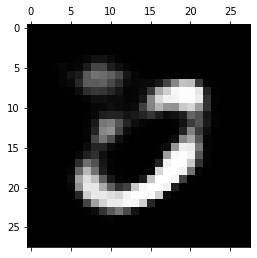

In [50]:
plt.matshow(model.sample(n=1).reshape(28, 28), cmap="gray")
plt.show()